# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$?

In [1]:
# Import everything needed
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import tqdm

from hm_process import HMProcess, plot_hm_process
from kalman import SteadyStateKalmanFilter
from rnn import NeuralNet
from utils import mk_rand_matrix, mk_rand_matrix_envals

rng = np.random.default_rng()

In [2]:
# Define some arbitrary parameters
def create_process_3d(rng, A=None):
    if A is None:
        A = np.diag([0.98, 0.96, 0.94])
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 100
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

proc = create_process_3d(rng)

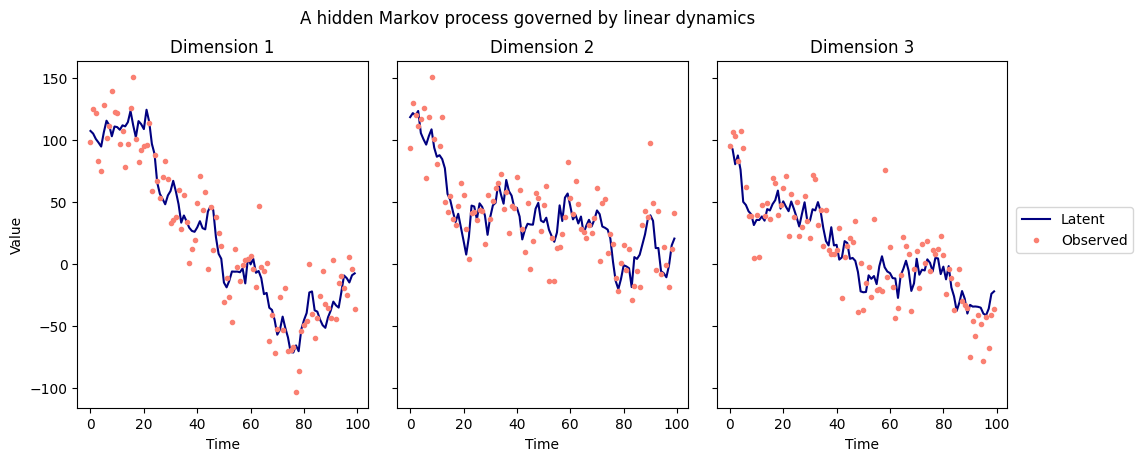

In [3]:
ts, xs, ys = proc.simulate()
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

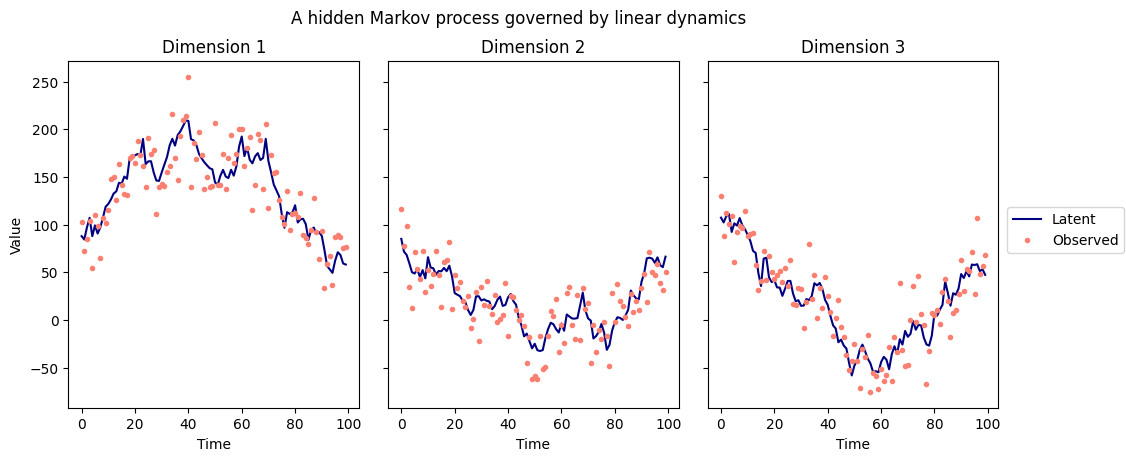

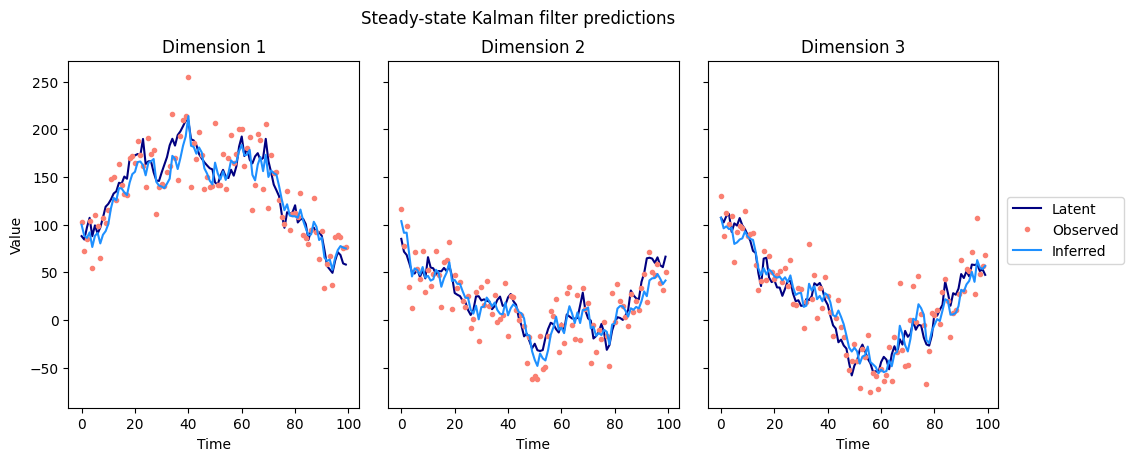

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?
ts, xs, ys = proc.simulate()
kf = SteadyStateKalmanFilter(proc)
xhats = kf.infer(ys)

# Now, let's plot it!
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

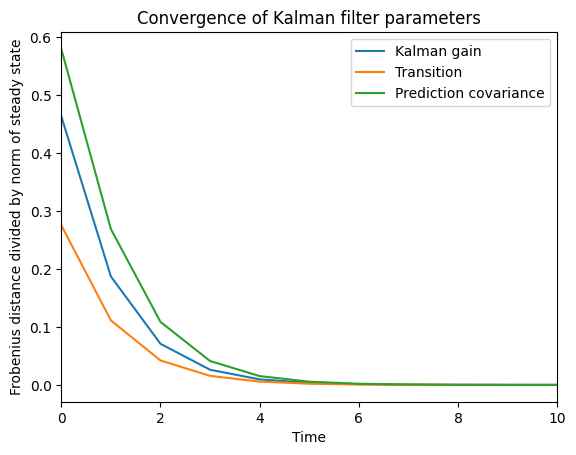

In [5]:
# Let's check how well the Kalman filter converges to the steady-state Kalman filter.
Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
plt.plot(np.arange(proc.num_steps), K_infty_dist/np.linalg.norm(kf.K_infty, ord='fro'), label='Kalman gain')
plt.plot(np.arange(proc.num_steps), M_infty_dist/np.linalg.norm(kf.M_infty, ord='fro'), label='Transition')
plt.plot(np.arange(proc.num_steps), Sigma_infty_dist/np.linalg.norm(kf.Sigma_infty, ord='fro'), label='Prediction covariance')
plt.title('Convergence of Kalman filter parameters')
plt.xlabel('Time')
plt.ylabel('Frobenius distance divided by norm of steady state')
plt.xlim(0,10)
plt.legend()
plt.show()


In [6]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
# First, let's make the matrix A of the hidden Markov process random.
A = mk_rand_matrix_envals(rng, np.array([0.98, 0.96, 0.94]))
proc = create_process_3d(rng, A)
kf = SteadyStateKalmanFilter(proc)

In [7]:
# How well does the network do if I make the connectivity matrix
# closer or farther from the Kalman filter theory steady-state value?
def test_M_landscape():
    distances = []
    losses = []
    for _ in range(3):
        M = mk_rand_matrix(rng, 3)
        for i in tqdm.tqdm(range(10)):
            c = i/10
            M2 = (1-c)*M + c*kf.M_infty
            nn = NeuralNet(kf.K_infty, M2, np.eye(3), proc.x0)
            Ls = nn.batch_test(100, proc)
            distances.append(np.linalg.norm(M2 - kf.M_infty, ord='fro'))
            losses.append(np.mean(Ls))
    return np.array(distances), np.array(losses)

# distances, losses = test_M_landscape()

In [8]:
# Let's try plotting our results
# plt.scatter(distances[:10], losses[:10])
# plt.scatter(distances[10:20], losses[10:20])
# plt.scatter(distances[20:], losses[20:])
# plt.xlabel('Frobenius distance between M and the optimal value')
# plt.ylabel('Average loss (100 simulated trials)')
# plt.title('Loss vs distance from Kalman filter theory')
# plt.show()

In [68]:
# What happens when we train the neural net on this task?
def compare_nn_kalman(rng, proc, epsilons, batch_size=40, mask=None):
    if mask is None:
        mask = np.full((proc.n, proc.n), 1)
    
    print('A =', proc.A)
    print('Eigenvalues = ', np.linalg.eig(proc.A).eigenvalues)
    
    nn = NeuralNet(0.1*mk_rand_matrix(rng, proc.n), 0.1*mk_rand_matrix(rng, proc.n), np.eye(proc.n), proc.x0, mask=mask)
    ts, xs, ys = proc.simulate()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('Before training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    losses, _, _ = nn.train(epsilons, batch_size, proc)
    plt.plot(np.log(losses))
    plt.title('Log Loss over time')
    plt.xlabel('Batch')
    plt.ylabel('Mean loss')
    plt.show()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('After training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    # How does it compare to a Kalman filter?
    kf = SteadyStateKalmanFilter(proc)
    xhats = kf.infer(ys)
    plot_hm_process('Kalman filter', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', kf.M_infty)
    print('K =', kf.K_infty)

#compare_nn_kalman(rng, proc, np.concatenate((np.full(20, 5e-7), np.full(10, 1e-7))), 40)

# Exploration 2

What's the right measure of distance between $(M,K)$ and $A$ that corresponds to the average loss at the task? We'll assume $O$ and $W$ are the identity. Can we plot a loss landscape for the task?

In [10]:
# Let's start with 1 dimension for easy visualization
def create_1d_process(rng, A):
    x0 = np.array([100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.array([[1]])
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

batch_size = 5
num_a_ticks = 5
num_ticks = 20
a_vals = np.array([-0.95, -0.8, 0, 0.8, 0.95])
num_a_ticks = a_vals.shape[0]
mk_range = 0.99
num_trials_per = 40
W = np.array([[1]])

In [11]:
def find_nn_values_A_M_K_1d(num_nns=2):
    mks = [] # mks[i][j] contains the values of M and K for the jth trial with the ith value of A

    for i, a_ in enumerate(a_vals):
        A = np.array([[a_]])
        mks_i = []
        for j in tqdm.tqdm(range(num_nns)):
            proc = create_1d_process(rng, A)
            nn = NeuralNet(0.1*mk_rand_matrix(rng, 1), 0.1*mk_rand_matrix(rng, 1), np.eye(1), proc.x0)
            _, Ms, Ks = nn.train(np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))), num_trials_per, proc,
                                 print_loss=False, progress_bar=False)
            mks_i.append((Ms.flatten(), Ks.flatten()))
        mks.append(mks_i)

    return mks

# mks = find_nn_values_A_M_K_1d()

In [12]:
def test_A_M_K_loss_landscape_1d():
    losses = np.zeros((num_a_ticks,num_ticks,num_ticks))
    W = np.array([[1]])
    
    for i1, a_ in tqdm.tqdm(enumerate(a_vals), total=num_a_ticks):
        for i2, m_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            for i3, k_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
                A = np.array([[a_]])
                M = np.array([[m_]])
                K = np.array([[k_]])
                proc = create_1d_process(rng, A)
                nn = NeuralNet(M, K, W, proc.x0)
                Ls = nn.batch_test(batch_size, proc)
                losses[i1,i2,i3] = np.mean(Ls)
    
    return losses

# losses = test_A_M_K_loss_landscape_1d()

In [13]:
# norm = matplotlib.colors.Normalize(3, 4.8)
# for i1, a_ in enumerate(a_vals):

#    # Loss landscape
#    c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#    plt.xlabel('M')
#    plt.ylabel('K')

#    # Where does the Kalman filter fall?
#    A = np.array([[a_]])
#    proc = create_1d_process(rng, A)
#    kf = SteadyStateKalmanFilter(proc)
#    plt.plot(kf.M_infty, kf.K_infty, color='black', marker='o')
#    plt.annotate('Kalman filter', (kf.M_infty, kf.K_infty),
#                 xytext=(kf.M_infty-0.2, kf.K_infty+0.05), color='black')

#    # What about the RNNs?
#    colors = ['red', 'tomato']
#    for j in range(2):
#        plt.plot(mks[i1][j][0], mks[i1][j][1], color=colors[j], linestyle='-', marker='o', markersize=3)
   
#    plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
#    plt.xlim(-1*mk_range, mk_range)
#    plt.ylim(-1*mk_range, mk_range)
#    plt.colorbar(c)
#    plt.show()

In [14]:
#def test_mk(proc, m_, k_):
#    A, M, K = proc.A, np.array([[m_]]), np.array([[k_]])
#    nn = NeuralNet(M, K, W, proc.x0)
#    proc = create_1d_process(rng, A)
#    losses = nn.batch_test(100, proc)
#    print(np.mean(losses))

#A = np.array([[a_vals[-1]]])
#proc = create_1d_process(rng, A)
#kf = SteadyStateKalmanFilter(proc)

#m_ = mks[-1][0][0][-1]
#k_ = mks[-1][0][1][-1]
#test_mk(proc, m_, k_)
#test_mk(proc, kf.M_infty, kf.K_infty)

#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.array([[m_]]), np.array([[k_]]), np.eye(1), proc.x0)
#_, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

In [15]:
# # What about two dimensions?
# def create_2d_process(rng, A):
#     x0 = np.array([100, 100])
#     sigma_process = 10
#     Sigma_process = (sigma_process**2)*np.eye(2)
#     O = np.eye(2)
#     sigma_obs = 20
#     Sigma_obs = (sigma_obs**2)*np.eye(2)
#     num_steps = 50
#     return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

# batch_size = 5
# num_a_ticks = 5
# num_ticks = 20
# A = mk_rand_matrix_envals(rng, np.array([0.9, 0.97]))
# proc = create_2d_process(rng, A)
# kf = SteadyStateKalmanFilter(proc)
# mk_range = 0.99
# num_trials_per = 40
# W = np.eye(2)

In [16]:
# def test_K_loss_landscape_2d():
#     M = kf.M_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_k1, k_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_k2, k_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             K = mk_rand_matrix_envals(rng, np.array([k_ev1, k_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_k1,i_k2] = np.mean(Ls)
    
#     return losses

# #losses_K = test_K_loss_landscape_2d()

In [17]:
# def test_M_loss_landscape_2d():
#     K = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M = mk_rand_matrix_envals(rng, 2, np.array([m_ev1, m_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M = test_M_loss_landscape_2d()

In [18]:
# def test_M_loss_landscape_2d_diagentry():
#     K = kf.K_infty
#     M = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M[0,0] = m1
#             M[1,1] = m2
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M_diag = test_M_loss_landscape_2d_diagentry()

In [19]:
# Loss landscape
#norm = matplotlib.colors.Normalize(4, 6)
#c = plt.imshow(np.log10(losses_M_diag.T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#plt.xlabel('M diag 1')
#plt.ylabel('M diag 2')

# Where does the Kalman filter fall?
#envals = (kf.M_infty[0,0], kf.M_infty[1,1])
#plt.plot(envals[0], envals[1], color='black', marker='o')
#plt.annotate('Kalman filter', (envals[0], envals[1]),
#             xytext=(envals[0]-0.2, envals[1]+0.05), color='black')

# What about the RNNs?
#plt.scatter(mks[i1,:,0], mks[i1,:,1], color='red', marker='o')

#plt.title(f'M Log-Loss Landscape')
#plt.xlim(-1*mk_range, mk_range)
#plt.ylim(-1*mk_range, mk_range)
#plt.colorbar(c)
#plt.show()

In [20]:
#kf = SteadyStateKalmanFilter(proc)
#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.diag((0,0.5)), kf.K_infty, np.eye(2), proc.x0)
#_, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

#print(kf.Sigma_infty)

# Exploration 3
The goal of this exploration is to work out some possible bugs with the implementation of the Kalman filter (why does the covariance matrix not converge properly?) and find an appropriate method to systematically determine values of the buy-in period (at what time step do we start the loss calculation?) and input gain.

First bug solved: the issue was that I was plotting the distance between the posterior estimate covariance and the steady-state estimate covariance when I should have been plotting the distance between the prior estimate covariance and the steady-state estimate covariance instead. Now the graph looks as expected.

Let's experiment next with simulating 1D processes and checking how long the buy-in period is.

In [21]:
def create_process_1d_more_parameters(rng, a, sigma_process, sigma_obs):
    A = np.array([[a]])
    x0 = np.array([100])
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.eye(1)
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps, start_from=0)

def time_of_convergence(proc, eps=0.05, i=0):
    kf = SteadyStateKalmanFilter(proc)
    Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
    for i in range(proc.num_steps-1,-1,-1):
        if Sigma_infty_dist[i] > eps:
            return i+1
        if K_infty_dist[i] > eps:
            return i+1
        if M_infty_dist[i] > eps:
            return i+1
    return 0

def plot_1d_kalman_convergence_dynamics():
    num_points = 100
    a_vals = np.linspace(0.01,0.99,num_points)
    t_vals = np.zeros(num_points)
    for i in range(num_points):
        proc = create_process_1d_more_parameters(rng, a_vals[i], 10, 25)
        t_vals[i] = time_of_convergence(proc)
    plt.plot(a_vals, t_vals, label='Actual trend')
    plt.plot(a_vals, -1/np.log(a_vals), label='Proportional to time constant')
    plt.plot(a_vals, 11*a_vals+2, label='Roughly linear')
    plt.title('Length of buy-in period vs largest eigenvalue (1D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.ylim(0,12)
    plt.legend()
    plt.show()

#plot_1d_kalman_convergence_dynamics()

It looks like the fit is not proportional to the time constant of the process, as I would have expected, but instead is roughly linear! Choosing a buy-in time period of eleven times the value of A plus two should be sufficient for letting the Kalman filter converge. What if we try changing the noise parameters?

In [22]:
def plot_1d_kalman_convergence_noise():
    num_points = 30
    max_proc_noise = 50
    max_obs_noise = 50
    sigma_proc_vals = np.linspace(1,max_proc_noise,num_points)
    sigma_obs_vals = np.linspace(1,max_obs_noise,num_points)
    t_vals = np.zeros((num_points,num_points))
    for i in range(num_points):
        for j in range(num_points):
            proc = create_process_1d_more_parameters(rng, 0.99, sigma_proc_vals[i], sigma_obs_vals[j])
            t_vals[i,j] = time_of_convergence(proc)
    norm = matplotlib.colors.Normalize(0, 11)
    plt.imshow(t_vals, extent=(1,max_obs_noise,1,max_proc_noise), origin='lower', norm=norm)
    x_vals = np.linspace(1, max_obs_noise, 200)
    plt.plot(x_vals, x_vals/2, color='red')
    plt.title('Length of buy-in period vs noise (1D)')
    plt.xlabel('Observation noise standard deviation')
    plt.ylabel('Process noise standard deviation')
    plt.xlim(1, max_obs_noise)
    plt.ylim(1, max_proc_noise)
    plt.colorbar()
    plt.show()

#plot_1d_kalman_convergence_noise()

Process and observation noise seem to make the convergence take much longer when the observation noise is high and the process noise is very low. A=0.99 originally took 11 steps, and most of this graph is in the non-yellow region where the number of steps needed is below 11 steps, as long as the observation noise is less than twice the process noise (which is the red line).

Now, let's try it with multi-dimensional processes.

In [23]:
def create_process_3d_based_on_envals(rng, enval1, enval2, enval3):
    A = mk_rand_matrix_envals(rng, np.array([enval1, enval2, enval3]))
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def plot_3d_kalman_convergence_dynamics():
    max_envals = []
    t_vals = []
    num_points = 10
    enval_space = np.linspace(0.01,0.99,num_points)
    for enval1 in enval_space:
        for enval2 in enval_space:
            for enval3 in enval_space:
                try:
                    proc = create_process_3d_based_on_envals(rng, enval1, enval2, enval3)
                    t_vals.append(time_of_convergence(proc))
                    max_envals.append(max(enval1, enval2, enval3))
                except sklearn.exceptions.ConvergenceWarning:
                    pass
    
    plt.scatter(max_envals, t_vals)
    plt.title('Length of buy-in period vs largest eigenvalue (3D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.show()

#plot_3d_kalman_convergence_dynamics()

The graph has roughly the same shape as in the 1D case, which is reassuring, although there are some matrices which are outliers. Let's check one of them by hand. All in all, I conclude that if the process noise is more than half the observation noise, then a buy-in period of a little bit more than 10 times the largest eigenvalue of the dynamics matrix should suffice.

Next, how do we deal with the input gain?

In [24]:
def find_appropriate_gain(proc, M):
    # return best K?
    pass

def plot_gain_function():
    norm = matplotlib.colors.Normalize(3, 4.8)
    for i1, a_ in enumerate(a_vals):
    
        # Loss landscape
        c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
        plt.xlabel('M')
        plt.ylabel('K')
    
        # Best values for K, given M?
        ms = np.linspace(-1*mk_range, mk_range, 100)
        ks = []
        proc = create_1d_process(rng, np.array([[a_]]))
        for m_ in ms:
            K = find_appropriate_gain(proc, np.array([[m_]]))
            ks.append(K[0,0])
        ks = np.array(ks)
        plt.plot(ms, ks, color='red')
        
        plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
        plt.xlim(-1*mk_range, mk_range)
        plt.ylim(-1*mk_range, mk_range)
        plt.colorbar(c)
        plt.show()

#plot_gain_function()

# Exploration 4
Now, what if we add some structure onto our connectivity matrix?

In [25]:
# Let's see if the loss is impacted by a mask

def mk_nd_proc(rng, n, envals=None, A=None):
    if A is None:
        if envals is None:
            envals = np.linspace(0.8, 0.95, n)
        A = mk_rand_matrix_envals(rng, envals)
    x0 = np.full(n, 100)
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(n)
    O = np.eye(n)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(n)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def test_masks(rng, n, masks, etas, envals=None, A=None):
    num_processes = 1
    num_nns = 3
    batch_size = 40
    processes = []
    data = [] # loss indexed by process number, then number of connections, then pattern
    for process_num in range(num_processes):
        data_this_rep = dict()
        proc = mk_nd_proc(rng, n, envals=envals, A=A)
    
        print('Process dynamics:', proc.A)
        print('Eigenvalues:', np.linalg.eig(proc.A).eigenvalues)
        kf = SteadyStateKalmanFilter(proc)
        print('Kalman filter M:', kf.M_infty)
        print('Kalman filter K:', kf.K_infty)
        nn = NeuralNet(kf.M_infty, kf.K_infty, np.eye(n), proc.x0)
        Ls = nn.batch_test(batch_size, proc)
        print('Kalman filter loss:', np.mean(Ls))

        max_val_A = np.max(np.abs(proc.A))

        for name, mask in tqdm.tqdm(masks.items()):
            num_connections = np.count_nonzero(mask)
            losses = []
            trial_num = 1
            while True:
                if trial_num > 100:
                    raise FloatingPointError(f'Gradient descent of {num_nns} networks unsuccessful after 100 attempts')
                try:
                    print(f'Testing {name}, Trial {trial_num}')
                    nn = NeuralNet(0.1*max_val_A*mk_rand_matrix(rng, n), 0.1*max_val_A*mk_rand_matrix(rng, n),
                                   np.eye(n), proc.x0, mask=mask)
                    Ls, _, _ = nn.train(etas, batch_size, proc,
                                        print_loss=False, progress_bar=False)
                    losses.append(Ls[-1])
                    print('NN M:', nn.M)
                    print('NN K:', nn.K)
                    if len(losses) >= num_nns:
                        break
                    trial_num += 1
                except FloatingPointError:
                    trial_num += 1
            min_loss = np.min(losses)
            if num_connections in data_this_rep:
                data_this_rep[num_connections][name] = min_loss
            else:
                data_this_rep[num_connections] = {name: min_loss}
        processes.append(proc)
        data.append(data_this_rep)
        
        N = len(data_this_rep)
        fig, axs = plt.subplots(1, N, sharey=True, squeeze=False)
        axs = np.reshape(axs, (N,))
        fig.set_size_inches(12, 4.5)
        for i, (num_connections, d) in enumerate(data_this_rep.items()):
            xticks = np.arange(len(d))
            axs[i].bar(xticks, d.values())
            axs[i].set_xticks(xticks, d.keys(), rotation=90)
            axs[i].set_title(f'Process {process_num},\n{num_connections} connections')
        axs[0].set_ylabel('Loss')
        plt.show()

    return data

In [26]:
masks_one_neuron = {
    'Empty': np.array([[0]]),
    'One loop': np.array([[1]])
}

masks_two_neurons = {
    'Empty': np.array([
        [0, 0],
        [0, 0]
    ]),
    'One loop': np.array([
        [1, 0],
        [0, 0]
    ]),
    'Uni-directional': np.array([
        [0, 1],
        [0, 0]
    ]),
    'Two loops': np.array([
        [1, 0],
        [0, 1]
    ]),
    'Loop pointing outward': np.array([
        [1, 0],
        [1, 0]
    ]),
    'Loop pointing inward': np.array([
        [0, 0],
        [1, 1]
    ]),
    'Bidirectional': np.array([
        [0, 1],
        [1, 0]
    ]),
    'Loop pointing to loop': np.array([
        [1, 0],
        [1, 1]
    ]),
    'Loop with bidirectional': np.array([
        [1, 1],
        [1, 0]
    ]),
    'Full': np.array([
        [1, 1],
        [1, 1]
    ])
}

masks_three_neurons_all_loops = {
    'Empty': np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]),
    'Unidirectional': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Source': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Linear': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [0, 0, 1]
    ]),
    'Bidirectional out': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Transitive triangle': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Bidirectional in': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Cycle': np.array([
        [1, 0, 1],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Bidirectional source': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Two bidirectionals': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional loop': np.array([
        [1, 1, 0],
        [1, 1, 1],
        [1, 0, 1]
    ]),
    'Bidirectional sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [1, 1, 1]
    ]),
    'Full minus one': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Full': np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
    ])
}

In [ ]:
# test_masks(rng, 1, masks_one_neuron, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
#           envals=np.array([0.95]))

Process dynamics: [[ 0.7686425 -0.121744 ]
 [ 0.0467121  0.9813575]]
Eigenvalues: [0.8  0.95]
Kalman filter M: [[ 0.53550135 -0.06316309]
 [ 0.04579726  0.60582255]]
Kalman filter K: [[ 0.30464638 -0.02190032]
 [-0.02190032  0.37995197]]
Kalman filter loss: 5194.475826729


  0%|                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.52616699 -0.22005009]
 [-0.21855971  0.77192163]]
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.52517361 -0.21543606]
 [-0.21885566  0.77326254]]
Testing Empty, Trial 3


 10%|█████▎                                               | 1/10 [06:54<1:02:14, 414.93s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.52396026 -0.21938745]
 [-0.21485538  0.77556498]]
Testing One loop, Trial 1
NN M: [[0.43554646 0.        ]
 [0.         0.        ]]
NN K: [[ 0.38828508 -0.09542702]
 [-0.21380549  0.77015543]]
Testing One loop, Trial 2
NN M: [[0.37447004 0.        ]
 [0.         0.        ]]
NN K: [[ 0.43000034 -0.10015941]
 [-0.21726454  0.77668088]]
Testing One loop, Trial 3


 20%|███████████                                            | 2/10 [14:25<58:05, 435.63s/it]

NN M: [[0.44021777 0.        ]
 [0.         0.        ]]
NN K: [[ 0.38772811 -0.08867006]
 [-0.21297433  0.77057084]]
Testing Uni-directional, Trial 1
NN M: [[ 0.         -0.23177764]
 [ 0.          0.        ]]
NN K: [[ 0.44471073 -0.07967348]
 [-0.25451027  0.75362898]]
Testing Uni-directional, Trial 2
NN M: [[ 0.         -0.23269271]
 [ 0.          0.        ]]
NN K: [[ 0.44933384 -0.07281438]
 [-0.24937199  0.75230975]]
Testing Uni-directional, Trial 3


 30%|████████████████▌                                      | 3/10 [21:12<49:18, 422.57s/it]

NN M: [[ 0.         -0.23354685]
 [ 0.          0.        ]]
NN K: [[ 0.44194073 -0.0695794 ]
 [-0.25104307  0.75814781]]
Testing Two loops, Trial 1
NN M: [[0.28439367 0.        ]
 [0.         0.27274049]]
NN K: [[ 0.44191136 -0.13792795]
 [-0.11487936  0.61299535]]
Testing Two loops, Trial 2


/home/etao/Desktop/cmu-project/rnn.py:109: RuntimeWarning: overflow encountered in matmul
  rs[i] = self.M @ rs[i-1] + self.K @ ys[i]
/home/etao/Desktop/cmu-project/rnn.py:110: RuntimeWarning: invalid value encountered in matmul
  xhats[i] = self.W @ rs[i]
/home/etao/Desktop/cmu-project/rnn.py:109: RuntimeWarning: invalid value encountered in matmul
  rs[i] = self.M @ rs[i-1] + self.K @ ys[i]


Testing Two loops, Trial 3
Testing Two loops, Trial 4
NN M: [[0.30247017 0.        ]
 [0.         0.33629949]]
NN K: [[ 0.43988622 -0.12936887]
 [-0.08999954  0.57659468]]
Testing Two loops, Trial 5


 40%|██████████████████████                                 | 4/10 [28:08<42:00, 420.13s/it]

NN M: [[0.4345219  0.        ]
 [0.         0.33137922]]
NN K: [[ 0.39092514 -0.08628863]
 [-0.09242745  0.57581944]]
Testing Loop pointing outward, Trial 1
NN M: [[ 0.30315489  0.        ]
 [-0.38584392  0.        ]]
NN K: [[ 0.3905804  -0.17247003]
 [-0.08472587  0.65815664]]
Testing Loop pointing outward, Trial 2
NN M: [[ 0.38168897  0.        ]
 [-0.38832604  0.        ]]
NN K: [[ 0.36176788 -0.13886125]
 [-0.0861855   0.65773794]]
Testing Loop pointing outward, Trial 3


 50%|███████████████████████████▌                           | 5/10 [34:43<34:14, 410.92s/it]

NN M: [[ 0.21578842  0.        ]
 [-0.30007229  0.        ]]
NN K: [[ 0.44597068 -0.1845198 ]
 [-0.12752647  0.6810729 ]]
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [-0.24336974  0.26211856]]
NN K: [[ 0.48854901 -0.24222011]
 [-0.02331639  0.5554525 ]]
Testing Loop pointing inward, Trial 2
NN M: [[ 0.          0.        ]
 [-0.29396532  0.12575628]]
NN K: [[ 0.48623146 -0.24435096]
 [-0.06714017  0.63432416]]
Testing Loop pointing inward, Trial 3
Testing Loop pointing inward, Trial 4


 60%|█████████████████████████████████                      | 6/10 [41:36<27:27, 411.91s/it]

NN M: [[ 0.          0.        ]
 [-0.23746262  0.2508066 ]]
NN K: [[ 0.49794157 -0.23866812]
 [-0.03806748  0.55626187]]
Testing Bidirectional, Trial 1
Testing Bidirectional, Trial 2
Testing Bidirectional, Trial 3
NN M: [[ 0.         -0.24645897]
 [-0.36447868  0.        ]]
NN K: [[ 0.39987882 -0.11065414]
 [-0.13936832  0.64155546]]
Testing Bidirectional, Trial 4
Testing Bidirectional, Trial 5
Testing Bidirectional, Trial 6
Testing Bidirectional, Trial 7
Testing Bidirectional, Trial 8
NN M: [[ 0.         -0.24846377]
 [-0.38202345  0.        ]]
NN K: [[ 0.38882271 -0.10830452]
 [-0.13440135  0.63526436]]
Testing Bidirectional, Trial 9
Testing Bidirectional, Trial 10


 70%|██████████████████████████████████████▌                | 7/10 [49:51<21:56, 438.92s/it]

NN M: [[ 0.         -0.33720862]
 [-0.32141638  0.        ]]
NN K: [[ 0.36787835 -0.04321318]
 [-0.17956473  0.63272054]]
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.42432535  0.        ]
 [-0.08545987  0.35315373]]
NN K: [[ 0.38876154 -0.09420449]
 [-0.03934871  0.53969362]]
Testing Loop pointing to loop, Trial 2
Testing Loop pointing to loop, Trial 3
Testing Loop pointing to loop, Trial 4
NN M: [[ 0.37305484  0.        ]
 [-0.06408897  0.26309525]]
NN K: [[ 0.41218208 -0.10738042]
 [-0.08679574  0.60876096]]
Testing Loop pointing to loop, Trial 5
Testing Loop pointing to loop, Trial 6


 80%|████████████████████████████████████████████           | 8/10 [57:29<14:50, 445.11s/it]

NN M: [[ 0.39729543  0.        ]
 [-0.04823048  0.26393946]]
NN K: [[ 0.40763092 -0.10185323]
 [-0.09721354  0.61480697]]
Testing Loop with bidirectional, Trial 1
NN M: [[-0.01373753 -0.31458772]
 [-0.38855728  0.        ]]
NN K: [[ 0.36193143 -0.08044733]
 [-0.16150152  0.61352489]]
Testing Loop with bidirectional, Trial 2
NN M: [[ 0.03763805 -0.3007751 ]
 [-0.43286971  0.        ]]
NN K: [[ 0.34752989 -0.07604866]
 [-0.13789905  0.59612913]]
Testing Loop with bidirectional, Trial 3
Testing Loop with bidirectional, Trial 4


 90%|███████████████████████████████████████████████▋     | 9/10 [1:04:15<07:12, 432.81s/it]

NN M: [[-0.008825   -0.32918951]
 [-0.4516553   0.        ]]
NN K: [[ 0.33653836 -0.08035081]
 [-0.13785876  0.58691328]]
Testing Full, Trial 1
Testing Full, Trial 2
Testing Full, Trial 3
NN M: [[ 0.21261473 -0.13847687]
 [-0.01670875  0.32862346]]
NN K: [[ 0.4267157  -0.05533531]
 [-0.10522669  0.57127906]]
Testing Full, Trial 4
Testing Full, Trial 5
Testing Full, Trial 6
Testing Full, Trial 7
Testing Full, Trial 8
NN M: [[ 0.22796148 -0.0980851 ]
 [ 0.00617231  0.29116448]]
NN K: [[ 0.44129815 -0.08335374]
 [-0.12319536  0.60954146]]
Testing Full, Trial 9


100%|████████████████████████████████████████████████████| 10/10 [1:12:00<00:00, 432.03s/it]

NN M: [[ 0.26384716 -0.10907489]
 [-0.04387553  0.35945925]]
NN K: [[ 0.42380472 -0.05767963]
 [-0.07661967  0.54064072]]


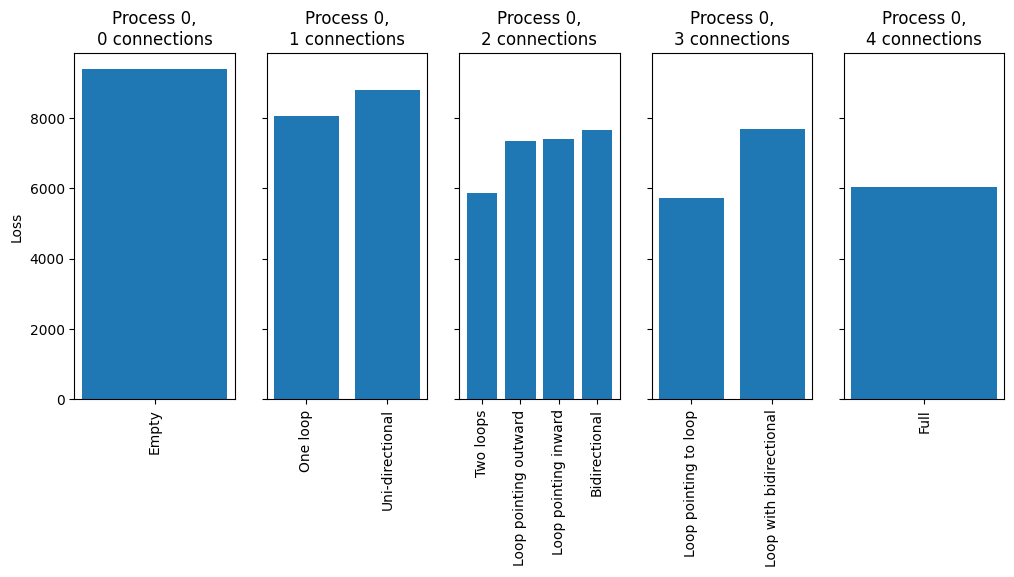

[{0: {'Empty': 9384.325258755154},
  1: {'One loop': 8069.624204289489, 'Uni-directional': 8786.902622894397},
  2: {'Two loops': 5876.090526281641,
   'Loop pointing outward': 7361.999189583558,
   'Loop pointing inward': 7418.882746819946,
   'Bidirectional': 7666.544939133627},
  3: {'Loop pointing to loop': 5723.242435329684,
   'Loop with bidirectional': 7693.612974203333},
  4: {'Full': 6032.261221490941}}]

In [27]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
           envals=np.array([0.8, 0.95]))

#test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
#           envals=np.array([0.95, -0.3]))

Process dynamics: [[0.   0.95]
 [0.8  0.  ]]
Eigenvalues: [ 0.87177979 -0.87177979]
Kalman filter M: [[0.         0.61670586]
 [0.54254392 0.        ]]
Kalman filter K: [[0.35083594 0.        ]
 [0.         0.3218201 ]]
Kalman filter loss: 5148.47713876668


  0%|                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.54702662 0.01314452]
 [0.01941884 0.50876147]]
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.54810786 0.01412261]
 [0.01244173 0.50839599]]
Testing Empty, Trial 3


 10%|█████▌                                                 | 1/10 [05:27<49:11, 327.92s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.55115756 0.0183818 ]
 [0.02190652 0.51158448]]
Testing One loop, Trial 1
NN M: [[0.04604089 0.        ]
 [0.         0.        ]]
NN K: [[0.54807289 0.01301557]
 [0.01824483 0.5085334 ]]
Testing One loop, Trial 2
NN M: [[0.09177022 0.        ]
 [0.         0.        ]]
NN K: [[0.54036493 0.01697106]
 [0.02296736 0.50513492]]
Testing One loop, Trial 3


 20%|███████████                                            | 2/10 [10:54<43:36, 327.09s/it]

NN M: [[0.05822289 0.        ]
 [0.         0.        ]]
NN K: [[0.54138362 0.01240759]
 [0.01182856 0.50332865]]
Testing Uni-directional, Trial 1
NN M: [[0.         0.49280602]
 [0.         0.        ]]
NN K: [[0.43184395 0.00759772]
 [0.01487306 0.51932263]]
Testing Uni-directional, Trial 2
NN M: [[0.         0.47808065]
 [0.         0.        ]]
NN K: [[0.43702284 0.00493154]
 [0.01792369 0.52620867]]
Testing Uni-directional, Trial 3


 30%|████████████████▌                                      | 3/10 [16:22<38:13, 327.64s/it]

NN M: [[0.         0.50807437]
 [0.         0.        ]]
NN K: [[0.42903167 0.00883461]
 [0.01685461 0.51890812]]
Testing Two loops, Trial 1
NN M: [[-0.01435793  0.        ]
 [ 0.         -0.00666585]]
NN K: [[0.54523523 0.02188164]
 [0.01835449 0.50856027]]
Testing Two loops, Trial 2
NN M: [[ 0.02022306  0.        ]
 [ 0.         -0.05256164]]
NN K: [[0.5488383  0.01357278]
 [0.0174301  0.50837093]]
Testing Two loops, Trial 3


 40%|██████████████████████                                 | 4/10 [21:49<32:44, 327.48s/it]

NN M: [[0.08785238 0.        ]
 [0.         0.05451357]]
NN K: [[0.53958531 0.01329885]
 [0.01733788 0.50583359]]
Testing Loop pointing outward, Trial 1
NN M: [[0.13726068 0.        ]
 [0.47784963 0.        ]]
NN K: [[ 0.5373563   0.01415116]
 [-0.00893095  0.37978337]]
Testing Loop pointing outward, Trial 2
NN M: [[0.09475058 0.        ]
 [0.46168111 0.        ]]
NN K: [[ 0.548979    0.00580144]
 [-0.0048382   0.38599908]]
Testing Loop pointing outward, Trial 3


 50%|███████████████████████████▌                           | 5/10 [27:18<27:19, 327.89s/it]

NN M: [[0.1499213  0.        ]
 [0.47575168 0.        ]]
NN K: [[ 0.53374197  0.0111235 ]
 [-0.01037729  0.38363304]]
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [ 0.45172857 -0.0253336 ]]
NN K: [[0.55378686 0.02054413]
 [0.0133608  0.38735934]]
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.46158598 0.07531869]]
NN K: [[ 0.55060539  0.00765296]
 [-0.01256159  0.38265487]]
Testing Loop pointing inward, Trial 3


 60%|█████████████████████████████████                      | 6/10 [32:47<21:52, 328.23s/it]

NN M: [[0.         0.        ]
 [0.45582081 0.05271585]]
NN K: [[ 0.5592856   0.00233061]
 [-0.00985872  0.38763292]]
Testing Bidirectional, Trial 1
NN M: [[0.         0.58154546]
 [0.53987997 0.        ]]
NN K: [[ 0.36469939  0.00543455]
 [-0.00063775  0.33519942]]
Testing Bidirectional, Trial 2
NN M: [[0.         0.57183452]
 [0.53569549 0.        ]]
NN K: [[0.36867232 0.00330769]
 [0.00062217 0.33576885]]
Testing Bidirectional, Trial 3


 70%|██████████████████████████████████████▌                | 7/10 [38:15<16:24, 328.33s/it]

NN M: [[0.         0.58642381]
 [0.53548319 0.        ]]
NN K: [[0.36216301 0.00820165]
 [0.00318833 0.33264043]]
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.09451254  0.        ]
 [ 0.47069638 -0.02155363]]
NN K: [[0.54567596 0.01600451]
 [0.0019471  0.38324128]]
Testing Loop pointing to loop, Trial 2
NN M: [[ 0.155896    0.        ]
 [ 0.48418587 -0.07683343]]
NN K: [[0.52992621 0.02713847]
 [0.01068814 0.37794799]]
Testing Loop pointing to loop, Trial 3


 80%|████████████████████████████████████████████           | 8/10 [43:45<10:57, 328.58s/it]

NN M: [[0.05137518 0.        ]
 [0.47503806 0.02341042]]
NN K: [[ 0.55387205  0.01205688]
 [-0.00701597  0.3818674 ]]
Testing Loop with bidirectional, Trial 1
NN M: [[0.00513657 0.58000907]
 [0.537052   0.        ]]
NN K: [[ 3.64179115e-01 -2.51797018e-04]
 [-2.01666401e-03  3.34898544e-01]]
Testing Loop with bidirectional, Trial 2
NN M: [[-5.63287056e-04  5.85131836e-01]
 [ 5.35931099e-01  0.00000000e+00]]
NN K: [[0.36523888 0.00248291]
 [0.00365664 0.3335172 ]]
Testing Loop with bidirectional, Trial 3


 90%|█████████████████████████████████████████████████▌     | 9/10 [49:12<05:28, 328.32s/it]

NN M: [[0.03039707 0.57969046]
 [0.5331326  0.        ]]
NN K: [[ 0.36813449 -0.00583498]
 [-0.01008543  0.33593606]]
Testing Full, Trial 1
NN M: [[-0.01930322  0.59218275]
 [ 0.53111458  0.03423486]]
NN K: [[ 0.36620757 -0.00528389]
 [-0.00463496  0.33134936]]
Testing Full, Trial 2
NN M: [[ 0.00475027  0.57375083]
 [ 0.54830867 -0.02602907]]
NN K: [[0.3658018  0.00715808]
 [0.00620989 0.33671611]]
Testing Full, Trial 3


100%|██████████████████████████████████████████████████████| 10/10 [54:41<00:00, 328.13s/it]

NN M: [[0.01761164 0.57087635]
 [0.53727905 0.01947292]]
NN K: [[ 0.36980195 -0.01320695]
 [-0.01363754  0.33525857]]


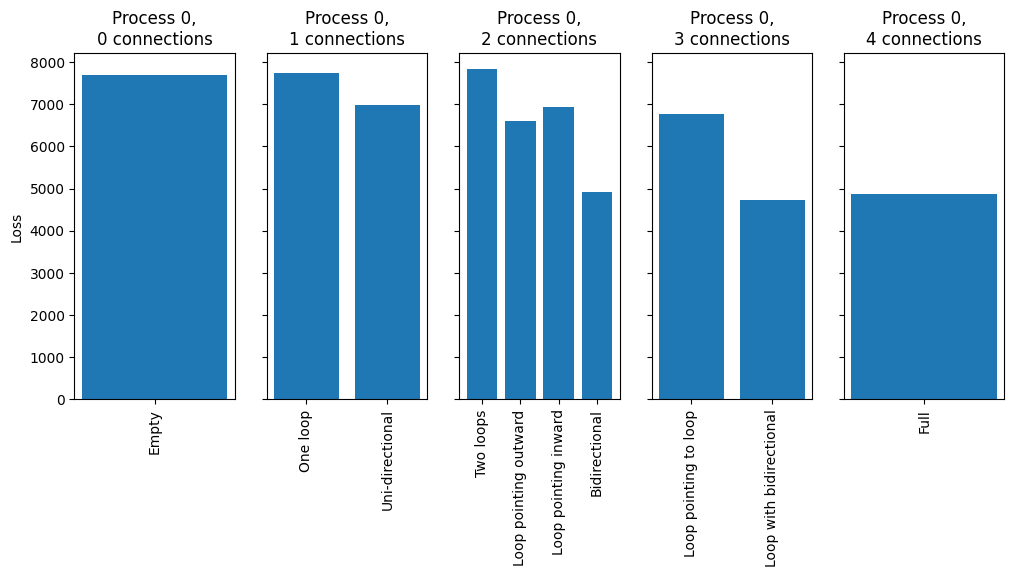

[{0: {'Empty': 7700.9315046873035},
  1: {'One loop': 7728.396291836787, 'Uni-directional': 6988.378738754659},
  2: {'Two loops': 7824.765498116374,
   'Loop pointing outward': 6605.610862848986,
   'Loop pointing inward': 6927.683727289121,
   'Bidirectional': 4925.402983248304},
  3: {'Loop pointing to loop': 6765.550589980807,
   'Loop with bidirectional': 4724.368991875376},
  4: {'Full': 4860.373770817832}}]

In [32]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
           A=np.array([[0, 0.95], [0.8, 0]]))

Process dynamics: [[ 0.6  0.8]
 [-0.8  0.6]]
Eigenvalues: [0.6+0.8j 0.6-0.8j]
Kalman filter M: [[ 0.36576708  0.48768944]
 [-0.48768944  0.36576708]]
Kalman filter K: [[ 3.90388203e-01 -7.85824477e-18]
 [ 1.17873672e-17  3.90388203e-01]]
Kalman filter loss: 5411.843644805048


  0%|                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 9.73975639e-01 -8.41945477e-04]
 [ 1.27842301e-03  9.68561710e-01]]
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 9.71632792e-01 -4.76048601e-04]
 [ 5.58000446e-04  9.68226586e-01]]
Testing Empty, Trial 3


 10%|█████▎                                               | 1/10 [09:56<1:29:30, 596.73s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 9.69282670e-01  1.23536134e-04]
 [-3.81373538e-04  9.72607224e-01]]
Testing One loop, Trial 1
NN M: [[0.3714043 0.       ]
 [0.        0.       ]]
NN K: [[ 7.55680548e-01  2.88001948e-01]
 [-8.84869741e-04  9.70473434e-01]]
Testing One loop, Trial 2
NN M: [[ 0.42566547  0.        ]
 [-0.          0.        ]]
NN K: [[0.72625049 0.33319355]
 [0.0014045  0.97036405]]
Testing One loop, Trial 3


 20%|██████████▌                                          | 2/10 [20:03<1:20:19, 602.45s/it]

NN M: [[0.3939877 0.       ]
 [0.        0.       ]]
NN K: [[ 0.7433616   0.30898254]
 [-0.00166027  0.96881058]]
Testing Uni-directional, Trial 1
NN M: [[0.         0.38300584]
 [0.         0.        ]]
NN K: [[ 0.6817894  -0.21188013]
 [ 0.00351461  0.96611925]]
Testing Uni-directional, Trial 2
NN M: [[0.         0.43542696]
 [0.         0.        ]]
NN K: [[ 0.64402053 -0.24327246]
 [ 0.00588676  0.97334828]]
Testing Uni-directional, Trial 3


 30%|███████████████▉                                     | 3/10 [31:53<1:16:00, 651.48s/it]

NN M: [[0.         0.39814142]
 [0.         0.        ]]
NN K: [[ 0.66910796 -0.22071563]
 [ 0.00415773  0.96844107]]
Testing Two loops, Trial 1
NN M: [[0.28289584 0.        ]
 [0.         0.41759289]]
NN K: [[ 0.81413771  0.21938791]
 [-0.32227145  0.73354071]]
Testing Two loops, Trial 2
NN M: [[0.38283828 0.        ]
 [0.         0.35067127]]
NN K: [[ 0.75080297  0.29684029]
 [-0.27374523  0.76827639]]
Testing Two loops, Trial 3


 40%|█████████████████████▏                               | 4/10 [45:02<1:10:36, 706.03s/it]

NN M: [[ 0.35370906  0.        ]
 [-0.          0.4128795 ]]
NN K: [[ 0.76814602  0.27416604]
 [-0.32015267  0.73361267]]
Testing Loop pointing outward, Trial 1
NN M: [[ 0.36468868  0.        ]
 [-0.41660553  0.        ]]
NN K: [[0.76247872 0.28064392]
 [0.23275019 0.655723  ]]
Testing Loop pointing outward, Trial 2
NN M: [[ 0.39544758  0.        ]
 [-0.42814975  0.        ]]
NN K: [[0.74800677 0.30367828]
 [0.24059129 0.64848627]]
Testing Loop pointing outward, Trial 3


 50%|██████████████████████████▌                          | 5/10 [58:17<1:01:30, 738.15s/it]

NN M: [[ 0.40740007  0.        ]
 [-0.43568872  0.        ]]
NN K: [[0.73880774 0.31135295]
 [0.24488362 0.64354967]]
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [-0.28973416  0.41902369]]
NN K: [[ 0.97193366  0.00231281]
 [-0.16062387  0.51393502]]
Testing Loop pointing inward, Trial 2
NN M: [[ 0.          0.        ]
 [-0.41726959  0.37266474]]
NN K: [[ 9.74914163e-01 -8.85927175e-04]
 [-5.03140127e-02  4.45707948e-01]]
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████▊                     | 6/10 [1:07:45<45:20, 680.20s/it]

NN M: [[ 0.          0.        ]
 [-0.30281611  0.30156598]]
NN K: [[ 9.69874447e-01  5.74326202e-04]
 [-6.29001578e-02  5.73302884e-01]]
Testing Bidirectional, Trial 1
NN M: [[ 0.          0.43690435]
 [-0.32885873  0.        ]]
NN K: [[ 0.6415364  -0.25293301]
 [ 0.19366916  0.72488008]]
Testing Bidirectional, Trial 2
NN M: [[ 0.          0.43135187]
 [-0.39498633  0.        ]]
NN K: [[ 0.64505992 -0.24993521]
 [ 0.23043281  0.67262116]]
Testing Bidirectional, Trial 3


 70%|█████████████████████████████████████                | 7/10 [1:16:47<31:45, 635.04s/it]

NN M: [[ 0.          0.4146793 ]
 [-0.49846548  0.        ]]
NN K: [[ 0.65766803 -0.24012992]
 [ 0.28610594  0.59460738]]
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.41258555  0.        ]
 [-0.35890206  0.21891159]]
NN K: [[0.73749444 0.3216439 ]
 [0.03450306 0.58174157]]
Testing Loop pointing to loop, Trial 2
NN M: [[ 0.3282213   0.        ]
 [-0.25540546  0.36261085]]
NN K: [[ 0.78244134  0.25585438]
 [-0.13437146  0.57329829]]
Testing Loop pointing to loop, Trial 3


 80%|██████████████████████████████████████████▍          | 8/10 [1:25:46<20:08, 604.40s/it]

NN M: [[ 0.37751959  0.        ]
 [-0.23807084  0.3354436 ]]
NN K: [[ 0.75632659  0.29610881]
 [-0.12753031  0.60391857]]
Testing Loop with bidirectional, Trial 1
NN M: [[ 0.18762162  0.43008162]
 [-0.47509165  0.        ]]
NN K: [[ 0.54208712 -0.11878256]
 [ 0.27215556  0.60349685]]
Testing Loop with bidirectional, Trial 2
NN M: [[ 0.29455612  0.37041461]
 [-0.42139639  0.        ]]
NN K: [[0.52698401 0.00283057]
 [0.2393419  0.64862617]]
Testing Loop with bidirectional, Trial 3


 90%|███████████████████████████████████████████████▋     | 9/10 [1:35:26<09:56, 596.89s/it]

NN M: [[ 0.21245477  0.44445922]
 [-0.50343522  0.        ]]
NN K: [[ 0.51793622 -0.10699763]
 [ 0.28530095  0.58405647]]
Testing Full, Trial 1
NN M: [[ 0.10272185  0.50230521]
 [-0.43703002  0.08313767]]
NN K: [[ 0.52467397 -0.21288152]
 [ 0.19073511  0.5837734 ]]
Testing Full, Trial 2
NN M: [[ 0.27390429  0.41961119]
 [-0.44560606  0.09289224]]
NN K: [[ 0.50386103 -0.03314633]
 [ 0.18854701  0.58926406]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 10/10 [1:51:05<00:00, 666.57s/it]

NN M: [[ 0.18273315  0.25435151]
 [-0.26590282  0.38616373]]
NN K: [[ 0.68092799 -0.00325533]
 [-0.14976801  0.55015135]]


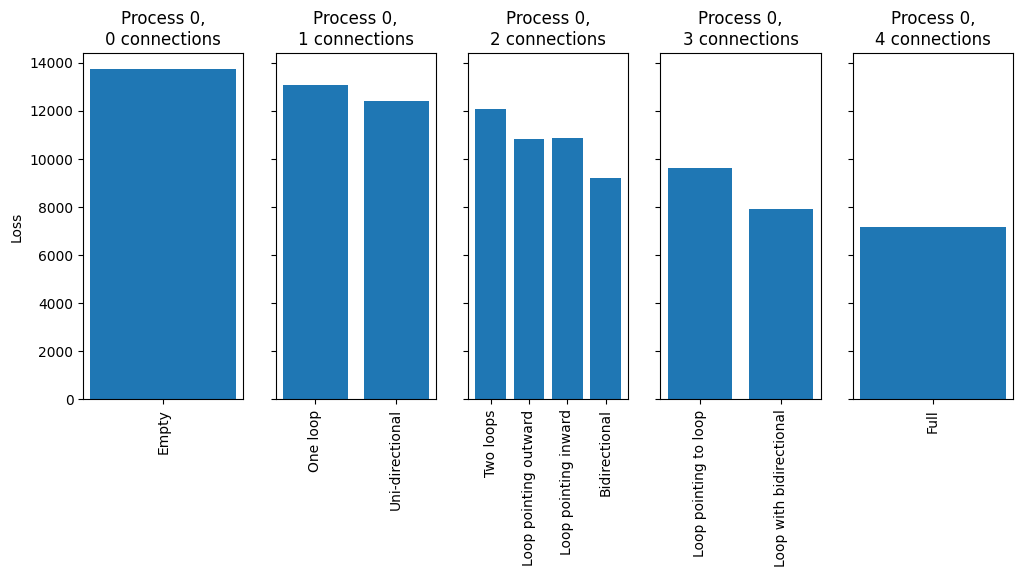

[{0: {'Empty': 13714.994038539508},
  1: {'One loop': 13068.00357574652, 'Uni-directional': 12420.23472404516},
  2: {'Two loops': 12069.091620423787,
   'Loop pointing outward': 10815.947400431987,
   'Loop pointing inward': 10861.540640110497,
   'Bidirectional': 9192.959772866008},
  3: {'Loop pointing to loop': 9605.367408107533,
   'Loop with bidirectional': 7905.886599882538},
  4: {'Full': 7179.95047868078}}]

In [28]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(20, 1e-6), np.full(30, 5e-7))),
           A=np.array([[0.6, 0.8],[-0.8, 0.6]]))

Process dynamics: [[ 0.86146207  0.02668318 -0.37115726]
 [-0.05818443  0.81554867 -0.31619765]
 [-0.0485221  -0.03500411  0.72298926]]
Eigenvalues: [0.6  0.95 0.85]
Kalman filter M: [[ 0.54141288 -0.00446833 -0.18572296]
 [-0.06095382  0.53626166 -0.16808605]
 [ 0.01088081  0.01223532  0.4862911 ]]
Kalman filter K: [[ 0.36995222  0.02368047 -0.05620573]
 [ 0.02368047  0.33978536 -0.04409899]
 [-0.05620573 -0.04409899  0.27924758]]
Kalman filter loss: 7624.02379734457


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.18939144  0.          0.        ]
 [ 0.          0.11645696  0.        ]
 [-0.          0.         -0.17074304]]
NN K: [[ 0.51086006  0.13074065 -0.22233096]
 [ 0.08680599  0.19647135 -0.1765816 ]
 [-0.14493374 -0.07615813  0.05230165]]
Testing Empty, Trial 2
NN M: [[ 0.2126701   0.          0.        ]
 [ 0.          0.04889458  0.        ]
 [ 0.         -0.          0.08136853]]
NN K: [[ 0.52955259  0.06538625 -0.13438875]
 [ 0.11391143  0.23756188 -0.05638485]
 [-0.1392375  -0.07908932  0.07662817]]
Testing Empty, Trial 3


  6%|███▎                                                | 1/16 [16:52<4:13:00, 1012.05s/it]

NN M: [[ 0.06326464  0.          0.        ]
 [ 0.          0.00804111  0.        ]
 [ 0.          0.         -0.11554148]]
NN K: [[ 0.59398594  0.10839019 -0.11808764]
 [ 0.08585472  0.20733143 -0.1159974 ]
 [-0.11685791 -0.06886137  0.07870624]]
Testing Unidirectional, Trial 1
NN M: [[ 0.16011474  0.          0.        ]
 [-0.03680137  0.20889632  0.        ]
 [ 0.          0.         -0.02605557]]
NN K: [[ 0.50243647  0.15338401 -0.26315676]
 [ 0.15444909  0.23239961 -0.05878162]
 [-0.14890841 -0.03701583  0.1127879 ]]
Testing Unidirectional, Trial 2
NN M: [[0.10949966 0.         0.        ]
 [0.0842014  0.02403679 0.        ]
 [0.         0.         0.02522025]]
NN K: [[ 0.56615319  0.17322583 -0.07849703]
 [ 0.1340928   0.11973684 -0.05346993]
 [-0.08431374 -0.06897202  0.14312524]]
Testing Unidirectional, Trial 3


 12%|██████▌                                             | 2/16 [43:14<5:14:29, 1347.82s/it]

NN M: [[ 0.13334721  0.          0.        ]
 [ 0.03179382 -0.12502911  0.        ]
 [ 0.          0.         -0.06846877]]
NN K: [[ 0.52078291  0.18136087 -0.17490804]
 [ 0.13492712  0.130038   -0.12074392]
 [-0.1792154   0.03606355 -0.0031885 ]]
Testing Source, Trial 1
NN M: [[ 0.18271271  0.          0.        ]
 [ 0.00851808  0.0648864   0.        ]
 [-0.06537292  0.         -0.05599396]]
NN K: [[ 0.52156935  0.26193748 -0.00555193]
 [ 0.11358712  0.14425388 -0.07377692]
 [-0.09558667 -0.0869803   0.10878578]]
Testing Source, Trial 2
NN M: [[ 0.26175859  0.          0.        ]
 [ 0.05895891  0.05675964  0.        ]
 [-0.01317037  0.          0.00789064]]
NN K: [[ 0.48623188  0.24152233 -0.11886228]
 [ 0.09649864  0.15259262 -0.02415858]
 [-0.1396     -0.03911111  0.06459002]]
Testing Source, Trial 3


 19%|█████████▍                                        | 3/16 [1:11:28<5:26:13, 1505.63s/it]

NN M: [[ 0.24473516  0.         -0.        ]
 [ 0.03529761  0.20557158  0.        ]
 [-0.0268845   0.          0.08091164]]
NN K: [[ 0.55011517  0.10592877 -0.14041699]
 [ 0.09016881  0.22978323 -0.10067626]
 [-0.15037508 -0.11185941  0.04004913]]
Testing Bidirectional, Trial 1
NN M: [[ 0.22691685  0.10364017  0.        ]
 [ 0.01756215 -0.09324715  0.        ]
 [ 0.         -0.          0.04810519]]
NN K: [[ 0.51201972  0.16896122 -0.15138753]
 [ 0.24207572  0.16775274  0.06580788]
 [-0.07272767 -0.12463548  0.18121397]]
Testing Bidirectional, Trial 2
NN M: [[ 0.21166198 -0.07729413  0.        ]
 [ 0.12094324 -0.12099264  0.        ]
 [-0.          0.         -0.01381355]]
NN K: [[ 0.51899055  0.17957469 -0.19839161]
 [ 0.07068728  0.11177812 -0.09389027]
 [-0.13047779 -0.03630646  0.08140651]]
Testing Bidirectional, Trial 3


 25%|████████████▌                                     | 4/16 [1:36:32<5:01:01, 1505.12s/it]

NN M: [[0.33540297 0.02053525 0.        ]
 [0.01898686 0.20938372 0.        ]
 [0.         0.         0.05662721]]
NN K: [[ 0.56460927  0.07602434 -0.03216958]
 [ 0.14316274  0.15174576 -0.01582879]
 [-0.1798474  -0.0880921   0.02127224]]
Testing Linear, Trial 1
NN M: [[ 0.15735687  0.         -0.        ]
 [-0.02078998 -0.21997138 -0.        ]
 [ 0.         -0.01678182 -0.05661524]]
NN K: [[ 0.52432894  0.16020157 -0.12382729]
 [ 0.08227268  0.25294723 -0.05933199]
 [-0.15287738 -0.10963265  0.06064175]]
Testing Linear, Trial 2
NN M: [[ 0.12093208  0.         -0.        ]
 [ 0.0387169  -0.02271938  0.        ]
 [-0.         -0.01223496  0.06525159]]
NN K: [[ 0.56269006  0.12298863 -0.11886335]
 [ 0.11967134  0.17153987 -0.14424993]
 [-0.16927722  0.01337791  0.14534044]]
Testing Linear, Trial 3


 31%|███████████████▋                                  | 5/16 [2:01:51<4:36:50, 1510.00s/it]

NN M: [[ 0.12189867  0.          0.        ]
 [ 0.00894515  0.11548831  0.        ]
 [ 0.         -0.09216546 -0.13295111]]
NN K: [[ 0.59698043  0.14694959 -0.02897148]
 [ 0.15804059  0.25653862  0.03206277]
 [-0.10093838 -0.07179109  0.11706497]]
Testing Sink, Trial 1
NN M: [[ 0.08600997  0.          0.        ]
 [ 0.15046853 -0.00211135 -0.00110992]
 [ 0.          0.         -0.06838487]]
NN K: [[ 0.62470785  0.09342854 -0.0802875 ]
 [ 0.0475098   0.21101165 -0.00303974]
 [-0.1965213  -0.01486979  0.03698326]]
Testing Sink, Trial 2
NN M: [[ 0.11505562  0.          0.        ]
 [ 0.04855735 -0.0302892  -0.18208452]
 [ 0.         -0.         -0.01840539]]
NN K: [[ 0.54330323  0.17522028 -0.12927669]
 [ 0.14173254  0.18465362 -0.01739241]
 [-0.04226971 -0.19954643  0.17982536]]
Testing Sink, Trial 3


 38%|██████████████████▊                               | 6/16 [2:24:03<4:01:35, 1449.59s/it]

NN M: [[ 0.12448783  0.          0.        ]
 [ 0.03065516  0.07477359  0.02361272]
 [-0.         -0.          0.05617218]]
NN K: [[ 0.53815953  0.08490441 -0.23456513]
 [ 0.1253178   0.21542825 -0.09040279]
 [-0.13539941  0.04764705  0.22368846]]
Testing Bidirectional out, Trial 1
NN M: [[ 0.14711658  0.15856993  0.        ]
 [ 0.0470141   0.07276217  0.        ]
 [-0.07645132  0.          0.05646027]]
NN K: [[ 0.53415955  0.12025264 -0.04763924]
 [ 0.14402325  0.20340689 -0.06729402]
 [-0.09070107 -0.11352613  0.12163211]]
Testing Bidirectional out, Trial 2
NN M: [[ 0.12085405 -0.14160162  0.        ]
 [ 0.06034789 -0.10963224  0.        ]
 [-0.08681823  0.          0.167594  ]]
NN K: [[ 0.58500166  0.08076902 -0.1583932 ]
 [ 0.01602994  0.35329255  0.08442815]
 [-0.09564614 -0.01286667  0.16753641]]
Testing Bidirectional out, Trial 3


 44%|█████████████████████▉                            | 7/16 [2:40:26<3:14:32, 1296.92s/it]

NN M: [[ 0.12384374  0.18290608  0.        ]
 [-0.00502351  0.07480338  0.        ]
 [-0.04560701  0.         -0.04953197]]
NN K: [[ 0.5069103   0.16188853 -0.10416929]
 [ 0.1947067   0.17499922 -0.14407184]
 [-0.1576226   0.00628932 -0.01274482]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.26801024  0.          0.        ]
 [ 0.03797283 -0.06168861  0.        ]
 [-0.10167804  0.0234787  -0.05130128]]
NN K: [[ 0.52636268  0.1262025  -0.15003549]
 [ 0.08242131  0.30610495 -0.11574182]
 [-0.11631432 -0.01613682  0.08400639]]
Testing Transitive triangle, Trial 2
NN M: [[ 0.17573937  0.          0.        ]
 [-0.0404095   0.03031904  0.        ]
 [ 0.02917459 -0.01273688 -0.02281235]]
NN K: [[ 0.56199623  0.0202786  -0.13703388]
 [ 0.13683967  0.20926078 -0.03845187]
 [-0.13720903 -0.07136649  0.10748982]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████                         | 8/16 [2:55:56<2:37:20, 1180.07s/it]

NN M: [[ 0.31876797  0.          0.        ]
 [-0.00498684  0.03859987  0.        ]
 [-0.04943348  0.03017451  0.04489064]]
NN K: [[ 0.51572533  0.12059105 -0.15583378]
 [ 0.14229845  0.16685529 -0.12249629]
 [-0.12207507 -0.06779416  0.13342862]]
Testing Bidirectional in, Trial 1
NN M: [[ 0.2029947  -0.03312545 -0.11806394]
 [ 0.06202557  0.19267704 -0.        ]
 [ 0.          0.         -0.07221361]]
NN K: [[ 0.52151107  0.15654378 -0.05873356]
 [ 0.07339294  0.21279021 -0.05460648]
 [-0.13125673 -0.12823234  0.14432249]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.1577495   0.02001709 -0.01116179]
 [ 0.02748986 -0.03624544  0.        ]
 [ 0.          0.          0.07241768]]
NN K: [[ 0.56644403  0.07413455 -0.15889733]
 [ 0.14819757  0.15983656 -0.0160618 ]
 [-0.15160775 -0.04251144  0.0369222 ]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▏                     | 9/16 [3:10:47<2:07:09, 1089.92s/it]

NN M: [[ 0.19801361 -0.15728373 -0.08851805]
 [ 0.09770904 -0.03898993  0.        ]
 [-0.          0.          0.02846267]]
NN K: [[ 0.56936867  0.14373894 -0.1182796 ]
 [ 0.04068146  0.21348254 -0.02706933]
 [-0.19547508 -0.01449353  0.11368465]]
Testing Cycle, Trial 1
NN M: [[ 0.25572658  0.         -0.15406221]
 [-0.06411929  0.00294927  0.        ]
 [ 0.          0.07952129  0.03483445]]
NN K: [[ 0.48290432  0.07961917 -0.20783908]
 [ 0.14664505  0.24335191  0.00459833]
 [-0.1763238  -0.14857859  0.09252008]]
Testing Cycle, Trial 2
NN M: [[ 0.39826724  0.         -0.00270604]
 [-0.01741906  0.02664814  0.        ]
 [ 0.          0.09732725 -0.05110395]]
NN K: [[ 0.50396975  0.07498882 -0.11229584]
 [ 0.16537725  0.1994233  -0.05638804]
 [-0.1096287  -0.05515867  0.18492069]]
Testing Cycle, Trial 3


 62%|██████████████████████████████▋                  | 10/16 [3:25:39<1:42:51, 1028.66s/it]

NN M: [[ 0.3110177   0.          0.02966142]
 [ 0.00737208  0.05365552  0.        ]
 [-0.          0.19711563 -0.05314599]]
NN K: [[ 0.54205237  0.05139504 -0.17338861]
 [ 0.10315099  0.18439281 -0.06837638]
 [-0.12465601 -0.09970909  0.08422886]]
Testing Bidirectional source, Trial 1
NN M: [[ 0.29837412  0.14484252  0.        ]
 [ 0.1025676   0.07257912  0.        ]
 [-0.05716142 -0.14968008 -0.02741895]]
NN K: [[ 0.47116051  0.09511602 -0.20549587]
 [ 0.10955322  0.23944393 -0.06566338]
 [-0.11744332  0.04095077  0.12087113]]
Testing Bidirectional source, Trial 2
NN M: [[ 0.19460243  0.02057059  0.        ]
 [ 0.01813513  0.09928664  0.        ]
 [-0.07406123 -0.03073566  0.15507554]]
NN K: [[ 0.49853054  0.19533091 -0.18797966]
 [ 0.08430642  0.30286951 -0.09611435]
 [-0.14135416  0.00910944  0.02389195]]
Testing Bidirectional source, Trial 3


 69%|██████████████████████████████████▍               | 11/16 [3:40:31<1:22:14, 986.84s/it]

NN M: [[ 0.16003749  0.07193671  0.        ]
 [-0.09212224  0.22294277  0.        ]
 [-0.09629816  0.13176369 -0.01353085]]
NN K: [[ 0.55465978  0.11076021 -0.15123865]
 [ 0.16641004  0.21338793 -0.05810901]
 [-0.09191293 -0.01084391  0.11634054]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.26630636  0.29256423  0.08603897]
 [ 0.01915401 -0.02948657  0.        ]
 [-0.16392077  0.         -0.05900803]]
NN K: [[ 0.52157547  0.11636335 -0.0222064 ]
 [ 0.14848725  0.21901311 -0.17675941]
 [-0.04746675 -0.01315131  0.08168054]]
Testing Two bidirectionals, Trial 2
NN M: [[ 0.2069396   0.11789366  0.21590743]
 [ 0.06444283 -0.0561329   0.        ]
 [-0.04650065  0.          0.02929221]]
NN K: [[ 0.5515242   0.11127567 -0.15570285]
 [ 0.15700023  0.18665504 -0.12280754]
 [-0.02344102 -0.10380499  0.15415338]]
Testing Two bidirectionals, Trial 3


 75%|█████████████████████████████████████▌            | 12/16 [3:55:25<1:03:54, 958.60s/it]

NN M: [[ 0.16119715  0.13747672 -0.03517103]
 [-0.02364543  0.16569134  0.        ]
 [-0.063392    0.         -0.00054331]]
NN K: [[ 0.55421989  0.13267077 -0.07912021]
 [ 0.1949362   0.17847052 -0.03851605]
 [-0.09250343 -0.05594371  0.14276047]]
Testing Bidirectional loop, Trial 1
NN M: [[ 0.16934339 -0.01293755 -0.        ]
 [-0.0286391  -0.15144865  0.04521509]
 [-0.17477846  0.         -0.02853647]]
NN K: [[ 0.53902961  0.04886043 -0.20858939]
 [ 0.11983321  0.17992651  0.00882529]
 [-0.10408951 -0.04253923  0.0682027 ]]
Testing Bidirectional loop, Trial 2
NN M: [[ 0.18584359  0.12648078  0.        ]
 [ 0.06717027  0.06058111 -0.02080278]
 [-0.02406116  0.          0.12470089]]
NN K: [[ 0.51003057  0.12932417 -0.13529786]
 [ 0.12773793  0.2402893  -0.06074055]
 [-0.09648963 -0.1362237   0.13022969]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [4:10:17<46:55, 938.58s/it]

NN M: [[ 0.22134498 -0.22350288  0.        ]
 [ 0.16721818 -0.14905092  0.1018627 ]
 [ 0.0126186   0.          0.05996486]]
NN K: [[ 0.52912287  0.11812052 -0.19303837]
 [-0.05764031  0.15140341 -0.04190009]
 [-0.15873252 -0.04971747  0.01521376]]
Testing Bidirectional sink, Trial 1
NN M: [[ 0.05437116  0.          0.        ]
 [ 0.19553103  0.02624135  0.07171533]
 [-0.13773154  0.02857085 -0.03629319]]
NN K: [[ 0.57458315  0.1249017  -0.19142061]
 [ 0.06678575  0.21570256 -0.01649893]
 [-0.11225266  0.01740853  0.10220996]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.12087986  0.          0.        ]
 [ 0.09882319  0.0559517  -0.02747543]
 [-0.042525   -0.00926666 -0.0491513 ]]
NN K: [[ 0.49420146  0.11032273 -0.20702264]
 [ 0.08286043  0.19752201 -0.1123827 ]
 [-0.22620301  0.04804108 -0.02472143]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [4:25:12<30:50, 925.30s/it]

NN M: [[ 0.10284021  0.         -0.        ]
 [ 0.06624142 -0.13464577 -0.04490285]
 [ 0.01329507  0.04274026  0.01147125]]
NN K: [[ 0.49429097  0.1235867  -0.10483375]
 [ 0.10420997  0.20541458 -0.08578491]
 [-0.14951992 -0.11313948  0.08309988]]
Testing Full minus one, Trial 1
NN M: [[ 0.23902076 -0.07450337 -0.06017209]
 [ 0.08796012  0.13831419  0.        ]
 [-0.00179277  0.04028491  0.01985836]]
NN K: [[ 0.56766734  0.15923071 -0.08654282]
 [ 0.05293888  0.25363765 -0.03535594]
 [-0.12745987 -0.11426231  0.16901101]]
Testing Full minus one, Trial 2
NN M: [[ 0.20543458  0.10084017 -0.14118836]
 [ 0.0306184   0.03065636 -0.        ]
 [ 0.05025899 -0.14310846  0.03458107]]
NN K: [[ 0.45483003  0.21385838 -0.17101842]
 [ 0.17622953  0.31036212 -0.07206509]
 [-0.14001053 -0.12228635  0.14030994]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [4:40:04<15:15, 915.15s/it]

NN M: [[ 2.28568994e-01 -2.05721232e-04 -8.61242966e-02]
 [ 6.70315373e-02  6.05957746e-02  0.00000000e+00]
 [-4.04737167e-02 -2.77620379e-02  1.44399695e-01]]
NN K: [[ 0.57129152  0.09694792 -0.09416828]
 [ 0.07701185  0.17929369 -0.06894784]
 [-0.16484884  0.07211369  0.16250666]]
Testing Full, Trial 1
NN M: [[ 0.09904934  0.10305009 -0.09111095]
 [ 0.1214717   0.26419326 -0.00753935]
 [-0.00190374 -0.00716624  0.16728438]]
NN K: [[ 0.51809131  0.12271254 -0.1058757 ]
 [ 0.08755697  0.20380338 -0.04695904]
 [-0.15271264 -0.04261524  0.13103121]]
Testing Full, Trial 2
NN M: [[ 0.24896143 -0.13480109 -0.12695416]
 [ 0.1791952   0.19664249  0.00644481]
 [-0.0559274  -0.00609555 -0.11655942]]
NN K: [[ 0.4795945   0.18097798 -0.23959976]
 [ 0.01668171  0.18208073  0.00820091]
 [-0.12902114 -0.11617835  0.13963061]]
Testing Full, Trial 3


100%|███████████████████████████████████████████████████| 16/16 [4:54:56<00:00, 1106.06s/it]

NN M: [[ 0.34987546  0.11423673 -0.03151669]
 [-0.05867516 -0.02367552 -0.08090676]
 [-0.07054095  0.08539421 -0.06638035]]
NN K: [[ 0.52673479  0.06290216 -0.0604183 ]
 [ 0.14646948  0.18498854 -0.11805775]
 [-0.136491   -0.10373441  0.08143872]]


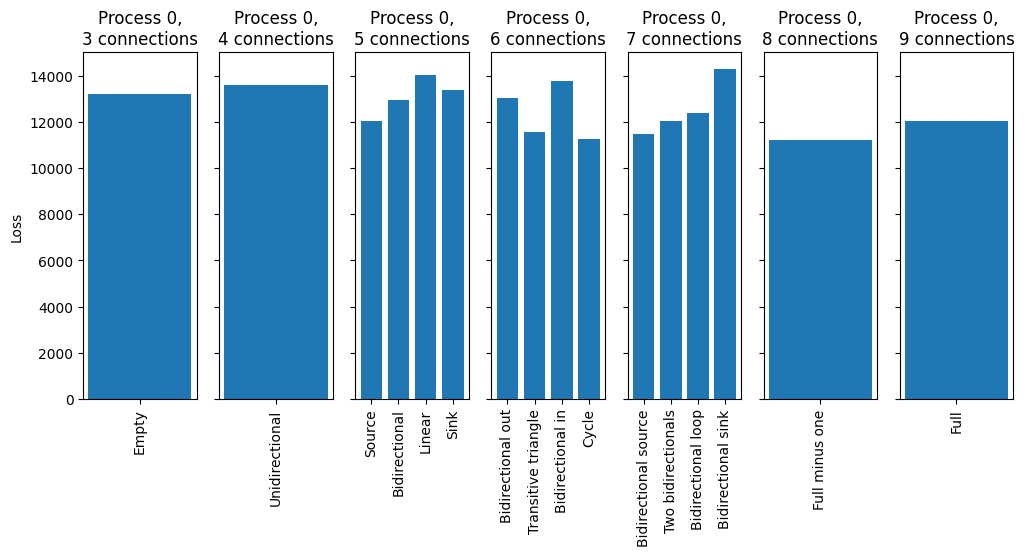

[{3: {'Empty': 13190.999260498887},
  4: {'Unidirectional': 13593.429910020746},
  5: {'Source': 12030.523374165681,
   'Bidirectional': 12934.426475415015,
   'Linear': 14017.281626400976,
   'Sink': 13391.186706276305},
  6: {'Bidirectional out': 13029.162462023825,
   'Transitive triangle': 11558.381847775658,
   'Bidirectional in': 13769.783533965465,
   'Cycle': 11277.478749758688},
  7: {'Bidirectional source': 11464.375782540565,
   'Two bidirectionals': 12045.17229363214,
   'Bidirectional loop': 12376.355800868538,
   'Bidirectional sink': 14292.357440804315},
  8: {'Full minus one': 11201.278333967808},
  9: {'Full': 12044.349541091618}}]

In [30]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(20, 5e-7), np.full(20, 1e-7), np.full(20, 5e-8), np.full(20, 1e-8))),
          envals=np.array([0.6, 0.85, 0.95]))

Process dynamics: [[ 0.6  0.8  0. ]
 [-0.8  0.6  0. ]
 [ 0.   0.   0.9]]
Eigenvalues: [0.6+0.8j 0.6-0.8j 0.9+0.j ]
Kalman filter M: [[ 0.36576708  0.48768944  0.        ]
 [-0.48768944  0.36576708  0.        ]
 [ 0.          0.          0.58788979]]
Kalman filter K: [[ 3.90388203e-01 -7.85824477e-18  0.00000000e+00]
 [ 1.17873672e-17  3.90388203e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.46789125e-01]]
Kalman filter loss: 8287.234989271892


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.32454536  0.          0.        ]
 [-0.          0.38394316  0.        ]
 [ 0.          0.          0.43393823]]
NN K: [[ 7.85489942e-01  2.53878598e-01  3.66612645e-03]
 [-2.97467241e-01  7.52666530e-01 -1.82521112e-03]
 [ 1.14158882e-03 -5.38975970e-04  4.60653269e-01]]
Testing Empty, Trial 2
NN M: [[0.35725005 0.         0.        ]
 [0.         0.40226571 0.        ]
 [0.         0.         0.46974705]]
NN K: [[ 0.7655511   0.27783412  0.00082038]
 [-0.31507833  0.73829067  0.00129374]
 [ 0.00140345  0.00078961  0.43730007]]
Testing Empty, Trial 3


  6%|███▎                                                 | 1/16 [14:00<3:30:12, 840.86s/it]

NN M: [[0.38347082 0.         0.        ]
 [0.         0.4132984  0.        ]
 [0.         0.         0.48620737]]
NN K: [[ 7.51710473e-01  2.95894451e-01  5.28792026e-04]
 [-3.22861580e-01  7.30866380e-01 -2.54192220e-03]
 [ 1.95022689e-03  8.15750227e-05  4.26424021e-01]]
Testing Unidirectional, Trial 1
NN M: [[ 0.30992561  0.          0.        ]
 [-0.32096175  0.2957418   0.        ]
 [ 0.          0.          0.42152234]]
NN K: [[ 7.92812286e-01  2.42218618e-01  2.12733379e-03]
 [-4.45373458e-02  5.61855749e-01 -1.99879045e-03]
 [ 1.39789798e-03 -6.35058007e-04  4.69237484e-01]]
Testing Unidirectional, Trial 2
NN M: [[ 0.30204099  0.          0.        ]
 [-0.33977533  0.31670628  0.        ]
 [ 0.          0.          0.40785876]]
NN K: [[ 0.80239525  0.23458541 -0.00337323]
 [-0.0490903   0.53960651  0.0017108 ]
 [ 0.00176725 -0.00262993  0.47667683]]
Testing Unidirectional, Trial 3


 12%|██████▋                                              | 2/16 [28:32<3:20:24, 858.92s/it]

NN M: [[ 0.27986285  0.          0.        ]
 [-0.37651351  0.23705483  0.        ]
 [ 0.          0.          0.3603051 ]]
NN K: [[ 8.15613926e-01  2.11455400e-01  2.40464919e-03]
 [ 3.47113388e-02  5.57816884e-01  1.94685412e-03]
 [ 5.60616541e-04 -1.52326913e-03  5.06418872e-01]]
Testing Source, Trial 1
NN M: [[ 0.32293678  0.          0.        ]
 [-0.2660378   0.40912675  0.        ]
 [ 0.02443084  0.          0.15319823]]
NN K: [[ 0.79018345  0.24979458  0.00632345]
 [-0.16079891  0.54122175  0.00286688]
 [-0.01200044  0.01739162  0.58159346]]
Testing Source, Trial 2
NN M: [[ 0.17046917  0.          0.        ]
 [-0.38493819  0.24204084  0.        ]
 [ 0.02568616  0.          0.28102573]]
NN K: [[ 8.78875452e-01  1.25375088e-01  1.50250223e-03]
 [ 3.41853468e-02  5.45152674e-01  4.88572739e-04]
 [-1.35117418e-02  1.97421546e-02  5.42793190e-01]]
Testing Source, Trial 3


 19%|█████████▉                                           | 3/16 [43:37<3:10:42, 880.17s/it]

NN M: [[ 0.38024004  0.          0.        ]
 [-0.30803109  0.4089365   0.        ]
 [-0.00277413  0.          0.26097437]]
NN K: [[ 0.74817178  0.30058579  0.00258905]
 [-0.14190618  0.50618933 -0.00088323]
 [ 0.00415971 -0.00332431  0.55695178]]
Testing Bidirectional, Trial 1
NN M: [[ 0.28776809  0.24085126  0.        ]
 [-0.30903365  0.15108045  0.        ]
 [ 0.          0.          0.36036823]]
NN K: [[ 6.30402967e-01  7.89467743e-02  5.56259261e-04]
 [ 6.70757474e-02  6.57859536e-01 -6.42105640e-04]
 [ 2.47296776e-03 -2.62382541e-03  5.07223025e-01]]
Testing Bidirectional, Trial 2
NN M: [[ 0.4076779   0.33180784  0.        ]
 [-0.27706939  0.42472939  0.        ]
 [ 0.          0.          0.42574598]]
NN K: [[ 4.85895617e-01  1.29503648e-01  1.32775757e-03]
 [-1.75554736e-01  5.19373011e-01 -1.84533753e-03]
 [ 1.19117562e-03  5.97214486e-05  4.64584039e-01]]
Testing Bidirectional, Trial 3


 25%|█████████████▎                                       | 4/16 [57:07<2:50:27, 852.30s/it]

NN M: [[ 0.33075075  0.32174327  0.        ]
 [-0.11132401  0.47440162  0.        ]
 [ 0.          0.          0.44054363]]
NN K: [[ 0.54264756  0.06625457  0.0023126 ]
 [-0.31009852  0.61543749  0.00090496]
 [ 0.00252281 -0.00116021  0.45245971]]
Testing Linear, Trial 1
NN M: [[ 0.35927537  0.          0.        ]
 [-0.20234528  0.42716654  0.        ]
 [ 0.          0.00390782  0.20596782]]
NN K: [[ 7.63610244e-01  2.84235739e-01 -9.62474691e-05]
 [-2.19462385e-01  5.76089612e-01 -1.03996909e-03]
 [ 1.09016566e-04 -2.30519930e-03  5.75060353e-01]]
Testing Linear, Trial 2
NN M: [[ 0.42047817  0.          0.        ]
 [-0.24289983  0.36624444  0.        ]
 [ 0.          0.03164084  0.26733301]]
NN K: [[ 0.73014824  0.32620621  0.00202196]
 [-0.14462785  0.58264844  0.00193443]
 [-0.02210765 -0.01857891  0.55170782]]
Testing Linear, Trial 3


 31%|███████████████▉                                   | 5/16 [1:09:43<2:29:52, 817.49s/it]

NN M: [[ 0.40253999  0.          0.        ]
 [-0.28228204  0.23427557  0.        ]
 [ 0.          0.03907196  0.22472211]]
NN K: [[ 0.73722214  0.31709225  0.00096068]
 [-0.02064983  0.63048119  0.00193907]
 [-0.03018828 -0.02599058  0.56874648]]
Testing Sink, Trial 1
NN M: [[ 0.17063264  0.          0.        ]
 [-0.36269717  0.33136441 -0.03540672]
 [ 0.          0.          0.32672688]]
NN K: [[ 8.79514288e-01  1.27134141e-01 -4.48985437e-03]
 [-4.81134187e-02  5.09565868e-01  1.95109337e-02]
 [ 1.24496286e-03 -6.01885691e-04  5.23173459e-01]]
Testing Sink, Trial 2
NN M: [[ 0.45692615  0.          0.        ]
 [-0.24498786  0.38186223  0.27753652]
 [ 0.          0.         -0.07384763]]
NN K: [[ 0.70357651  0.36076639  0.00690337]
 [-0.16085721  0.57023303 -0.1273907 ]
 [ 0.00217954 -0.00236898  0.56875609]]
Testing Sink, Trial 3


 38%|███████████████████▏                               | 6/16 [1:22:12<2:12:22, 794.26s/it]

NN M: [[ 0.35101576  0.          0.        ]
 [-0.29127041  0.31570025 -0.11256931]
 [ 0.          0.          0.33383604]]
NN K: [[ 7.73537990e-01  2.79761220e-01 -8.96448315e-03]
 [-8.02776124e-02  5.75785330e-01  6.71889147e-02]
 [ 2.14682831e-03  4.79015886e-05  5.08675842e-01]]
Testing Bidirectional out, Trial 1
NN M: [[-0.00426769  0.35859431  0.        ]
 [-0.32719943  0.35311218  0.        ]
 [-0.02919728  0.          0.24386508]]
NN K: [[ 0.71003348 -0.21439833 -0.00605978]
 [-0.07969419  0.52418432 -0.00342652]
 [ 0.01744519 -0.02224608  0.55613878]]
Testing Bidirectional out, Trial 2
NN M: [[ 0.42304145  0.24748635  0.        ]
 [-0.13686169  0.43376739  0.        ]
 [-0.06763552  0.          0.0698723 ]]
NN K: [[ 0.5414812   0.1899125  -0.01402505]
 [-0.26723553  0.62417184 -0.00362723]
 [ 0.04092653 -0.05240741  0.59116408]]
Testing Bidirectional out, Trial 3


 44%|██████████████████████▎                            | 7/16 [1:34:40<1:56:52, 779.16s/it]

NN M: [[ 0.04155219  0.41384862  0.        ]
 [-0.41783822  0.21549174  0.        ]
 [-0.02074231  0.          0.209922  ]]
NN K: [[ 0.63838026 -0.21040356 -0.00575428]
 [ 0.08013663  0.53471902 -0.0071234 ]
 [ 0.01367997 -0.01783717  0.57094258]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.26779103  0.          0.        ]
 [-0.31328533  0.3870506   0.        ]
 [ 0.06438613  0.00252638  0.04090847]]
NN K: [[ 0.82349995  0.20646451  0.01777273]
 [-0.12159982  0.5134667   0.00373299]
 [-0.03579483  0.04960748  0.60421391]]
Testing Transitive triangle, Trial 2
NN M: [[-0.02552729  0.          0.        ]
 [-0.30924802  0.36273863  0.        ]
 [-0.03459354 -0.0238359   0.13079639]]
NN K: [[ 0.99110372 -0.02855448 -0.00876642]
 [-0.10633395  0.53218706 -0.00842888]
 [ 0.0408388  -0.0137049   0.59448076]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████▌                         | 8/16 [1:47:06<1:42:29, 768.63s/it]

NN M: [[ 0.42952786  0.          0.        ]
 [-0.30963437  0.21584482  0.        ]
 [-0.00812216 -0.0085993   0.13851884]]
NN K: [[ 7.22576237e-01  3.33672605e-01 -2.14205112e-04]
 [ 1.44177325e-02  6.18447299e-01 -3.28365199e-03]
 [ 1.19146937e-02 -3.77871074e-03  5.88662803e-01]]
Testing Bidirectional in, Trial 1
NN M: [[ 0.14633335  0.49443681  0.2760395 ]
 [-0.36962276  0.3330235   0.        ]
 [ 0.          0.         -0.34663001]]
NN K: [[ 0.52129986 -0.17980179 -0.06925627]
 [-0.03240225  0.50907736 -0.0226924 ]
 [ 0.0086431  -0.00545351  0.4778195 ]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.23545156  0.29916228 -0.02090339]
 [-0.28666626  0.52220211  0.        ]
 [ 0.          0.          0.43382727]]
NN K: [[ 0.60963589  0.01060626  0.01739594]
 [-0.24002946  0.44571866  0.00277989]
 [ 0.00121363  0.00200272  0.46297195]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▋                      | 9/16 [1:59:35<1:28:56, 762.41s/it]

NN M: [[ 0.29840035  0.43304414  0.05837171]
 [-0.35500899  0.15470047  0.        ]
 [ 0.          0.          0.26581817]]
NN K: [[ 4.70240466e-01 -2.91423153e-02 -2.89966953e-02]
 [ 9.28094964e-02  6.13240803e-01 -2.03023568e-02]
 [ 1.44026386e-03 -8.07109489e-05  5.41622555e-01]]
Testing Cycle, Trial 1
NN M: [[ 0.39224908  0.          0.09202199]
 [-0.27818952  0.31446968  0.        ]
 [ 0.          0.06753652 -0.21582483]]
NN K: [[ 0.74755209  0.3064444  -0.03081191]
 [-0.0867872   0.588703    0.02491124]
 [-0.0470283  -0.03930325  0.55299191]]
Testing Cycle, Trial 2
NN M: [[ 0.21066912  0.         -0.43446259]
 [-0.42077657  0.08071154  0.        ]
 [ 0.          0.14075823  0.18822651]]
NN K: [[ 0.85101269  0.15647433  0.17991988]
 [ 0.17842373  0.6138241   0.01496339]
 [-0.10685157 -0.09934649  0.46509834]]
Testing Cycle, Trial 3


 62%|███████████████████████████████▎                  | 10/16 [2:12:00<1:15:41, 756.97s/it]

NN M: [[ 0.42565849  0.          0.07778701]
 [-0.29207558  0.32573966  0.        ]
 [ 0.         -0.00156222  0.16501663]]
NN K: [[ 0.72820558  0.3309209  -0.04171965]
 [-0.08515165  0.571013    0.00106932]
 [ 0.00443474  0.00298654  0.5812629 ]]
Testing Bidirectional source, Trial 1
NN M: [[ 3.44591702e-01  2.13132321e-01  0.00000000e+00]
 [-2.67651163e-01  3.44608722e-01  0.00000000e+00]
 [-9.58152006e-03 -4.46257283e-02  1.32583530e-04]]
NN K: [[ 6.15476911e-01  1.43901095e-01 -3.72074261e-04]
 [-1.10437204e-01  5.76201728e-01 -1.29306324e-02]
 [ 4.31853350e-02  1.55305860e-02  5.97721167e-01]]
Testing Bidirectional source, Trial 2
NN M: [[ 0.33300425  0.29291431  0.        ]
 [-0.40645453  0.21911251  0.        ]
 [-0.02043723  0.01937261  0.1290616 ]]
NN K: [[ 0.55984637  0.08588058 -0.0068812 ]
 [ 0.07038863  0.54256684 -0.00146869]
 [ 0.00205325 -0.03035385  0.59158431]]
Testing Bidirectional source, Trial 3


 69%|██████████████████████████████████▍               | 11/16 [2:24:22<1:02:42, 752.56s/it]

NN M: [[ 0.21556443  0.32022942  0.        ]
 [-0.44483414  0.45085297  0.        ]
 [ 0.03570102 -0.02076249 -0.00687178]]
NN K: [[ 0.60054672 -0.01749855  0.01509072]
 [-0.08770398  0.36680213 -0.00280099]
 [-0.00327308  0.03746233  0.59992192]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.48705201  0.20517576  0.13213794]
 [-0.18322     0.46138226  0.        ]
 [ 0.01537551  0.          0.15373021]]
NN K: [[ 0.53891993  0.26216183 -0.0836125 ]
 [-0.2549291   0.57031051 -0.00921366]
 [-0.01001747  0.01036463  0.57713997]]
Testing Two bidirectionals, Trial 2
NN M: [[ 4.63470597e-01  1.10560570e-01 -6.72260328e-02]
 [-3.06951859e-01  2.91031911e-01  0.00000000e+00]
 [-3.05046886e-04  0.00000000e+00  1.34726335e-01]]
NN K: [[ 6.21909642e-01  3.01364739e-01  4.70791042e-02]
 [-4.86826812e-02  5.73287303e-01 -4.51234190e-04]
 [ 1.92211747e-03  6.53487829e-05  5.94830032e-01]]
Testing Two bidirectionals, Trial 3


 75%|███████████████████████████████████████             | 12/16 [2:36:48<50:02, 750.59s/it]

NN M: [[ 0.37034082  0.32265318 -0.30120787]
 [-0.1759443   0.4465167   0.        ]
 [-0.00332576  0.         -0.49268004]]
NN K: [[ 0.51678616  0.10070673  0.0680951 ]
 [-0.25141926  0.58371681  0.00733476]
 [ 0.00698516 -0.01221381  0.41489493]]
Testing Bidirectional loop, Trial 1
NN M: [[ 0.5194987   0.37216623  0.        ]
 [-0.45558246  0.11511596 -0.04345377]
 [-0.01323036  0.         -0.07522786]]
NN K: [[ 0.38993502  0.18149563  0.00170536]
 [ 0.17514469  0.56700842  0.00136404]
 [ 0.00995332 -0.014476    0.59152542]]
Testing Bidirectional loop, Trial 2
NN M: [[ 0.39109039  0.34120452  0.        ]
 [-0.42462411  0.27771657 -0.3730069 ]
 [-0.20878726  0.         -0.12413896]]
NN K: [[ 0.48540589  0.10416494 -0.0617418 ]
 [ 0.03215146  0.48643216  0.10453076]
 [ 0.12114717 -0.16364582  0.52299533]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [2:49:15<37:28, 749.58s/it]

NN M: [[ 0.44447165  0.38440891  0.        ]
 [-0.33274433  0.24318489  0.02740017]
 [ 0.01959104  0.          0.20083942]]
NN K: [[ 0.4198466   0.12055745  0.00558581]
 [ 0.00271444  0.58029932 -0.01122241]
 [-0.00934946  0.01565693  0.56936197]]
Testing Bidirectional sink, Trial 1
NN M: [[ 0.36546891  0.          0.        ]
 [-0.33008953  0.21445694  0.09245527]
 [-0.07558855  0.07844424 -0.0903481 ]]
NN K: [[ 0.76503924  0.28311508 -0.00748312]
 [ 0.02567893  0.6065531  -0.01459317]
 [-0.01693149 -0.10328912  0.57946592]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.19854101  0.          0.        ]
 [-0.3949732   0.25269892 -0.08815426]
 [ 0.03773     0.02849601  0.0122504 ]]
NN K: [[ 0.8587752   0.14824402 -0.00324802]
 [ 0.0320158   0.52868173  0.04086554]
 [-0.03978747  0.00968751  0.58510115]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [3:01:42<24:57, 748.57s/it]

NN M: [[ 0.29115272  0.          0.        ]
 [-0.3865499   0.28071784  0.09507556]
 [-0.0201842  -0.03136744 -0.07538136]]
NN K: [[ 8.11760051e-01  2.24094457e-01  4.30649889e-03]
 [ 1.86861462e-03  5.22560551e-01 -5.01028568e-02]
 [ 4.15684278e-02 -7.30367072e-04  5.83352124e-01]]
Testing Full minus one, Trial 1
NN M: [[ 0.39092693  0.39048821  0.15073064]
 [-0.2820313   0.51806033  0.        ]
 [ 0.03505067 -0.17100774 -0.02771162]]
NN K: [[ 0.43253964  0.06063949 -0.03921002]
 [-0.21819355  0.43921058 -0.03334919]
 [ 0.11368926  0.12375679  0.58467398]]
Testing Full minus one, Trial 2
NN M: [[ 0.46450211  0.41702126  0.0653799 ]
 [-0.24559105  0.47910143  0.        ]
 [ 0.04687688 -0.07002393  0.05139977]]
NN K: [[ 0.38457506  0.12389742 -0.01609062]
 [-0.23817185  0.50768932 -0.01530537]
 [ 0.03024011  0.07712014  0.58995801]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [3:14:06<12:27, 747.19s/it]

NN M: [[ 0.35404409  0.25413457 -0.00486899]
 [-0.1508269   0.35932663  0.        ]
 [ 0.03783835  0.01256443 -0.13746437]]
NN K: [[ 0.57922502  0.13076189  0.01326207]
 [-0.19779284  0.65960685  0.00137585]
 [-0.03262957  0.02037616  0.58445716]]
Testing Full, Trial 1
NN M: [[ 0.22685145  0.20586051  0.07105149]
 [-0.32690849  0.33009133 -0.10288561]
 [-0.05561103 -0.05672999  0.11731974]]
NN K: [[ 0.69661443  0.05209028 -0.053507  ]
 [-0.06194604  0.54051615  0.0446773 ]
 [ 0.08298037 -0.01133183  0.57160388]]
Testing Full, Trial 2
NN M: [[ 0.35028602  0.35685131  0.13713085]
 [-0.28170491  0.21094165  0.04891051]
 [ 0.1210141  -0.12152463 -0.05471993]]
NN K: [[ 0.49764143  0.06663496 -0.01073394]
 [-0.00124498  0.64167272 -0.05315962]
 [ 0.02478295  0.16115047  0.56702202]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 16/16 [3:26:26<00:00, 774.19s/it]

NN M: [[ 0.1584613   0.33320398  0.01880776]
 [-0.42607697  0.09895495  0.07819051]
 [ 0.09672315  0.03957545 -0.11274297]]
NN K: [[ 0.6325595  -0.06908501  0.01854143]
 [ 0.17103044  0.5977619  -0.00841968]
 [-0.08194511  0.05028946  0.57100713]]


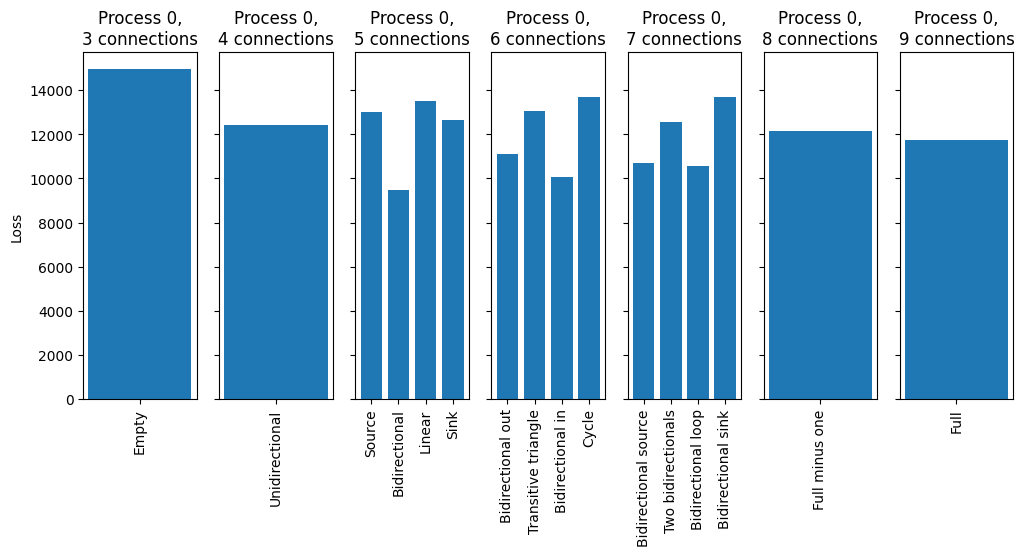

[{3: {'Empty': 14968.617822233158},
  4: {'Unidirectional': 12407.134044067585},
  5: {'Source': 13019.955986357454,
   'Bidirectional': 9482.045774890204,
   'Linear': 13513.418114386814,
   'Sink': 12658.233621732556},
  6: {'Bidirectional out': 11127.881819870216,
   'Transitive triangle': 13044.12219742638,
   'Bidirectional in': 10080.099198610285,
   'Cycle': 13712.086368261364},
  7: {'Bidirectional source': 10690.391401050229,
   'Two bidirectionals': 12553.14024127566,
   'Bidirectional loop': 10552.852688134983,
   'Bidirectional sink': 13715.818204483236},
  8: {'Full minus one': 12171.890314404518},
  9: {'Full': 11763.47889847781}}]

In [32]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(20, 1e-5), np.full(20, 1e-6), np.full(30, 5e-7))),
           A=np.array([[0.6, 0.8, 0],[-0.8, 0.6, 0], [0, 0, 0.9]]))

Process dynamics: [[ 0.8  0.   0. ]
 [ 0.8  0.8  0. ]
 [ 0.8 -0.8  0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.45382871 -0.03070741 -0.04706014]
 [ 0.3951711   0.4224923   0.02522317]
 [ 0.37894418 -0.37555797  0.40078115]]
Kalman filter K: [[ 0.27667951  0.09720943  0.05882517]
 [ 0.09720943  0.44035566 -0.03152897]
 [ 0.05882517 -0.03152897  0.49902357]]
Kalman filter loss: 8951.160388795484


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.00211189 0.         0.        ]
 [0.         0.20847128 0.        ]
 [0.         0.         0.4205506 ]]
NN K: [[ 0.22873156  0.16312063  0.0196696 ]
 [ 0.10586376  0.6770826  -0.01695179]
 [ 0.04580277 -0.10289239  0.4263012 ]]
Testing Empty, Trial 2
NN M: [[-0.01405618  0.          0.        ]
 [ 0.          0.17260113  0.        ]
 [ 0.          0.          0.33761747]]
NN K: [[ 0.13249211  0.19446723  0.02328377]
 [ 0.19530419  0.66311106 -0.02611857]
 [ 0.15229696 -0.26261165  0.57824327]]
Testing Empty, Trial 3


  6%|███▎                                                | 1/16 [23:52<5:58:13, 1432.88s/it]

NN M: [[0.0017837  0.         0.        ]
 [0.         0.23776395 0.        ]
 [0.         0.         0.32904727]]
NN K: [[ 0.22554898  0.16338455  0.02049481]
 [ 0.18517017  0.64227018 -0.01286472]
 [ 0.06496091 -0.15774976  0.62864078]]
Testing Unidirectional, Trial 1
NN M: [[-0.05672017  0.          0.        ]
 [ 0.1425637   0.16633806  0.        ]
 [ 0.          0.          0.34550733]]
NN K: [[ 0.24095622  0.18702205  0.02437647]
 [ 0.11568541  0.66788782 -0.0242418 ]
 [ 0.13011723 -0.25916125  0.5978354 ]]
Testing Unidirectional, Trial 2
NN M: [[-0.06583204  0.          0.        ]
 [ 0.10241827  0.21907038  0.        ]
 [ 0.          0.          0.41780554]]
NN K: [[ 0.21858236  0.18522085  0.02275826]
 [ 0.16600435  0.63881197 -0.01659278]
 [ 0.05251502 -0.18212443  0.59999988]]
Testing Unidirectional, Trial 3


 12%|██████▌                                             | 2/16 [40:15<4:32:28, 1167.78s/it]

NN M: [[0.03574716 0.         0.        ]
 [0.09130904 0.23287835 0.        ]
 [0.         0.         0.32724935]]
NN K: [[ 0.23799347  0.16476303  0.02205724]
 [ 0.16026071  0.63867178 -0.01442362]
 [ 0.14809737 -0.27912942  0.6039595 ]]
Testing Source, Trial 1
NN M: [[-0.11216956  0.          0.        ]
 [ 0.14361241  0.18263878  0.        ]
 [ 0.04665355  0.          0.33897463]]
NN K: [[ 0.23847272  0.18708921  0.02385977]
 [ 0.1091966   0.66530707 -0.01977118]
 [ 0.15970743 -0.25719864  0.60626956]]
Testing Source, Trial 2
NN M: [[-0.12799716  0.          0.        ]
 [ 0.15584376  0.14183339  0.        ]
 [-0.01066991  0.          0.44753738]]
NN K: [[ 0.2236771   0.20684836  0.02747563]
 [ 0.20635228  0.64903932 -0.0297138 ]
 [ 0.08455231 -0.2726649   0.55191393]]
Testing Source, Trial 3


 19%|█████████▊                                          | 3/16 [56:32<3:54:11, 1080.88s/it]

NN M: [[-0.27381162  0.          0.        ]
 [ 0.15737713  0.18853612  0.        ]
 [ 0.3143062   0.          0.34535469]]
NN K: [[ 0.18181222  0.29086463  0.0424682 ]
 [ 0.1768957   0.63504837 -0.02336395]
 [ 0.10526113 -0.31903455  0.60355489]]
Testing Bidirectional, Trial 1
NN M: [[0.00389585 0.07298127 0.        ]
 [0.04449035 0.20290979 0.        ]
 [0.         0.         0.3431983 ]]
NN K: [[ 0.20471767  0.13302296  0.03036189]
 [ 0.22511971  0.63891976 -0.01911937]
 [ 0.0976954  -0.21874355  0.61531159]]
Testing Bidirectional, Trial 2
NN M: [[-0.04912309  0.08080759  0.        ]
 [ 0.0580869   0.22954831  0.        ]
 [ 0.          0.          0.32876251]]
NN K: [[ 0.1309243   0.16766673  0.0360398 ]
 [ 0.15851605  0.64524847 -0.01423391]
 [ 0.18002772 -0.27671698  0.57404204]]
Testing Bidirectional, Trial 3


 25%|████████████▌                                     | 4/16 [1:11:20<3:20:57, 1004.81s/it]

NN M: [[0.06014    0.03654171 0.        ]
 [0.15821359 0.22039226 0.        ]
 [0.         0.         0.39262348]]
NN K: [[ 0.23988658  0.14970881  0.02770173]
 [ 0.16432329  0.62574564 -0.01650317]
 [ 0.14441182 -0.1931384   0.42584674]]
Testing Linear, Trial 1
NN M: [[-0.03072599  0.          0.        ]
 [ 0.10172    -0.19755863  0.        ]
 [ 0.         -0.21345946  0.4617285 ]]
NN K: [[ 0.17401411  0.19453927  0.0246411 ]
 [ 0.11078957  0.6313663  -0.12658935]
 [ 0.22080988 -0.24634514  0.50941366]]
Testing Linear, Trial 2
NN M: [[-0.13516091  0.          0.        ]
 [ 0.04506702 -0.10740252  0.        ]
 [ 0.         -0.29624867  0.34390817]]
NN K: [[ 0.09580779  0.20392635  0.02249724]
 [ 0.14802003  0.63396407 -0.10360864]
 [ 0.18596823 -0.1643841   0.59603236]]
Testing Linear, Trial 3


 31%|███████████████▋                                  | 5/16 [1:33:13<3:24:34, 1115.87s/it]

NN M: [[-0.02944951  0.          0.        ]
 [ 0.10532384  0.08552883  0.        ]
 [ 0.         -0.09156189  0.31767377]]
NN K: [[ 0.20284402  0.18695777  0.02463706]
 [ 0.14898264  0.67690552 -0.03829487]
 [ 0.11471026 -0.18335793  0.60786314]]
Testing Sink, Trial 1
NN M: [[-0.05216913  0.          0.        ]
 [ 0.23078352  0.09087094  0.02908102]
 [ 0.          0.          0.32997242]]
NN K: [[ 0.24201177  0.21341558  0.02845081]
 [ 0.13050477  0.66432444 -0.06865694]
 [ 0.09031332 -0.2049508   0.62018539]]
Testing Sink, Trial 2
NN M: [[-0.13286632  0.          0.        ]
 [ 0.00938667  0.00493455  0.01980309]
 [ 0.          0.          0.50392816]]
NN K: [[ 0.201427    0.16230041  0.01727266]
 [ 0.21392315  0.68966188 -0.07281999]
 [ 0.21790357 -0.36829378  0.47777286]]
Testing Sink, Trial 3


 38%|██████████████████▊                               | 6/16 [1:59:57<3:33:38, 1281.80s/it]

NN M: [[-0.06850503  0.          0.        ]
 [ 0.1409078   0.05186856  0.04796708]
 [ 0.          0.          0.33928024]]
NN K: [[ 0.28005572  0.17648682  0.02092562]
 [ 0.15407143  0.69870707 -0.09255058]
 [ 0.16520264 -0.25003257  0.58998257]]
Testing Bidirectional out, Trial 1
NN M: [[-0.05439134  0.13804768  0.        ]
 [ 0.07514953  0.08619666  0.        ]
 [ 0.05872666  0.          0.3292053 ]]
NN K: [[ 0.28506362  0.1078591   0.03850624]
 [ 0.18855762  0.68266781 -0.03938879]
 [ 0.12009399 -0.25562552  0.60292684]]
Testing Bidirectional out, Trial 2
NN M: [[-0.06584003  0.11021621  0.        ]
 [-0.06467501  0.1592431   0.        ]
 [ 0.02595126  0.          0.37749165]]
NN K: [[ 0.21873429  0.09849142  0.02817545]
 [ 0.10533941  0.70542673 -0.0206095 ]
 [ 0.16229507 -0.3166331   0.4206112 ]]
Testing Bidirectional out, Trial 3


 44%|█████████████████████▉                            | 7/16 [2:26:26<3:27:20, 1382.23s/it]

NN M: [[-0.26947253  0.09275527  0.        ]
 [-0.00069289  0.11647041  0.        ]
 [ 0.14811616  0.          0.32544057]]
NN K: [[ 0.23928103  0.18775423  0.04008718]
 [ 0.17555365  0.69000909 -0.0322609 ]
 [ 0.15282771 -0.32852064  0.52535749]]
Testing Transitive triangle, Trial 1
NN M: [[-0.04586857  0.          0.        ]
 [ 0.18828802 -0.0491009   0.        ]
 [ 0.15779557 -0.28933317  0.32279641]]
NN K: [[ 0.2846044   0.21806858  0.03144053]
 [ 0.12471253  0.60328299 -0.0798826 ]
 [ 0.20070374 -0.18485871  0.55028972]]
Testing Transitive triangle, Trial 2
NN M: [[-0.19316117  0.          0.        ]
 [ 0.22623366 -0.13721635  0.        ]
 [ 0.19438985 -0.37206634  0.44578594]]
NN K: [[ 0.20530717  0.25340781  0.05082878]
 [ 0.09404842  0.58741436 -0.14089845]
 [ 0.21632418 -0.25072991  0.48520703]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████                         | 8/16 [2:53:38<3:14:53, 1461.67s/it]

NN M: [[-0.1207507   0.          0.        ]
 [ 0.0744412  -0.14199016  0.        ]
 [-0.04540471  0.10495564  0.39092128]]
NN K: [[ 0.17500357  0.20759938  0.03057088]
 [ 0.13288841  0.663879   -0.09728642]
 [ 0.02646231 -0.15961659  0.45888565]]
Testing Bidirectional in, Trial 1
NN M: [[-0.21257424  0.05391383  0.00417379]
 [ 0.12744075  0.23323071  0.        ]
 [ 0.          0.          0.34804311]]
NN K: [[ 0.2303029   0.16405159  0.02599243]
 [ 0.10023406  0.64797835 -0.01284032]
 [ 0.19652855 -0.2955331   0.5959438 ]]
Testing Bidirectional in, Trial 2
NN M: [[-0.19811295  0.05350018 -0.00192777]
 [-0.02525396  0.23402222  0.        ]
 [ 0.          0.          0.32519266]]
NN K: [[ 0.17589774  0.17709093  0.02880946]
 [ 0.18230989  0.65016174 -0.0133784 ]
 [ 0.12870752 -0.2906439   0.55959564]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▏                     | 9/16 [3:18:31<2:51:40, 1471.48s/it]

NN M: [[-0.14556293  0.06486961 -0.00270694]
 [ 0.11172168  0.20429706  0.        ]
 [ 0.          0.          0.33671784]]
NN K: [[ 0.22867113  0.16398232  0.03630895]
 [ 0.16726695  0.64675633 -0.0177129 ]
 [ 0.15550226 -0.25596183  0.59662215]]
Testing Cycle, Trial 1
NN M: [[-0.15460226  0.          0.05634147]
 [ 0.15786862 -0.17213413  0.        ]
 [ 0.         -0.48684827  0.30566651]]
NN K: [[ 0.17089976  0.22410163 -0.03303302]
 [ 0.07360849  0.54110895 -0.13069483]
 [ 0.19804995 -0.14283689  0.56292257]]
Testing Cycle, Trial 2
NN M: [[-0.15138203  0.         -0.02810669]
 [-0.04585867 -0.04626384  0.        ]
 [ 0.         -0.2731615   0.31984439]]
NN K: [[ 0.17823842  0.16430498  0.04690926]
 [ 0.12621354  0.64745716 -0.07377133]
 [ 0.19342318 -0.15367887  0.56698136]]
Testing Cycle, Trial 3


 62%|██████████████████████████████▋                  | 10/16 [3:34:43<2:11:44, 1317.35s/it]

NN M: [[-0.13786986  0.         -0.03682773]
 [-0.04302707  0.00046894  0.        ]
 [ 0.         -0.27740671  0.31967922]]
NN K: [[ 0.23352162  0.1600734   0.05543157]
 [ 0.1265687   0.63594222 -0.06851714]
 [ 0.17621401 -0.13074527  0.5765178 ]]
Testing Bidirectional source, Trial 1
NN M: [[-0.31023305 -0.04881351  0.        ]
 [ 0.13166437 -0.14065987  0.        ]
 [-0.17265887 -0.29787202  0.26980935]]
NN K: [[ 0.17065023  0.17609311  0.00516484]
 [ 0.07203266  0.63097583 -0.09784052]
 [ 0.14280434 -0.0882871   0.62913004]]
Testing Bidirectional source, Trial 2
NN M: [[-0.07690264  0.13211613  0.        ]
 [ 0.19610891  0.15241998  0.        ]
 [-0.00051035 -0.04561725  0.50020458]]
NN K: [[ 0.21902214  0.15923091  0.04639554]
 [ 0.2281738   0.61429311 -0.03350214]
 [ 0.20317263 -0.27985101  0.49864147]]
Testing Bidirectional source, Trial 3


 69%|█████████████████████████████████▋               | 11/16 [3:51:41<1:42:08, 1225.72s/it]

NN M: [[-0.20358755  0.25076076  0.        ]
 [ 0.31260298 -0.15988202  0.        ]
 [ 0.22192432 -0.32627533  0.43671179]]
NN K: [[ 0.22967656  0.23758513  0.10281985]
 [ 0.13375915  0.58084624 -0.13445503]
 [ 0.18503113 -0.2872439   0.48882921]]
Testing Two bidirectionals, Trial 1
NN M: [[-0.3293081   0.1069258  -0.08605821]
 [ 0.03973625  0.19925628  0.        ]
 [ 0.11845055  0.          0.3495911 ]]
NN K: [[ 0.16208165  0.21323845  0.13564529]
 [ 0.15032048  0.66323721 -0.01793002]
 [ 0.11201803 -0.28484328  0.58385898]]
Testing Two bidirectionals, Trial 2
NN M: [[-0.22717236  0.0424621  -0.06017983]
 [ 0.07485499  0.0461928   0.        ]
 [ 0.09456424  0.          0.3575382 ]]
NN K: [[ 0.19168937  0.18790299  0.09197319]
 [ 0.22095534  0.69099933 -0.04542622]
 [ 0.15039368 -0.29686629  0.58944015]]
Testing Two bidirectionals, Trial 3


 75%|████████████████████████████████████▊            | 12/16 [4:09:03<1:17:59, 1169.97s/it]

NN M: [[-0.49422587  0.31031067 -0.08525094]
 [-0.09887618  0.18087582  0.        ]
 [ 0.17614128  0.          0.32616062]]
NN K: [[ 0.12439377  0.19289642  0.16840677]
 [ 0.21005003  0.6712382  -0.02213144]
 [ 0.15426372 -0.27214244  0.60918005]]
Testing Bidirectional loop, Trial 1
NN M: [[-0.17607633  0.08917489  0.        ]
 [ 0.02057925  0.08054423  0.04469873]
 [-0.04287922  0.          0.33738951]]
NN K: [[ 0.18947563  0.13599681  0.02872939]
 [ 0.19718636  0.69863983 -0.08247664]
 [ 0.14449651 -0.2394414   0.60089603]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.110994    0.07054862  0.        ]
 [ 0.05845902  0.01713171  0.04419593]
 [-0.0365586   0.          0.40973794]]
NN K: [[ 0.14693362  0.18103397  0.03846861]
 [ 0.17296068  0.69225086 -0.10821049]
 [ 0.13636569 -0.18077047  0.42119828]]
Testing Bidirectional loop, Trial 3


 81%|█████████████████████████████████████████▍         | 13/16 [4:25:50<56:01, 1120.34s/it]

NN M: [[-0.12761837  0.00252661  0.        ]
 [ 0.14228442  0.0635032   0.05525532]
 [ 0.03759482  0.          0.31895193]]
NN K: [[ 0.25504727  0.1941131   0.0255244 ]
 [ 0.20583385  0.6672015  -0.09751947]
 [ 0.15740292 -0.22987113  0.63490502]]
Testing Bidirectional sink, Trial 1
NN M: [[-0.06108656  0.          0.        ]
 [ 0.20517239 -0.08166742  0.18743639]
 [ 0.06852628 -0.21171822  0.32265023]]
NN K: [[ 0.18745415  0.21945031  0.02813224]
 [ 0.12226687  0.64621584 -0.27549081]
 [ 0.12882318 -0.09991136  0.59942939]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.02982246  0.          0.        ]
 [-0.02935526 -0.05014616  0.01440596]
 [ 0.01519225 -0.03218176  0.39766353]]
NN K: [[ 0.23745031  0.13965279  0.01585416]
 [ 0.18710039  0.73268955 -0.0716641 ]
 [ 0.16513274 -0.3044496   0.59209727]]
Testing Bidirectional sink, Trial 3


 88%|████████████████████████████████████████████▋      | 14/16 [4:41:58<35:49, 1074.54s/it]

NN M: [[-0.12080384  0.          0.        ]
 [-0.32978831 -0.30212909  0.22775523]
 [-0.18410295 -0.44277588  0.38025835]]
NN K: [[ 2.34757271e-01  2.23475382e-04 -1.27976827e-02]
 [ 6.39017628e-02  5.18184494e-01 -3.90869557e-01]
 [ 2.47010078e-01 -1.62451016e-01  4.71192770e-01]]
Testing Full minus one, Trial 1
NN M: [[-0.24569895  0.229788   -0.0542026 ]
 [-0.02944306  0.15279823  0.        ]
 [ 0.07140592 -0.05657756  0.30042771]]
NN K: [[ 0.17478463  0.11748991  0.10909614]
 [ 0.11932449  0.68439307 -0.02261605]
 [ 0.15894528 -0.23932308  0.56684484]]
Testing Full minus one, Trial 2
NN M: [[-0.25688517  0.02918762  0.00962622]
 [-0.01617398 -0.05681937  0.        ]
 [-0.00744251 -0.23320403  0.45093122]]
NN K: [[ 0.21091882  0.15480536  0.01031934]
 [ 0.11301635  0.66565302 -0.09819057]
 [ 0.20811451 -0.2654604   0.50180451]]
Testing Full minus one, Trial 3


 94%|███████████████████████████████████████████████▊   | 15/16 [4:58:44<17:33, 1053.92s/it]

NN M: [[-0.33895066 -0.06339587 -0.22588489]
 [ 0.06589694  0.03751328  0.        ]
 [ 0.26783241  0.03004631  0.56130986]]
NN K: [[ 0.20139651  0.16569352  0.22396251]
 [ 0.11846095  0.68486319 -0.03855157]
 [ 0.08086779 -0.22963775  0.4821282 ]]
Testing Full, Trial 1
NN M: [[-0.16405674  0.13630501 -0.16681646]
 [ 0.24260361  0.00236879  0.1306498 ]
 [ 0.27899556 -0.17776485  0.36748517]]
NN K: [[ 0.2695531   0.1937984   0.22629151]
 [ 0.1719553   0.67798224 -0.19284387]
 [ 0.07329277 -0.1683366   0.55877024]]
Testing Full, Trial 2
NN M: [[-0.27185937  0.01283036 -0.02947721]
 [-0.08018124  0.03967175 -0.04184335]
 [ 0.03672594  0.01389997  0.47543234]]
NN K: [[ 0.20768252  0.13611197  0.04393264]
 [ 0.15696663  0.73345782  0.00663697]
 [ 0.08223112 -0.2942529   0.53603539]]
Testing Full, Trial 3


100%|███████████████████████████████████████████████████| 16/16 [5:15:04<00:00, 1181.56s/it]

NN M: [[-0.34429031  0.10792995  0.09212948]
 [ 0.0595621  -0.13511972  0.21617264]
 [-0.08999155 -0.24150007  0.38056985]]
NN K: [[ 0.18721814  0.14935431 -0.06235735]
 [ 0.21130865  0.59623255 -0.3236169 ]
 [ 0.21691808 -0.11350034  0.52839023]]


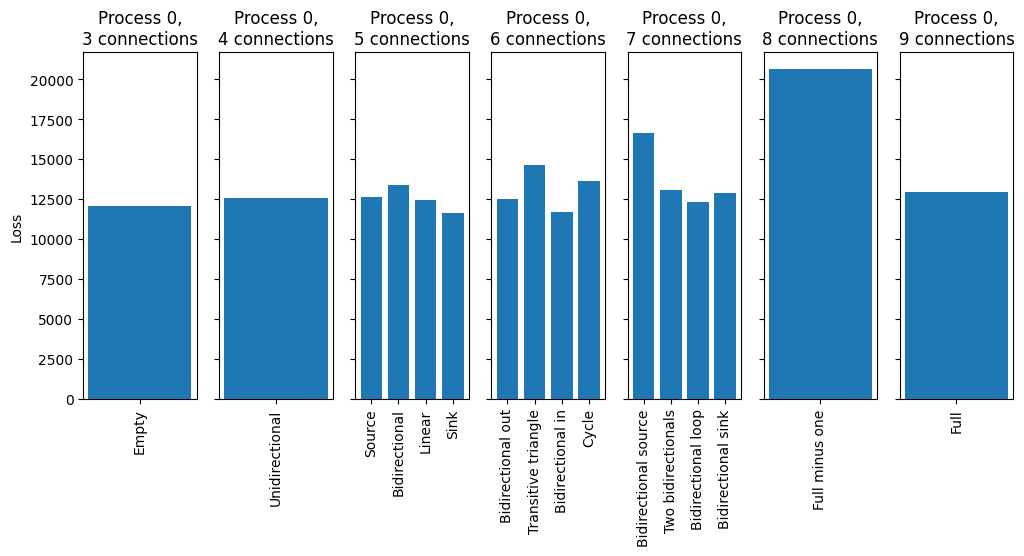

[{3: {'Empty': 12089.752776227568},
  4: {'Unidirectional': 12562.923815594066},
  5: {'Source': 12645.216719761262,
   'Bidirectional': 13415.82690371833,
   'Linear': 12424.021537328405,
   'Sink': 11633.708924357012},
  6: {'Bidirectional out': 12541.911378002045,
   'Transitive triangle': 14616.557285562076,
   'Bidirectional in': 11682.608031213787,
   'Cycle': 13647.606382583714},
  7: {'Bidirectional source': 16673.741120053026,
   'Two bidirectionals': 13054.120197292394,
   'Bidirectional loop': 12355.354476512273,
   'Bidirectional sink': 12861.343023568232},
  8: {'Full minus one': 20655.981684916514},
  9: {'Full': 12941.924859680465}}]

In [36]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(30, 3e-7), np.full(30, 2e-7))),
           A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, -0.8, 0.8]]))

Process dynamics: [[0.8 0.  0. ]
 [0.8 0.8 0. ]
 [0.8 0.8 0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.47360177 -0.1043154  -0.04853596]
 [ 0.32563549  0.38141492 -0.13263969]
 [ 0.19711075  0.24564672  0.3782864 ]]
Kalman filter K: [[0.27760354 0.06972429 0.06066996]
 [0.06972429 0.35743174 0.16579961]
 [0.06066996 0.16579961 0.52714199]]
Kalman filter loss: 9695.815547112772


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.15957232  0.          0.        ]
 [ 0.         -0.00497121  0.        ]
 [ 0.          0.          0.38160557]]
NN K: [[0.23635418 0.06865834 0.00712308]
 [0.14454985 0.51046041 0.07832082]
 [0.07671848 0.53803917 0.50601725]]
Testing Empty, Trial 2
NN M: [[-0.11059145  0.          0.        ]
 [ 0.         -0.09126075  0.        ]
 [ 0.          0.          0.3756531 ]]
NN K: [[1.51089808e-01 1.06069890e-01 4.68378283e-04]
 [1.00740407e-01 5.20361945e-01 9.07261725e-02]
 [1.22462295e-01 4.60418830e-01 5.26801263e-01]]
Testing Empty, Trial 3


  6%|███▎                                                 | 1/16 [16:05<4:01:15, 965.06s/it]

NN M: [[-0.13925226  0.          0.        ]
 [ 0.         -0.00761137  0.        ]
 [ 0.          0.          0.33513662]]
NN K: [[ 0.20810036  0.12221501 -0.00138433]
 [ 0.1442848   0.52159772  0.07443863]
 [-0.03419246  0.3285351   0.59362485]]
Testing Unidirectional, Trial 1
NN M: [[-0.12755792  0.          0.        ]
 [ 0.00763305 -0.0808296   0.        ]
 [ 0.          0.          0.30481976]]
NN K: [[ 0.20132712  0.22491493 -0.01791729]
 [ 0.1273158   0.52473752  0.08796486]
 [-0.02227691  0.20614695  0.65050341]]
Testing Unidirectional, Trial 2
NN M: [[-0.13895372  0.          0.        ]
 [ 0.02585965 -0.15563022  0.        ]
 [ 0.          0.          0.41953066]]
NN K: [[ 0.08429835  0.12517814 -0.00105518]
 [ 0.14883915  0.44733716  0.11137354]
 [ 0.23097608  0.57598739  0.47040885]]
Testing Unidirectional, Trial 3


 12%|██████▋                                              | 2/16 [32:06<3:44:38, 962.77s/it]

NN M: [[-0.19513022  0.          0.        ]
 [-0.10716282 -0.04533588  0.        ]
 [ 0.          0.          0.31238164]]
NN K: [[0.07492769 0.12478572 0.00226547]
 [0.15207238 0.47405573 0.09079805]
 [0.0517503  0.24261338 0.62600581]]
Testing Source, Trial 1
NN M: [[-0.36426683  0.          0.        ]
 [ 0.05207785 -0.00596641  0.        ]
 [ 0.30874578  0.          0.391387  ]]
NN K: [[0.11796062 0.0580857  0.01715132]
 [0.16059288 0.55266997 0.06865546]
 [0.17078859 0.50960032 0.49574789]]
Testing Source, Trial 2
NN M: [[-0.35344838  0.          0.        ]
 [ 0.18040718 -0.01414255  0.        ]
 [-0.05397884  0.          0.37904568]]
NN K: [[ 0.18701103  0.17180369 -0.00411097]
 [ 0.12930387  0.51427025  0.07380112]
 [ 0.13739012  0.50913784  0.51504488]]
Testing Source, Trial 3


 19%|█████████▉                                           | 3/16 [48:03<3:28:00, 960.07s/it]

NN M: [[-0.21739864  0.          0.        ]
 [ 0.05205943 -0.16732408  0.        ]
 [-0.00183548  0.          0.3828318 ]]
NN K: [[ 0.1410558   0.17426694 -0.00722246]
 [ 0.12481842  0.42742063  0.11787586]
 [ 0.04947282  0.41049613  0.53178881]]
Testing Bidirectional, Trial 1
NN M: [[-0.1462279   0.05879609  0.        ]
 [ 0.22332422 -0.04406693  0.        ]
 [ 0.          0.          0.31033818]]
NN K: [[ 0.18213067  0.16316236 -0.0188982 ]
 [ 0.18618285  0.51772848  0.07577449]
 [-0.01017795  0.18355964  0.64359295]]
Testing Bidirectional, Trial 2
NN M: [[-0.19908337  0.04866617  0.        ]
 [ 0.07800251 -0.14320069  0.        ]
 [ 0.          0.          0.32782455]]
NN K: [[ 0.13157014  0.15511606 -0.01287956]
 [ 0.13364697  0.50013015  0.10013904]
 [-0.00885921  0.28166294  0.60764681]]
Testing Bidirectional, Trial 3


 25%|████████████▊                                      | 4/16 [1:04:00<3:11:50, 959.18s/it]

NN M: [[-0.13058778  0.08935477  0.        ]
 [ 0.15912928 -0.03308407  0.        ]
 [ 0.          0.          0.38241428]]
NN K: [[ 0.1689771   0.17374793 -0.02738126]
 [ 0.09168768  0.51973409  0.07625709]
 [ 0.17046081  0.4297849   0.5241111 ]]
Testing Linear, Trial 1
NN M: [[-0.22390522  0.          0.        ]
 [-0.13996749 -0.09919839  0.        ]
 [ 0.          0.03235275  0.38865483]]
NN K: [[ 1.02580076e-01  1.44595851e-01 -6.08954002e-04]
 [ 1.11577873e-01  6.12172067e-01  8.01677141e-02]
 [ 1.58849324e-01  4.67124854e-01  5.06950494e-01]]
Testing Linear, Trial 2
NN M: [[-0.06853612  0.          0.        ]
 [ 0.00909055 -0.0176323   0.        ]
 [ 0.         -0.01195593  0.32700018]]
NN K: [[ 0.2038666   0.11355455 -0.00157547]
 [ 0.11486166  0.60520586  0.06388748]
 [ 0.05235038  0.30784471  0.60619086]]
Testing Linear, Trial 3


 31%|███████████████▉                                   | 5/16 [1:19:52<2:55:21, 956.51s/it]

NN M: [[-0.15379124  0.          0.        ]
 [ 0.02340814 -0.25848282  0.        ]
 [ 0.          0.60184016  0.31888184]]
NN K: [[ 0.13593598  0.18613517 -0.01018232]
 [ 0.10202318  0.07820425  0.19103491]
 [ 0.10636272  0.47661968  0.48226472]]
Testing Sink, Trial 1
NN M: [[-0.11597347  0.          0.        ]
 [ 0.21511596 -0.37525113 -0.06063712]
 [ 0.          0.          0.36882813]]
NN K: [[ 0.18819338  0.15975929 -0.00825743]
 [ 0.13911224  0.39491041  0.21468397]
 [ 0.11453308  0.42654978  0.54233605]]
Testing Sink, Trial 2
NN M: [[-0.17061106  0.          0.        ]
 [-0.10045558 -0.26077044 -0.05394773]
 [ 0.          0.          0.34534684]]
NN K: [[0.15527594 0.08202206 0.00567038]
 [0.08420895 0.59867539 0.16495329]
 [0.10532566 0.39469971 0.57268351]]
Testing Sink, Trial 3


 38%|███████████████████▏                               | 6/16 [1:35:41<2:38:59, 953.99s/it]

NN M: [[-0.06852685  0.          0.        ]
 [ 0.11445992 -0.31708311 -0.00244816]
 [ 0.          0.          0.37628349]]
NN K: [[ 0.10485972  0.14459993 -0.00469306]
 [ 0.10858533  0.47855196  0.13302197]
 [ 0.171294    0.4716018   0.52790318]]
Testing Bidirectional out, Trial 1
NN M: [[-2.30871600e-01  5.49817871e-02  0.00000000e+00]
 [-7.48518551e-02 -1.88127446e-01  0.00000000e+00]
 [ 1.08893998e-04  0.00000000e+00  3.66247422e-01]]
NN K: [[ 0.18289156  0.10081479 -0.00337588]
 [ 0.15708622  0.45022322  0.1205899 ]
 [ 0.15289472  0.37880563  0.54741085]]
Testing Bidirectional out, Trial 2
NN M: [[-0.54331835  0.06153233  0.        ]
 [ 0.10147131 -0.08748055  0.        ]
 [-0.91782396  0.          0.33201418]]
NN K: [[ 0.21889238  0.26772973 -0.02904857]
 [ 0.04995394  0.53199037  0.08578066]
 [ 0.11633777  0.65823394  0.56866523]]
Testing Bidirectional out, Trial 3


 44%|██████████████████████▎                            | 7/16 [1:51:28<2:22:44, 951.64s/it]

NN M: [[-0.16510345  0.04119175  0.        ]
 [ 0.1237083  -0.09150554  0.        ]
 [-0.01204961  0.          0.37209035]]
NN K: [[ 0.24672318  0.26201728 -0.03085567]
 [ 0.1013474   0.49639176  0.09100646]
 [ 0.10040551  0.45566183  0.53300811]]
Testing Transitive triangle, Trial 1
NN M: [[-0.30006796  0.          0.        ]
 [-0.2825616  -0.11791516  0.        ]
 [ 0.22450448  0.54132654  0.31001886]]
NN K: [[0.11134997 0.07506911 0.01221529]
 [0.10621693 0.44559363 0.11315066]
 [0.07368058 0.38006916 0.51170541]]
Testing Transitive triangle, Trial 2
NN M: [[-0.24591558  0.          0.        ]
 [-0.0276002  -0.28967339  0.        ]
 [ 0.02171908  0.2087647   0.42360425]]
NN K: [[ 0.17305144  0.15671864 -0.00348956]
 [ 0.01380904  0.21343541  0.17111885]
 [ 0.22881796  0.45406392  0.3003199 ]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████▌                         | 8/16 [2:07:15<2:06:39, 949.99s/it]

NN M: [[-0.52890965  0.          0.        ]
 [-0.67439091 -0.16468955  0.        ]
 [ 0.6089674   0.35965909  0.38305099]]
NN K: [[ 0.06603565 -0.11668561  0.04898355]
 [ 0.02966231  0.26913845  0.15723212]
 [ 0.28435568  0.5159327   0.40988544]]
Testing Bidirectional in, Trial 1
NN M: [[-0.38939502  0.00141393 -0.06654026]
 [ 0.17238392 -0.09180524  0.        ]
 [ 0.          0.          0.37355715]]
NN K: [[0.12493324 0.22004616 0.06002834]
 [0.08124763 0.49959662 0.0920892 ]
 [0.15169452 0.45268549 0.53640972]]
Testing Bidirectional in, Trial 2
NN M: [[-0.45106235 -0.04429155 -0.00234546]
 [ 0.15657498 -0.1302709   0.        ]
 [ 0.          0.          0.38101083]]
NN K: [[0.22336802 0.17673031 0.00368821]
 [0.13223077 0.48290645 0.1003755 ]
 [0.02306168 0.32573956 0.54261473]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▋                      | 9/16 [2:23:04<1:50:49, 949.93s/it]

NN M: [[-0.32481586 -0.02318348 -0.07871652]
 [ 0.00201527 -0.02488335  0.        ]
 [ 0.          0.          0.36828021]]
NN K: [[0.15211764 0.19429249 0.07959239]
 [0.20587149 0.51618557 0.07795135]
 [0.11734319 0.41263539 0.54713173]]
Testing Cycle, Trial 1
NN M: [[-0.39472855  0.          0.02899716]
 [-0.05108683 -0.39225863  0.        ]
 [ 0.          0.61881694  0.3554395 ]]
NN K: [[ 0.21096757  0.02870381 -0.01126572]
 [ 0.03861155  0.09625901  0.21393912]
 [ 0.09876143  0.58763401  0.42197876]]
Testing Cycle, Trial 2
NN M: [[-0.36048796  0.         -0.04569205]
 [ 0.05504745 -0.27358691  0.        ]
 [ 0.          0.36843722  0.36417951]]
NN K: [[0.18203309 0.19777273 0.03817713]
 [0.11706539 0.36310881 0.14620938]
 [0.045263   0.45648311 0.48375173]]
Testing Cycle, Trial 3


 62%|███████████████████████████████▎                  | 10/16 [2:38:51<1:34:53, 948.85s/it]

NN M: [[-0.37483587  0.         -0.05010028]
 [ 0.11159009 -0.31291761  0.        ]
 [ 0.          0.43950126  0.31550336]]
NN K: [[0.15416138 0.17821973 0.0466399 ]
 [0.10260672 0.30634223 0.16128635]
 [0.01651398 0.45227498 0.52403811]]
Testing Bidirectional source, Trial 1
NN M: [[-0.40500527 -0.25529235  0.        ]
 [-0.21626792 -0.3668445   0.        ]
 [ 0.1449028   0.37632018  0.34483355]]
NN K: [[0.08176247 0.02274027 0.06647658]
 [0.0955696  0.22562621 0.19079995]
 [0.07447577 0.41654718 0.4999658 ]]
Testing Bidirectional source, Trial 2
NN M: [[-2.50057184e-01  5.42434818e-02  0.00000000e+00]
 [-1.24171041e-02 -4.94616995e-01  0.00000000e+00]
 [ 4.75616741e-04  3.21559890e-01  3.88144177e-01]]
NN K: [[ 0.06556145  0.15606826 -0.00954721]
 [ 0.07973916  0.31679355  0.19489925]
 [ 0.19680977  0.35963678  0.47793058]]
Testing Bidirectional source, Trial 3


 69%|██████████████████████████████████▍               | 11/16 [2:54:51<1:19:22, 952.42s/it]

NN M: [[-0.63596589  0.04854055  0.        ]
 [ 0.1671253  -0.46239036  0.        ]
 [-0.19520705 -0.0042158   0.39967188]]
NN K: [[ 0.12900745  0.15568839 -0.00168116]
 [ 0.0333786   0.29069143  0.18923592]
 [ 0.02531086  0.45599123  0.51210794]]
Testing Two bidirectionals, Trial 1
NN M: [[-0.62204525 -0.24986257 -0.06454863]
 [ 0.26678165 -0.1689982   0.        ]
 [ 0.10048462  0.          0.37542771]]
NN K: [[0.05079161 0.0071125  0.13891488]
 [0.09495449 0.4531679  0.10972918]
 [0.05179763 0.5156649  0.52325502]]
Testing Two bidirectionals, Trial 2
NN M: [[-0.58102489  0.18984993  0.01858337]
 [-0.11343438 -0.18120936  0.        ]
 [-0.03319826  0.          0.296347  ]]
NN K: [[ 0.13486836  0.23150747 -0.05936539]
 [ 0.13398974  0.49073877  0.11428467]
 [-0.08386422  0.25163536  0.65086304]]
Testing Two bidirectionals, Trial 3


 75%|█████████████████████████████████████▌            | 12/16 [3:10:54<1:03:41, 955.48s/it]

NN M: [[-0.47442682 -0.10963562 -0.09715371]
 [ 0.12189392 -0.02965879  0.        ]
 [ 0.07565471  0.          0.39882047]]
NN K: [[0.13063391 0.00306528 0.1436085 ]
 [0.09022468 0.51362517 0.07806317]
 [0.11758529 0.35063634 0.52512586]]
Testing Bidirectional loop, Trial 1
NN M: [[-0.28830511  0.14338571  0.        ]
 [-0.05481136 -0.33342566 -0.02303713]
 [ 0.01736039  0.          0.33914154]]
NN K: [[ 0.1829926   0.19797321 -0.03287002]
 [ 0.15698846  0.46279066  0.16455938]
 [-0.06558086  0.39701853  0.57867083]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.55497009  0.11769029  0.        ]
 [-0.19073826 -0.22614655 -0.05303101]
 [-0.65067505  0.          0.34467458]]
NN K: [[ 0.17834959  0.35474931 -0.04912034]
 [ 0.10312211  0.51838037  0.17179569]
 [ 0.16174678  0.632583    0.54837015]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [3:26:58<47:54, 958.12s/it]

NN M: [[-0.208603   -0.09495895  0.        ]
 [ 0.10065713 -0.34452909 -0.03071606]
 [ 0.00502457  0.          0.31707099]]
NN K: [[0.15822723 0.12318495 0.0172046 ]
 [0.17821874 0.43585499 0.17342114]
 [0.1041908  0.22588997 0.6274569 ]]
Testing Bidirectional sink, Trial 1
NN M: [[-0.11838686  0.          0.        ]
 [ 0.25358177 -0.40222843  0.01767187]
 [-0.01313641 -0.00568676  0.37547481]]
NN K: [[ 0.19143722  0.17810626 -0.01092156]
 [ 0.17581899  0.44760826  0.12849972]
 [ 0.17760198  0.43780003  0.53761562]]
Testing Bidirectional sink, Trial 2
NN M: [[-0.41374724  0.          0.        ]
 [-0.09876761 -0.3073459  -0.08160196]
 [ 0.02480622  0.11914081  0.34521786]]
NN K: [[0.17582699 0.10264734 0.0087361 ]
 [0.0613902  0.36756282 0.23705015]
 [0.03733111 0.32127197 0.56670609]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [3:43:05<32:01, 960.72s/it]

NN M: [[-0.32612129  0.          0.        ]
 [ 0.11074971 -0.31158202  0.03301653]
 [ 0.01293393 -0.04909841  0.39571609]]
NN K: [[ 0.1625331   0.18262339 -0.00630991]
 [ 0.07708141  0.56049244  0.08031135]
 [ 0.09871474  0.43599596  0.51993432]]
Testing Full minus one, Trial 1
NN M: [[-0.52308179  0.23217384 -0.05173006]
 [ 0.01464593 -0.36799061  0.        ]
 [ 0.02619831  0.12091614  0.39757257]]
NN K: [[0.13259244 0.17840781 0.01562611]
 [0.15231059 0.37568561 0.16157254]
 [0.20135167 0.35161583 0.49873249]]
Testing Full minus one, Trial 2
NN M: [[-0.57194965 -0.25186643  0.00799411]
 [-0.17267479 -0.09257947  0.        ]
 [-0.04880495 -0.11315548  0.29898265]]
NN K: [[0.11451285 0.00077992 0.06468841]
 [0.15533337 0.50431147 0.09631485]
 [0.11104304 0.2375866  0.66556646]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [3:59:16<16:03, 963.98s/it]

NN M: [[-0.45881007 -0.03243559 -0.05209689]
 [-0.06613638 -0.37720874  0.        ]
 [ 0.06810419  0.65822827  0.34407993]]
NN K: [[0.15509727 0.14765632 0.0624265 ]
 [0.0701207  0.05190296 0.21660902]
 [0.09037583 0.5880154  0.42408738]]
Testing Full, Trial 1
NN M: [[-0.54347602  0.13086116 -0.04772298]
 [-0.17746254 -0.4034414   0.01200622]
 [ 0.02640539 -0.08115953  0.36542999]]
NN K: [[0.16810754 0.18957465 0.02566596]
 [0.09023835 0.43389988 0.14513788]
 [0.01518174 0.46202198 0.55533767]]
Testing Full, Trial 2
NN M: [[-0.48144771 -0.18174869 -0.07879863]
 [-0.30821898 -0.29576529 -0.01281147]
 [ 0.85791946  0.65852987  0.32807756]]
NN K: [[-0.03399761 -0.09060702  0.16418287]
 [-0.0642756   0.27920037  0.19179713]
 [ 0.21172516  0.60633122  0.42156318]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 16/16 [4:15:31<00:00, 958.24s/it]

NN M: [[-0.4786508   0.14320219 -0.04150007]
 [-0.03555204 -0.66573167  0.08407315]
 [ 0.01755476  0.12529396  0.37134945]]
NN K: [[0.19313574 0.17538387 0.0184241 ]
 [0.11027997 0.2319506  0.14848046]
 [0.06034561 0.54311872 0.50014571]]


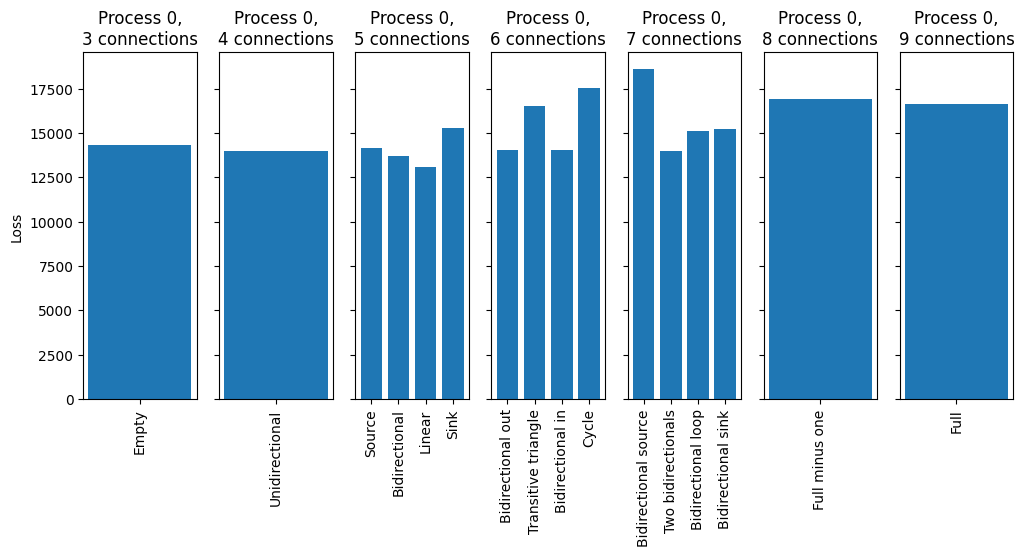

[{3: {'Empty': 14316.835673486386},
  4: {'Unidirectional': 13982.472290005466},
  5: {'Source': 14163.496380805398,
   'Bidirectional': 13689.816237102623,
   'Linear': 13100.19855989004,
   'Sink': 15277.3862028208},
  6: {'Bidirectional out': 14015.188018195495,
   'Transitive triangle': 16498.990582618426,
   'Bidirectional in': 14047.405425123678,
   'Cycle': 17521.443886982222},
  7: {'Bidirectional source': 18611.31606242661,
   'Two bidirectionals': 13963.396090035621,
   'Bidirectional loop': 15095.092295080967,
   'Bidirectional sink': 15205.569953693644},
  8: {'Full minus one': 16930.73953582129},
  9: {'Full': 16654.202105228036}}]

In [59]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 8e-8))),
           A=np.array([[0.8, 0, 0], [0.8, 0.8, 0], [0.8, 0.8, 0.8]]))

Process dynamics: [[0.   0.   0.  ]
 [0.95 0.   0.  ]
 [0.95 0.95 0.  ]]
Eigenvalues: [0. 0. 0.]
Kalman filter M: [[ 0.          0.          0.        ]
 [ 0.60140889 -0.07174766  0.        ]
 [ 0.49686747  0.56861513  0.        ]]
Kalman filter K: [[0.2        0.         0.        ]
 [0.         0.29141415 0.07552386]
 [0.         0.07552386 0.40145775]]
Kalman filter loss: 8274.436285844535


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.19375774  0.          0.        ]
 [ 0.         -0.06558078  0.        ]
 [ 0.          0.          0.10893687]]
NN K: [[ 0.19231514 -0.00559633 -0.00384874]
 [-0.00559708  0.31384131  0.08538036]
 [ 0.00744334  0.09885176  0.45697996]]
Testing Empty, Trial 2
NN M: [[-0.05761273  0.          0.        ]
 [ 0.         -0.16327079  0.        ]
 [ 0.          0.          0.11464703]]
NN K: [[ 1.97580869e-01  2.56849000e-03 -5.56447850e-06]
 [-1.97857497e-02  3.01403969e-01  9.42440646e-02]
 [ 6.00657069e-03  9.96948648e-02  4.53056766e-01]]
Testing Empty, Trial 3


  6%|███▎                                                 | 1/16 [10:43<2:40:51, 643.45s/it]

NN M: [[-0.12602232  0.          0.        ]
 [ 0.         -0.00793977  0.        ]
 [ 0.          0.          0.11493199]]
NN K: [[ 0.19599997  0.00386851  0.00071212]
 [-0.00112412  0.31005324  0.08167142]
 [ 0.00858576  0.0974873   0.45396722]]
Testing Unidirectional, Trial 1
NN M: [[-0.07245291  0.          0.        ]
 [ 0.22089381 -0.06023897  0.        ]
 [ 0.          0.          0.1114796 ]]
NN K: [[ 0.21453643  0.0007917   0.00062563]
 [-0.00488101  0.30315046  0.08232902]
 [ 0.01237808  0.09886587  0.45295717]]
Testing Unidirectional, Trial 2
NN M: [[0.02615079 0.         0.        ]
 [0.0217059  0.0112173  0.        ]
 [0.         0.         0.11009669]]
NN K: [[ 0.2002954  -0.00156462 -0.00187318]
 [ 0.00126913  0.31003341  0.07925564]
 [ 0.00823001  0.09940948  0.45534549]]
Testing Unidirectional, Trial 3


 12%|██████▋                                              | 2/16 [21:30<2:30:35, 645.42s/it]

NN M: [[ 0.12740702  0.          0.        ]
 [ 0.05648528 -0.00841174  0.        ]
 [ 0.          0.          0.12665743]]
NN K: [[ 0.20076385 -0.00407628 -0.00169748]
 [ 0.00121126  0.30826249  0.08275243]
 [ 0.01225954  0.10256609  0.45043011]]
Testing Source, Trial 1
NN M: [[-0.13544623  0.          0.        ]
 [ 0.19408565  0.03988768  0.        ]
 [ 0.09984628  0.          0.11194641]]
NN K: [[ 0.21831524  0.01048428 -0.00206985]
 [ 0.00565919  0.30546392  0.07125071]
 [ 0.00646948  0.09774003  0.44927313]]
Testing Source, Trial 2
NN M: [[ 0.07195392  0.          0.        ]
 [ 0.04495103 -0.1227689   0.        ]
 [ 0.28393702  0.          0.11823234]]
NN K: [[ 0.21323364  0.03594466 -0.01326885]
 [-0.01231591  0.30499346  0.09075845]
 [ 0.00677766  0.09073612  0.44470055]]
Testing Source, Trial 3


 19%|█████████▉                                           | 3/16 [32:10<2:19:22, 643.24s/it]

NN M: [[-0.02654595  0.          0.        ]
 [ 0.22803078  0.03800768  0.        ]
 [ 0.02894276  0.          0.09515295]]
NN K: [[ 0.21609132 -0.00298627 -0.0021095 ]
 [ 0.00330399  0.30059875  0.07279809]
 [ 0.00611161  0.09328109  0.46035411]]
Testing Bidirectional, Trial 1
NN M: [[-0.05968153 -0.05286965  0.        ]
 [ 0.02724543 -0.04508357  0.        ]
 [ 0.          0.          0.10957374]]
NN K: [[ 0.19959367  0.0011471   0.00603257]
 [-0.00563141  0.30868655  0.08439394]
 [ 0.01029935  0.09858725  0.4541934 ]]
Testing Bidirectional, Trial 2
NN M: [[ 0.04977902  0.05958635  0.        ]
 [ 0.08362076 -0.02802459  0.        ]
 [ 0.          0.          0.11425343]]
NN K: [[ 0.20631963 -0.00495812 -0.00553992]
 [-0.00053558  0.30921549  0.07920294]
 [ 0.01137001  0.09866796  0.45486883]]
Testing Bidirectional, Trial 3


 25%|█████████████▎                                       | 4/16 [42:47<2:08:08, 640.75s/it]

NN M: [[-0.02198832  0.03726465  0.        ]
 [ 0.12335294 -0.11418972  0.        ]
 [ 0.          0.          0.11493154]]
NN K: [[ 0.2087749   0.00358894 -0.00185947]
 [-0.01301377  0.3046085   0.08829609]
 [ 0.00956453  0.09961351  0.45720717]]
Testing Linear, Trial 1
NN M: [[-0.02594764  0.          0.        ]
 [ 0.16807728  0.02202745  0.        ]
 [ 0.          0.23138575  0.06665595]]
NN K: [[ 0.21482819 -0.00338792 -0.00139588]
 [ 0.02264983  0.32174372  0.06905462]
 [ 0.00616955  0.09002269  0.43973528]]
Testing Linear, Trial 2
NN M: [[ 0.02756351  0.          0.        ]
 [ 0.14790537 -0.01822948  0.        ]
 [ 0.          0.24402589  0.06346199]]
NN K: [[ 0.21301409 -0.00556082 -0.00279961]
 [ 0.01790777  0.32553973  0.0719838 ]
 [ 0.00840524  0.0901861   0.43438844]]
Testing Linear, Trial 3


 31%|████████████████▌                                    | 5/16 [53:22<1:57:02, 638.42s/it]

NN M: [[-0.01164799  0.          0.        ]
 [ 0.03377871 -0.13685504  0.        ]
 [ 0.          0.25606732  0.07188653]]
NN K: [[ 0.20206797  0.0018327  -0.00138032]
 [ 0.00323707  0.32536108  0.08856713]
 [ 0.00517999  0.09656103  0.43699241]]
Testing Sink, Trial 1
NN M: [[-0.03329095  0.          0.        ]
 [ 0.2092252  -0.05299898  0.00091871]
 [ 0.          0.          0.09766149]]
NN K: [[ 2.14005335e-01 -1.81348164e-03 -3.96046568e-04]
 [-3.67195739e-03  3.03342551e-01  8.21871804e-02]
 [ 7.20190391e-03  9.23042901e-02  4.57630308e-01]]
Testing Sink, Trial 2
NN M: [[-0.01180723  0.          0.        ]
 [-0.12508597 -0.05066337  0.00336878]
 [ 0.          0.          0.11589318]]
NN K: [[ 1.79647098e-01  4.22791023e-04  2.38707455e-03]
 [-6.19982018e-03  3.13425765e-01  8.71485137e-02]
 [ 1.02735634e-02  1.00015012e-01  4.53297145e-01]]
Testing Sink, Trial 3


 38%|███████████████████▏                               | 6/16 [1:03:55<1:46:06, 636.70s/it]

NN M: [[ 0.02019066  0.          0.        ]
 [ 0.13932122 -0.08348014  0.0030019 ]
 [ 0.          0.          0.12435616]]
NN K: [[ 0.21083746 -0.00280867 -0.00215185]
 [-0.00648833  0.30151923  0.08580068]
 [ 0.01169938  0.09923548  0.44869976]]
Testing Bidirectional out, Trial 1
NN M: [[-0.03728949 -0.02612867  0.        ]
 [-0.0151503   0.01347642  0.        ]
 [ 0.18202454  0.          0.12573944]]
NN K: [[ 0.20378099  0.02709139 -0.00227368]
 [ 0.0022023   0.31150774  0.08449122]
 [ 0.00647039  0.09374187  0.45032706]]
Testing Bidirectional out, Trial 2
NN M: [[-0.07308127  0.09622703  0.        ]
 [ 0.14662302 -0.00698768  0.        ]
 [ 0.05810454  0.          0.11217455]]
NN K: [[ 0.21359013  0.00884184 -0.0089694 ]
 [ 0.00124249  0.29968271  0.07623747]
 [ 0.00764577  0.09626249  0.45372867]]
Testing Bidirectional out, Trial 3


 44%|██████████████████████▎                            | 7/16 [1:14:30<1:35:24, 636.03s/it]

NN M: [[ 0.08067936  0.06531947  0.        ]
 [ 0.09106063 -0.03534321  0.        ]
 [ 0.05447706  0.          0.12075857]]
NN K: [[ 0.2099238   0.00167085 -0.01190942]
 [-0.00258305  0.30552308  0.08035625]
 [ 0.00752589  0.09694522  0.45027328]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.02326706  0.          0.        ]
 [ 0.20871437 -0.06359626  0.        ]
 [ 0.08684285  0.16469159  0.09630902]]
NN K: [[ 0.22076836  0.00469846 -0.00673941]
 [ 0.00777674  0.31747014  0.08019369]
 [ 0.00810288  0.09663382  0.43892416]]
Testing Transitive triangle, Trial 2
NN M: [[ 0.10872368  0.          0.        ]
 [-0.0169027   0.09878403  0.        ]
 [-0.00868113  0.24671577  0.05713833]]
NN K: [[ 0.18863183 -0.00302124  0.00095247]
 [ 0.03456216  0.32500462  0.06622761]
 [ 0.0038003   0.09046002  0.44010365]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████▌                         | 8/16 [1:24:58<1:24:29, 633.73s/it]

NN M: [[-0.15354801  0.          0.        ]
 [ 0.06222659 -0.16008913  0.        ]
 [ 0.04515788  0.25820314  0.0639881 ]]
NN K: [[0.20114135 0.00774363 0.00271179]
 [0.00128531 0.32273092 0.09159844]
 [0.00752533 0.08821996 0.43872979]]
Testing Bidirectional in, Trial 1
NN M: [[ 0.03076996  0.07276251 -0.01916475]
 [ 0.18133543 -0.0906597   0.        ]
 [ 0.          0.          0.10479861]]
NN K: [[ 0.2125311   0.0012811  -0.00542836]
 [-0.00721482  0.30220007  0.08736502]
 [ 0.00660237  0.09427698  0.45666087]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.11067731  0.09523181 -0.01978923]
 [ 0.13605313 -0.05766739  0.        ]
 [ 0.          0.          0.11955288]]
NN K: [[ 0.20715672 -0.00719167 -0.00892496]
 [-0.00615983  0.29935239  0.08230065]
 [ 0.01357285  0.10227779  0.44749539]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▋                      | 9/16 [1:35:28<1:13:46, 632.40s/it]

NN M: [[-0.08211343 -0.02848036  0.0035015 ]
 [ 0.02184785 -0.09281919  0.        ]
 [ 0.          0.          0.11424127]]
NN K: [[ 0.200717    0.00169588  0.00314558]
 [-0.01067966  0.3100872   0.08685144]
 [ 0.00986823  0.09865982  0.45381165]]
Testing Cycle, Trial 1
NN M: [[-0.09331771  0.         -0.00358649]
 [ 0.11370752  0.0038228   0.        ]
 [ 0.          0.28193517  0.04846264]]
NN K: [[0.20615143 0.00104455 0.00196439]
 [0.02335346 0.32775609 0.07528854]
 [0.00281053 0.09012762 0.43853545]]
Testing Cycle, Trial 2
NN M: [[ 0.10673516  0.          0.00043074]
 [ 0.18109523 -0.06576735  0.        ]
 [ 0.          0.29788607  0.04268196]]
NN K: [[ 2.13124533e-01 -6.72915578e-03 -5.07173138e-03]
 [ 1.33583952e-02  3.24135558e-01  7.97535265e-02]
 [ 3.92438677e-04  8.89323196e-02  4.33923492e-01]]
Testing Cycle, Trial 3


 62%|███████████████████████████████▎                  | 10/16 [1:45:56<1:03:06, 631.04s/it]

NN M: [[ 0.04609925  0.         -0.00066562]
 [ 0.15733427 -0.08125397  0.        ]
 [ 0.          0.25830089  0.05790928]]
NN K: [[ 0.21298279 -0.00104922 -0.0019667 ]
 [ 0.01191496  0.32219381  0.08139653]
 [ 0.00776628  0.09243815  0.43833171]]
Testing Bidirectional source, Trial 1
NN M: [[-0.1182625  -0.01869997  0.        ]
 [ 0.0042433  -0.11742555  0.        ]
 [-0.17620154  0.19594402  0.07928209]]
NN K: [[ 0.1733412  -0.01812565  0.00744186]
 [ 0.00491303  0.32255737  0.0864403 ]
 [ 0.0091954   0.09360822  0.44232968]]
Testing Bidirectional source, Trial 2
NN M: [[ 0.08785287 -0.01085317  0.        ]
 [ 0.03157733 -0.05217015  0.        ]
 [ 0.09901385  0.14844326  0.0957783 ]]
NN K: [[ 0.20625536  0.00811224 -0.00478938]
 [ 0.00371086  0.32106544  0.08191527]
 [ 0.00525037  0.0919793   0.44182513]]
Testing Bidirectional source, Trial 3


 69%|███████████████████████████████████▊                | 11/16 [1:56:41<52:56, 635.25s/it]

NN M: [[-0.02890617 -0.03473271  0.        ]
 [-0.08562473 -0.00579794  0.        ]
 [ 0.0146355   0.12014601  0.1016739 ]]
NN K: [[0.1812897  0.00231883 0.00422334]
 [0.00508233 0.32246196 0.07955256]
 [0.00894927 0.0965248  0.44533105]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.02136665 -0.01372585 -0.00752382]
 [ 0.1316831  -0.08545411  0.        ]
 [ 0.04205785  0.          0.12728588]]
NN K: [[ 2.10934072e-01  1.13212747e-03 -3.90144339e-04]
 [-8.78925849e-03  3.04353056e-01  8.47009271e-02]
 [ 1.49094053e-02  1.01099154e-01  4.48231645e-01]]
Testing Two bidirectionals, Trial 2
NN M: [[-0.01156525 -0.06012222  0.01471542]
 [-0.08137038  0.03883022  0.        ]
 [ 0.10934799  0.          0.10816267]]
NN K: [[0.19240189 0.01852038 0.00479146]
 [0.00695555 0.31173946 0.07939948]
 [0.00825139 0.0917365  0.45519417]]
Testing Two bidirectionals, Trial 3


 75%|███████████████████████████████████████             | 12/16 [2:07:12<42:16, 634.01s/it]

NN M: [[ 0.0613221   0.0028422  -0.00530485]
 [ 0.08639859 -0.02498786  0.        ]
 [ 0.1104602   0.          0.09971343]]
NN K: [[ 0.20942137  0.0138191  -0.00314614]
 [-0.00141437  0.30771234  0.08352712]
 [ 0.00547293  0.09145486  0.45427011]]
Testing Bidirectional loop, Trial 1
NN M: [[ 0.02253805 -0.02647163  0.        ]
 [ 0.08460243 -0.03845065 -0.0155207 ]
 [ 0.01452827  0.          0.11724425]]
NN K: [[ 0.20495771 -0.00162133  0.00295077]
 [-0.0036832   0.30623949  0.08312252]
 [ 0.00974192  0.10114533  0.45213576]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.00892785 -0.03272125  0.        ]
 [ 0.22071658 -0.12093686  0.02077736]
 [ 0.24126565  0.          0.1169367 ]]
NN K: [[ 0.22451655  0.03144834 -0.00363991]
 [-0.00913115  0.30036536  0.08471554]
 [ 0.00600123  0.09172618  0.44674545]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [2:17:43<31:39, 633.11s/it]

NN M: [[ 0.07049744 -0.02601632  0.        ]
 [ 0.14642174 -0.12877863  0.01116927]
 [ 0.1030036   0.          0.11365817]]
NN K: [[ 0.21732509  0.01223493  0.00069842]
 [-0.00979103  0.30417202  0.0880887 ]
 [ 0.0106202   0.09676136  0.45117488]]
Testing Bidirectional sink, Trial 1
NN M: [[ 0.02389646  0.          0.        ]
 [ 0.11910812  0.06821489 -0.04772471]
 [ 0.06662024  0.28013133  0.05759007]]
NN K: [[ 0.21510967 -0.00373146 -0.00136225]
 [ 0.02656542  0.32095677  0.07058588]
 [-0.00052496  0.09093047  0.432156  ]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.04703065  0.          0.        ]
 [ 0.07686211  0.02095283 -0.04577712]
 [ 0.14806798  0.31559623  0.06167147]]
NN K: [[ 0.2164564   0.00100822 -0.00387011]
 [ 0.02434942  0.32242863  0.07417294]
 [ 0.0013133   0.08764362  0.42397173]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [2:28:12<21:03, 631.83s/it]

NN M: [[ 0.02800611  0.          0.        ]
 [ 0.2781809  -0.09205484 -0.00753523]
 [ 0.15040604  0.35499115  0.04494465]]
NN K: [[ 2.26132756e-01  5.28763044e-03 -3.57645854e-03]
 [ 1.08204149e-02  3.16666631e-01  8.22010861e-02]
 [-3.01392844e-04  8.22209469e-02  4.23226000e-01]]
Testing Full minus one, Trial 1
NN M: [[ 0.07460488  0.04230782 -0.02043269]
 [ 0.29655994 -0.00290542  0.        ]
 [ 0.05660644  0.23608542  0.06145154]]
NN K: [[ 0.22203845 -0.00713388 -0.00938872]
 [ 0.01658118  0.31875363  0.06801593]
 [ 0.00395925  0.08685692  0.43686306]]
Testing Full minus one, Trial 2
NN M: [[-0.09926175 -0.02800249  0.00706014]
 [ 0.09380842 -0.05749661  0.        ]
 [ 0.06598233  0.30800492  0.04562016]]
NN K: [[ 2.06500656e-01  5.55129440e-03 -3.07772662e-05]
 [ 1.16343685e-02  3.26411537e-01  8.20640629e-02]
 [ 3.61333579e-03  8.63051952e-02  4.32053013e-01]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [2:38:41<10:31, 631.17s/it]

NN M: [[ 0.05263035  0.04543886 -0.02543548]
 [ 0.09815517 -0.08186975  0.        ]
 [ 0.06217218  0.08297447  0.11626722]]
NN K: [[ 0.21242589  0.00372321 -0.00330074]
 [-0.00454463  0.31066976  0.08502554]
 [ 0.01256341  0.09812443  0.44419684]]
Testing Full, Trial 1
NN M: [[ 0.11883299  0.04336522 -0.02139085]
 [ 0.18207465 -0.11027054 -0.00379426]
 [ 0.09598961  0.18708334  0.08627541]]
NN K: [[ 0.21762548  0.00301825 -0.00837201]
 [-0.00180476  0.31469653  0.0817642 ]
 [ 0.00980807  0.09454879  0.43405499]]
Testing Full, Trial 2
NN M: [[-0.00157624  0.06860102 -0.01895443]
 [ 0.06373895 -0.09064865 -0.01195962]
 [ 0.13226078  0.35370916  0.04353145]]
NN K: [[ 0.2098983   0.00798466 -0.00535018]
 [ 0.01070811  0.32292638  0.08473172]
 [-0.00057699  0.08582544  0.42625921]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 16/16 [2:49:08<00:00, 634.31s/it]

NN M: [[ 0.12353149 -0.02356451  0.00998602]
 [ 0.17157365  0.00172112 -0.03651717]
 [ 0.10872981  0.25921069  0.05353641]]
NN K: [[ 2.17072527e-01  6.63282592e-05 -5.10297652e-03]
 [ 1.61093799e-02  3.23686446e-01  7.79647343e-02]
 [-2.08138727e-03  8.97711923e-02  4.38991592e-01]]


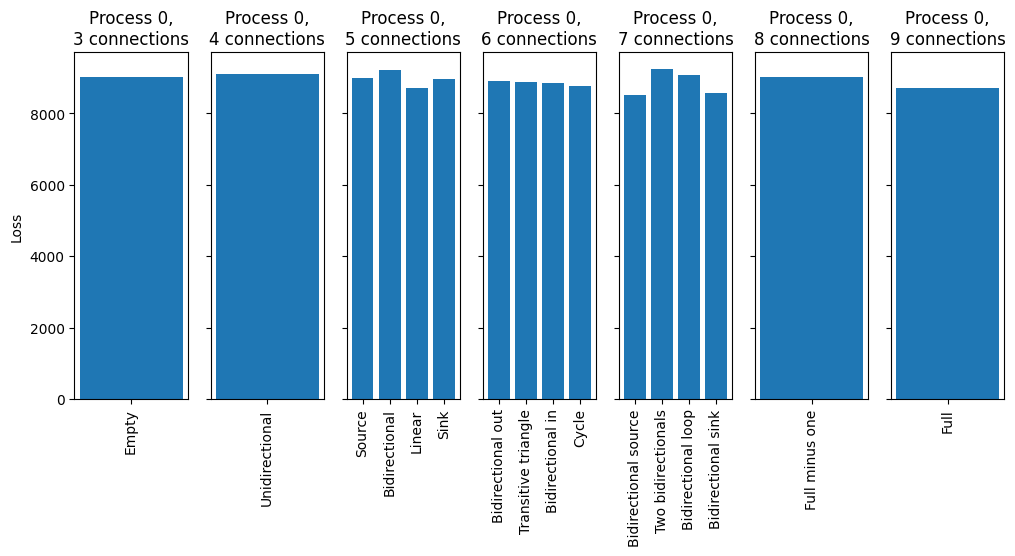

[{3: {'Empty': 9008.209995971125},
  4: {'Unidirectional': 9100.313336750381},
  5: {'Source': 9002.116218557543,
   'Bidirectional': 9207.532323291167,
   'Linear': 8697.602162010267,
   'Sink': 8955.891552214345},
  6: {'Bidirectional out': 8916.295874239599,
   'Transitive triangle': 8864.328485126773,
   'Bidirectional in': 8855.702091376888,
   'Cycle': 8753.301623192247},
  7: {'Bidirectional source': 8506.372713608222,
   'Two bidirectionals': 9244.050229024238,
   'Bidirectional loop': 9065.872573097648,
   'Bidirectional sink': 8570.43236737492},
  8: {'Full minus one': 9014.379858662762},
  9: {'Full': 8711.552089584195}}]

In [60]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 5e-7))),
           A=np.array([[0, 0, 0], [0.95, 0, 0], [0.95, 0.95, 0]]))

Process dynamics: [[ 0.    0.    0.  ]
 [ 0.95  0.    0.  ]
 [ 0.95 -0.95  0.  ]]
Eigenvalues: [0. 0. 0.]
Kalman filter M: [[ 0.          0.          0.        ]
 [ 0.60140889  0.07174766  0.        ]
 [ 0.49686747 -0.56861513  0.        ]]
Kalman filter K: [[0.2        0.         0.        ]
 [0.         0.29141415 0.07552386]
 [0.         0.07552386 0.40145775]]
Kalman filter loss: 8391.231551464942


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.08493051  0.          0.        ]
 [ 0.         -0.00739961  0.        ]
 [ 0.         -0.         -0.10814416]]
NN K: [[ 0.19762111  0.00407248  0.00064989]
 [-0.00337138  0.31232876  0.07739996]
 [-0.01116574  0.10080809  0.4564599 ]]
Testing Empty, Trial 2
NN M: [[ 0.03352221  0.          0.        ]
 [ 0.          0.13107637  0.        ]
 [ 0.          0.         -0.1461912 ]]
NN K: [[ 0.19896586 -0.00154602 -0.00052498]
 [ 0.01755578  0.30353031  0.0927552 ]
 [-0.01237751  0.10262339  0.44635984]]
Testing Empty, Trial 3


  6%|███▎                                                 | 1/16 [10:29<2:37:28, 629.93s/it]

NN M: [[ 0.04508793  0.          0.        ]
 [ 0.          0.06454117  0.        ]
 [ 0.          0.         -0.12074524]]
NN K: [[ 1.99115255e-01  4.03036178e-04 -1.72978186e-03]
 [ 7.61078779e-03  3.11040636e-01  8.51707537e-02]
 [-1.19555781e-02  9.77897220e-02  4.54436808e-01]]
Testing Unidirectional, Trial 1
NN M: [[-0.17119367  0.          0.        ]
 [ 0.16231909 -0.03299717  0.        ]
 [ 0.          0.         -0.12841786]]
NN K: [[ 0.20520698  0.01134701  0.00461704]
 [-0.00447708  0.304746    0.07464971]
 [-0.01055019  0.09828735  0.45052914]]
Testing Unidirectional, Trial 2
NN M: [[-0.09860559  0.          0.        ]
 [ 0.19086408  0.00318176  0.        ]
 [ 0.          0.         -0.13884094]]
NN K: [[ 0.21228419  0.00494331  0.00453534]
 [ 0.00167858  0.30479833  0.07787183]
 [-0.01424119  0.10024436  0.45045266]]
Testing Unidirectional, Trial 3


 12%|██████▋                                              | 2/16 [20:59<2:26:52, 629.45s/it]

NN M: [[-0.08463247  0.          0.        ]
 [ 0.13046884 -0.03610703  0.        ]
 [ 0.          0.         -0.14615716]]
NN K: [[ 0.20822143  0.00593795  0.0017133 ]
 [-0.002716    0.30620191  0.07281143]
 [-0.01445041  0.10456315  0.44664847]]
Testing Source, Trial 1
NN M: [[-0.03147863  0.          0.        ]
 [ 0.09740538 -0.01521377  0.        ]
 [ 0.2126491   0.         -0.14332156]]
NN K: [[ 0.21785277 -0.02335196  0.00954669]
 [-0.00436565  0.30713366  0.07742431]
 [-0.00789005  0.09629053  0.44302504]]
Testing Source, Trial 2
NN M: [[ 0.0604375   0.          0.        ]
 [ 0.06471642  0.07617551  0.        ]
 [ 0.08228016  0.         -0.15403927]]
NN K: [[ 0.20706526 -0.01181438  0.0031514 ]
 [ 0.0074209   0.30754565  0.08818038]
 [-0.01691453  0.10410809  0.44565213]]
Testing Source, Trial 3


 19%|█████████▉                                           | 3/16 [31:22<2:15:46, 626.67s/it]

NN M: [[-0.00983579  0.          0.        ]
 [-0.00689383  0.02281899  0.        ]
 [ 0.06339196  0.         -0.15726925]]
NN K: [[ 0.19997281 -0.00592228  0.00220699]
 [ 0.0014337   0.31039156  0.08524127]
 [-0.01473866  0.10504631  0.44126043]]
Testing Bidirectional, Trial 1
NN M: [[-0.01909065  0.08786192  0.        ]
 [-0.00275962  0.00794048  0.        ]
 [ 0.          0.         -0.09166254]]
NN K: [[ 0.19359415 -0.00166878  0.00818489]
 [-0.00156258  0.30777614  0.08272359]
 [-0.0058767   0.09282122  0.46052116]]
Testing Bidirectional, Trial 2
NN M: [[ 0.03370134 -0.04714292  0.        ]
 [ 0.21704694  0.02132326  0.        ]
 [ 0.          0.         -0.11550785]]
NN K: [[ 0.2161109   0.00613259 -0.00276492]
 [ 0.00156716  0.30144579  0.08017039]
 [-0.01269668  0.09676895  0.45724992]]
Testing Bidirectional, Trial 3


 25%|█████████████▎                                       | 4/16 [41:48<2:05:15, 626.33s/it]

NN M: [[ 0.02718579  0.04464582  0.        ]
 [ 0.05695748  0.04281091  0.        ]
 [ 0.         -0.         -0.12593457]]
NN K: [[ 2.02423151e-01 -1.64014131e-04  2.35567716e-03]
 [ 3.44731322e-03  3.08475305e-01  8.39514299e-02]
 [-1.05031706e-02  1.00876395e-01  4.51326945e-01]]
Testing Linear, Trial 1
NN M: [[-0.05121488  0.          0.        ]
 [ 0.1875532   0.09797564  0.        ]
 [ 0.         -0.1987979  -0.10758598]]
NN K: [[ 0.21446984 -0.0009108   0.00147253]
 [-0.00503751  0.31946157  0.08284198]
 [-0.01146531  0.09425647  0.4375663 ]]
Testing Linear, Trial 2
NN M: [[-0.09244574  0.          0.        ]
 [ 0.16428581  0.03077713  0.        ]
 [ 0.         -0.1898694  -0.10612172]]
NN K: [[ 0.21089698  0.00653645  0.00244244]
 [-0.01473504  0.32087248  0.0732482 ]
 [-0.01013378  0.09578981  0.43657678]]
Testing Linear, Trial 3


 31%|████████████████▌                                    | 5/16 [52:13<1:54:44, 625.82s/it]

NN M: [[ 0.0140948   0.          0.        ]
 [ 0.20495679  0.10663508  0.        ]
 [ 0.         -0.30182985 -0.06433363]]
NN K: [[ 2.18007412e-01 -4.80838728e-04  3.23661581e-04]
 [-1.41061866e-02  3.22640590e-01  8.01815357e-02]
 [-6.12911831e-03  9.11196493e-02  4.28615810e-01]]
Testing Sink, Trial 1
NN M: [[ 0.03278786  0.          0.        ]
 [ 0.12413263  0.05791575  0.0254131 ]
 [ 0.          0.         -0.11075016]]
NN K: [[ 0.21092423 -0.0014396  -0.00213653]
 [ 0.00578127  0.30815268  0.08456959]
 [-0.00446777  0.09537661  0.45703883]]
Testing Sink, Trial 2
NN M: [[-0.00643561  0.          0.        ]
 [ 0.0157458   0.12893392 -0.02981587]
 [ 0.          0.         -0.13284045]]
NN K: [[ 1.99239361e-01  4.44271732e-04 -1.96825593e-03]
 [ 1.46273233e-02  3.05842938e-01  9.17126618e-02]
 [-1.81644625e-02  1.00906956e-01  4.53182841e-01]]
Testing Sink, Trial 3


 38%|███████████████████▏                               | 6/16 [1:03:05<1:45:49, 634.99s/it]

NN M: [[-0.07481566  0.          0.        ]
 [-0.01304538  0.07575972 -0.01017076]
 [ 0.          0.         -0.14329367]]
NN K: [[ 0.19357834  0.00147665  0.00108389]
 [ 0.00961589  0.30833123  0.09028556]
 [-0.01150608  0.10174657  0.44951221]]
Testing Bidirectional out, Trial 1
NN M: [[-0.02712194  0.05353417  0.        ]
 [ 0.24690032 -0.04716571  0.        ]
 [-0.02919957  0.         -0.14998273]]
NN K: [[ 0.21075747  0.01281504  0.00845269]
 [-0.00682865  0.30342283  0.07402223]
 [-0.0146227   0.10879999  0.45276522]]
Testing Bidirectional out, Trial 2
NN M: [[-0.09649486 -0.01630201  0.        ]
 [ 0.12894999  0.11296023  0.        ]
 [-0.13874511  0.         -0.1844568 ]]
NN K: [[ 0.18680769  0.02103999 -0.01018062]
 [ 0.0095119   0.30603245  0.09015241]
 [-0.02593786  0.11362871  0.44061877]]
Testing Bidirectional out, Trial 3


 44%|██████████████████████▎                            | 7/16 [1:15:04<1:39:20, 662.24s/it]

NN M: [[-0.07957663  0.00382461  0.        ]
 [ 0.00747807  0.09097856  0.        ]
 [ 0.07676823 -0.         -0.14082733]]
NN K: [[ 0.20168591 -0.0059486   0.00543134]
 [ 0.00830536  0.30801799  0.09096586]
 [-0.00948488  0.1009      0.44453778]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.06380829  0.          0.        ]
 [-0.03088036  0.08668559  0.        ]
 [ 0.06500461 -0.16020552 -0.10701882]]
NN K: [[ 0.19583969 -0.00758421  0.00095956]
 [ 0.00135786  0.32453941  0.08836737]
 [-0.00674563  0.09956853  0.43731161]]
Testing Transitive triangle, Trial 2
NN M: [[-0.00847817  0.          0.        ]
 [ 0.09737268 -0.03254114  0.        ]
 [ 0.18813711 -0.15174962 -0.12197713]]
NN K: [[ 0.21711134 -0.01480615  0.01173261]
 [-0.00856838  0.32037276  0.06874994]
 [-0.00479067  0.0931215   0.43423192]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████▌                         | 8/16 [1:25:46<1:27:27, 655.94s/it]

NN M: [[ 0.05269756  0.          0.        ]
 [-0.00340484  0.0120599   0.        ]
 [ 0.01883092 -0.0523064  -0.1473053 ]]
NN K: [[ 0.19764925 -0.00466295  0.0006744 ]
 [ 0.00216013  0.31168359  0.08068042]
 [-0.01245812  0.1048763   0.44431437]]
Testing Bidirectional in, Trial 1
NN M: [[ 0.078819    0.04254311 -0.00641252]
 [ 0.04020814  0.1233414   0.        ]
 [ 0.          0.         -0.12170393]]
NN K: [[ 0.20022468 -0.00352922  0.00067112]
 [ 0.01220665  0.30389982  0.08927262]
 [-0.00826276  0.09784657  0.45257552]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.03549099  0.01534254 -0.00469087]
 [-0.03043438 -0.029117    0.        ]
 [ 0.          0.         -0.12930804]]
NN K: [[ 0.19036948 -0.00270175  0.00056946]
 [-0.00470526  0.30608584  0.07803025]
 [-0.00751025  0.09896604  0.45130233]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▋                      | 9/16 [1:36:41<1:16:29, 655.63s/it]

NN M: [[ 0.04755437  0.02573911 -0.00216486]
 [-0.05151996  0.0540531   0.        ]
 [ 0.          0.         -0.132447  ]]
NN K: [[ 0.18806325 -0.00281014 -0.00072667]
 [ 0.00777839  0.31136814  0.08754712]
 [-0.01069467  0.10381033  0.45335828]]
Testing Cycle, Trial 1
NN M: [[ 0.01966098  0.         -0.00309529]
 [ 0.23791459  0.02328561  0.        ]
 [ 0.         -0.43062681  0.00255535]]
NN K: [[ 0.22064243  0.00624649 -0.0005199 ]
 [-0.03239225  0.31789001  0.08173242]
 [-0.00058477  0.08652972  0.42540294]]
Testing Cycle, Trial 2
NN M: [[ 0.05287331  0.         -0.01059059]
 [ 0.17364814  0.06279605  0.        ]
 [ 0.         -0.32434871 -0.05683878]]
NN K: [[ 2.16129763e-01  1.07205597e-04  1.26523414e-03]
 [-1.98253814e-02  3.23570410e-01  7.82031045e-02]
 [-4.02028582e-03  9.02582156e-02  4.30516516e-01]]
Testing Cycle, Trial 3


 62%|███████████████████████████████▎                  | 10/16 [1:48:35<1:07:21, 673.51s/it]

NN M: [[-0.07360614  0.          0.00255449]
 [ 0.07488483 -0.07246791  0.        ]
 [ 0.         -0.18125033 -0.1174197 ]]
NN K: [[ 0.20366398  0.00487781  0.00194392]
 [-0.02421378  0.31708618  0.06713635]
 [-0.01134992  0.10012476  0.43465308]]
Testing Bidirectional source, Trial 1
NN M: [[ 0.07572953 -0.05670288  0.        ]
 [ 0.01332624 -0.05558329  0.        ]
 [ 0.31154353 -0.1497144  -0.13449055]]
NN K: [[ 0.20721098 -0.03131093  0.00650939]
 [-0.01166685  0.31828747  0.07080766]
 [-0.00281457  0.08912962  0.42611979]]
Testing Bidirectional source, Trial 2
NN M: [[ 0.01037441  0.09038129  0.        ]
 [ 0.13197777  0.03968447  0.        ]
 [ 0.00214942 -0.16540225 -0.10098792]]
NN K: [[ 0.20801377  0.00103194  0.00899754]
 [-0.00673601  0.31977595  0.07617514]
 [-0.00965982  0.0952022   0.43985982]]
Testing Bidirectional source, Trial 3


 69%|███████████████████████████████████▊                | 11/16 [2:00:23<57:01, 684.28s/it]

NN M: [[ 0.1397058  -0.0265764   0.        ]
 [ 0.26557153 -0.00530462  0.        ]
 [ 0.01759889 -0.24099564 -0.07836268]]
NN K: [[ 0.21317952  0.00243346 -0.00471681]
 [-0.01914665  0.31693051  0.07022794]
 [-0.00683439  0.08957656  0.43829091]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.06699451 -0.07544225  0.00694559]
 [-0.00439518  0.1741956   0.        ]
 [ 0.11342984  0.         -0.12140156]]
NN K: [[ 0.20186815 -0.01217527 -0.00725708]
 [ 0.02078752  0.29899179  0.09370218]
 [-0.00582219  0.09326003  0.45223928]]
Testing Two bidirectionals, Trial 2
NN M: [[ 0.0737954   0.02130204 -0.01619813]
 [ 0.15125877  0.04539028  0.        ]
 [-0.00056183  0.         -0.11774814]]
NN K: [[ 0.21055658  0.00190167  0.00079017]
 [ 0.007628    0.30785952  0.08228354]
 [-0.01132575  0.09797808  0.45855609]]
Testing Two bidirectionals, Trial 3


 75%|███████████████████████████████████████             | 12/16 [2:12:29<46:27, 696.76s/it]

NN M: [[ 0.05454297 -0.00185474  0.00602473]
 [ 0.19149156  0.07861867  0.        ]
 [ 0.00697522 -0.         -0.12927886]]
NN K: [[ 0.2123088   0.00074786 -0.00051841]
 [ 0.00558091  0.30329287  0.08457358]
 [-0.01624284  0.10366179  0.44996226]]
Testing Bidirectional loop, Trial 1
NN M: [[-0.02399954 -0.03320941  0.        ]
 [-0.01147466  0.01959612  0.02925175]
 [ 0.03670013  0.         -0.1279287 ]]
NN K: [[ 0.19746197 -0.00146433 -0.00180849]
 [ 0.00099677  0.30821845  0.0858475 ]
 [-0.00373319  0.10111843  0.45131768]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.00315648  0.00453695  0.        ]
 [ 0.20483991  0.127072   -0.02237068]
 [ 0.09930553 -0.         -0.13311229]]
NN K: [[ 0.22004123 -0.01270706  0.00435038]
 [ 0.01118836  0.29859231  0.08591718]
 [-0.01144288  0.09895908  0.44882232]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [2:24:32<35:14, 704.78s/it]

NN M: [[ 0.08655347  0.00079325  0.        ]
 [ 0.08662848 -0.0603989   0.05727885]
 [ 0.09156939  0.         -0.1382141 ]]
NN K: [[ 0.21140175 -0.01175334 -0.00158094]
 [-0.00827559  0.30417471  0.0806471 ]
 [-0.00583994  0.10243894  0.44519577]]
Testing Bidirectional sink, Trial 1
NN M: [[ 8.98444321e-02  0.00000000e+00  0.00000000e+00]
 [ 2.38217677e-01  8.10394138e-02  2.75480931e-04]
 [ 1.62296527e-01 -3.09468720e-01 -6.79161979e-02]]
NN K: [[ 2.25208252e-01 -1.21172329e-02  1.31743841e-04]
 [-1.00234791e-02  3.21676753e-01  7.92902340e-02]
 [-1.01534669e-03  8.50007964e-02  4.29039833e-01]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.02946193  0.          0.        ]
 [ 0.04392405 -0.02846371  0.04888776]
 [ 0.13932297 -0.11624571 -0.13105026]]
NN K: [[ 0.21082627 -0.01513739  0.00444767]
 [-0.01062774  0.31758421  0.08039393]
 [-0.00542914  0.09633667  0.43796894]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [2:35:55<23:16, 698.22s/it]

NN M: [[ 0.11058077  0.          0.        ]
 [ 0.14544085  0.02697602  0.01643817]
 [-0.09448595 -0.13007615 -0.09667656]]
NN K: [[ 0.19861495  0.0126741  -0.00434203]
 [-0.00580572  0.31585317  0.08165339]
 [-0.00975645  0.09687261  0.448287  ]]
Testing Full minus one, Trial 1
NN M: [[ 0.05519255 -0.09501139  0.02795984]
 [ 0.15532088  0.04547936  0.        ]
 [ 0.01981222 -0.31244284 -0.04859643]]
NN K: [[ 0.21622841  0.00319686 -0.00903335]
 [-0.01918596  0.32404958  0.0792701 ]
 [-0.00351643  0.08977958  0.43469575]]
Testing Full minus one, Trial 2
NN M: [[ 0.04523845  0.03289878 -0.01081457]
 [ 0.13365296  0.01242217  0.        ]
 [-0.08599488 -0.3920808  -0.05221842]]
NN K: [[ 0.20351224  0.00728191 -0.00117692]
 [-0.03840471  0.31968239  0.07209774]
 [-0.00708889  0.09178648  0.42454098]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [2:46:36<11:20, 680.89s/it]

NN M: [[ 0.04160757 -0.08816751  0.0195304 ]
 [ 0.11416209  0.04049761  0.        ]
 [ 0.10300235 -0.19584369 -0.09443373]]
NN K: [[ 0.21184323 -0.00604224 -0.00430662]
 [-0.00706532  0.31780634  0.07609444]
 [-0.00468927  0.09085561  0.43645049]]
Testing Full, Trial 1
NN M: [[ 0.08441473  0.01500659 -0.00697656]
 [ 0.11419856  0.06674901 -0.00983686]
 [ 0.23355547 -0.25209575 -0.09010667]]
NN K: [[ 0.21542307 -0.01835089  0.00800486]
 [-0.00353607  0.32479484  0.07857963]
 [-0.0020829   0.08256619  0.42743003]]
Testing Full, Trial 2
NN M: [[ 0.04579683  0.00111682  0.00300228]
 [ 0.03128399 -0.00946811  0.01708051]
 [ 0.04545122 -0.32135179 -0.03998743]]
NN K: [[ 2.00462992e-01 -4.11024469e-03  2.97416010e-04]
 [-2.67556083e-02  3.25677724e-01  7.78759302e-02]
 [-2.27015684e-03  8.82260327e-02  4.35351599e-01]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 16/16 [2:57:08<00:00, 664.29s/it]

NN M: [[-0.04173321  0.00998584 -0.00832444]
 [ 0.15926888 -0.00824753  0.03585489]
 [ 0.11387125 -0.17996579 -0.08804863]]
NN K: [[ 2.17233980e-01 -2.95843256e-03  1.03956972e-03]
 [-1.30325117e-02  3.20103062e-01  7.55210334e-02]
 [ 4.25260756e-04  9.14580604e-02  4.42248357e-01]]


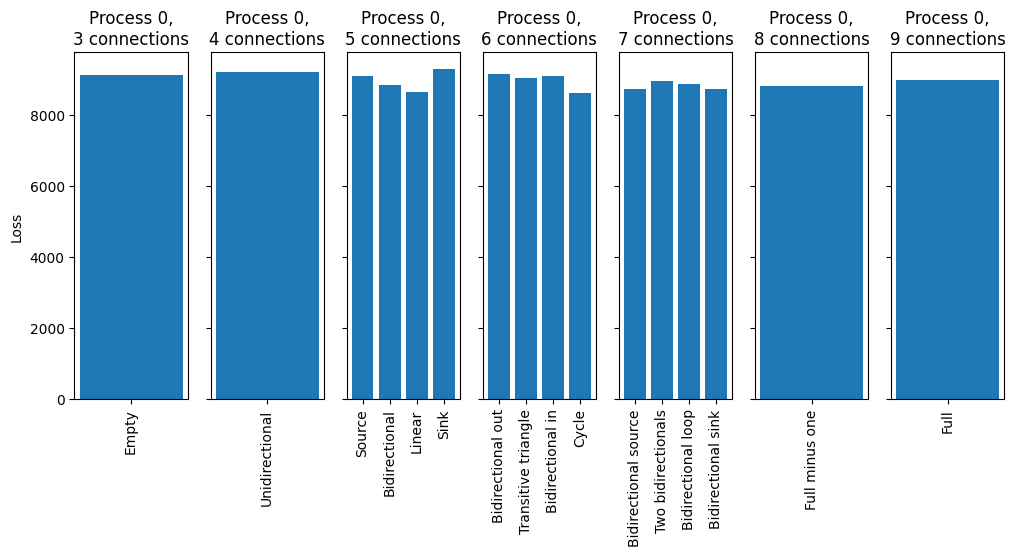

[{3: {'Empty': 9135.257787898885},
  4: {'Unidirectional': 9192.511363358693},
  5: {'Source': 9079.996621899594,
   'Bidirectional': 8843.49619383403,
   'Linear': 8639.989106161851,
   'Sink': 9293.017261493693},
  6: {'Bidirectional out': 9155.1756535262,
   'Transitive triangle': 9026.79544628623,
   'Bidirectional in': 9080.293546821476,
   'Cycle': 8610.225778758095},
  7: {'Bidirectional source': 8734.802169368784,
   'Two bidirectionals': 8943.121668521995,
   'Bidirectional loop': 8875.850448843159,
   'Bidirectional sink': 8736.5103548476},
  8: {'Full minus one': 8815.77125658364},
  9: {'Full': 8975.752931658688}}]

In [61]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 5e-7))),
           A=np.array([[0, 0, 0], [0.95, 0, 0], [0.95, -0.95, 0]]))

Process dynamics: [[0.   0.   0.95]
 [0.95 0.   0.  ]
 [0.   0.95 0.  ]]
Eigenvalues: [-0.475+0.82272413j -0.475-0.82272413j  0.95 +0.j        ]
Kalman filter M: [[0.         0.         0.60049406]
 [0.60049406 0.         0.        ]
 [0.         0.60049406 0.        ]]
Kalman filter K: [[0.36790099 0.         0.        ]
 [0.         0.36790099 0.        ]
 [0.         0.         0.36790099]]
Kalman filter loss: 8346.710417047478


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.08103336 0.         0.        ]
 [0.         0.05269593 0.        ]
 [0.         0.         0.12096704]]
NN K: [[0.59189774 0.09802247 0.10947225]
 [0.09302508 0.60517504 0.11768083]
 [0.04986913 0.11197392 0.61529123]]
Testing Empty, Trial 2
NN M: [[ 0.03711292  0.          0.        ]
 [ 0.          0.06083542  0.        ]
 [ 0.          0.         -0.01868772]]
NN K: [[0.6266623  0.1323911  0.05945715]
 [0.08416279 0.62100656 0.09454729]
 [0.13174399 0.06785732 0.64516251]]
Testing Empty, Trial 3


  6%|███▎                                                 | 1/16 [11:37<2:54:17, 697.18s/it]

NN M: [[0.06060313 0.         0.        ]
 [0.         0.10610566 0.        ]
 [0.         0.         0.05185611]]
NN K: [[0.56713154 0.12374861 0.12676806]
 [0.10202601 0.59733981 0.09036342]
 [0.06915705 0.108917   0.64497554]]
Testing Unidirectional, Trial 1
NN M: [[ 0.10236605  0.          0.        ]
 [ 0.07791458  0.22256088  0.        ]
 [ 0.          0.         -0.04130138]]
NN K: [[0.62108254 0.0448317  0.12596629]
 [0.13806929 0.51892564 0.00812947]
 [0.14576202 0.0705175  0.66156368]]
Testing Unidirectional, Trial 2
NN M: [[0.19965346 0.         0.        ]
 [0.27685229 0.05936973 0.        ]
 [0.         0.         0.09369322]]
NN K: [[ 0.60622774 -0.00359988  0.12690147]
 [ 0.09496472  0.49645619  0.03291338]
 [ 0.12987176  0.09416467  0.57129505]]
Testing Unidirectional, Trial 3


 12%|██████▋                                              | 2/16 [23:09<2:41:59, 694.24s/it]

NN M: [[ 0.01548662  0.          0.        ]
 [ 0.37862433  0.10126038  0.        ]
 [ 0.          0.         -0.06116209]]
NN K: [[0.69636305 0.07277526 0.07184356]
 [0.0887884  0.42956493 0.00937263]
 [0.15490907 0.09613693 0.62169763]]
Testing Source, Trial 1
NN M: [[ 0.01911732  0.          0.        ]
 [ 0.06562899  0.02396312  0.        ]
 [ 0.17375887  0.         -0.03581262]]
NN K: [[0.60633413 0.12640167 0.11074875]
 [0.08626585 0.63183011 0.09681923]
 [0.10093172 0.02346726 0.62580342]]
Testing Source, Trial 2
NN M: [[0.21158459 0.         0.        ]
 [0.14143222 0.06112593 0.        ]
 [0.14251296 0.         0.10798528]]
NN K: [[0.54720299 0.07329041 0.10564392]
 [0.04209637 0.5988101  0.08634059]
 [0.05046202 0.06838823 0.55521129]]
Testing Source, Trial 3


 19%|█████████▉                                           | 3/16 [34:43<2:30:22, 694.04s/it]

NN M: [[ 0.08795179  0.          0.        ]
 [ 0.19945092  0.14853123  0.        ]
 [ 0.00892736  0.         -0.05213771]]
NN K: [[ 0.65596637  0.05259379  0.08742533]
 [ 0.09693059  0.53822589 -0.01293455]
 [ 0.14826208  0.09734088  0.6222648 ]]
Testing Bidirectional, Trial 1
NN M: [[0.14933618 0.10651145 0.        ]
 [0.20817837 0.06905094 0.        ]
 [0.         0.         0.10350263]]
NN K: [[0.59828834 0.02085438 0.05812027]
 [0.0714872  0.53808908 0.07294035]
 [0.13215057 0.05773232 0.59699735]]
Testing Bidirectional, Trial 2
NN M: [[0.03153822 0.21790366 0.        ]
 [0.26608466 0.07033789 0.        ]
 [0.         0.         0.10567552]]
NN K: [[0.61142713 0.05892412 0.00091256]
 [0.00612329 0.50593637 0.12771363]
 [0.03189229 0.13038713 0.63086178]]
Testing Bidirectional, Trial 3


 25%|█████████████▎                                       | 4/16 [46:15<2:18:39, 693.25s/it]

NN M: [[0.0446517  0.12265165 0.        ]
 [0.27186454 0.02276586 0.        ]
 [0.         0.         0.07230872]]
NN K: [[0.65075058 0.03914533 0.05301501]
 [0.02267071 0.55506356 0.09553264]
 [0.1303133  0.08896766 0.58724495]]
Testing Linear, Trial 1
NN M: [[ 0.01808813  0.          0.        ]
 [ 0.11406025  0.17627872  0.        ]
 [ 0.          0.29595191 -0.09516041]]
NN K: [[0.63121149 0.1457873  0.05178931]
 [0.07253059 0.57358304 0.04466819]
 [0.09255225 0.05284513 0.56564238]]
Testing Linear, Trial 2
NN M: [[0.1204214  0.         0.        ]
 [0.05560459 0.10812699 0.        ]
 [0.         0.26866449 0.12570871]]
NN K: [[ 0.5581687   0.08371421  0.13649976]
 [ 0.10956641  0.62545552  0.04613031]
 [-0.04143023  0.11748048  0.49854028]]
Testing Linear, Trial 3


 31%|████████████████▌                                    | 5/16 [57:43<2:06:48, 691.64s/it]

NN M: [[-0.0808091   0.          0.        ]
 [ 0.19300991 -0.12682199  0.        ]
 [ 0.          0.27340041  0.13861187]]
NN K: [[ 0.64204156  0.18339633  0.06717569]
 [ 0.03181384  0.64898234  0.13735381]
 [-0.02477503  0.09717097  0.51200169]]
Testing Sink, Trial 1
NN M: [[ 0.02768207  0.          0.        ]
 [ 0.32969488  0.06611477 -0.00267989]
 [ 0.          0.          0.14570948]]
NN K: [[0.667937   0.07645347 0.11347429]
 [0.04118786 0.52184309 0.02303233]
 [0.06394889 0.12245758 0.58336206]]
Testing Sink, Trial 2
NN M: [[-0.05378015  0.          0.        ]
 [ 0.03812818 -0.04316816  0.10033839]
 [ 0.          0.          0.17263332]]
NN K: [[0.60685334 0.15406162 0.09403465]
 [0.05290014 0.6512833  0.11073014]
 [0.05774331 0.091889   0.60495898]]
Testing Sink, Trial 3


 38%|███████████████████▏                               | 6/16 [1:09:14<1:55:11, 691.17s/it]

NN M: [[ 0.05978406  0.          0.        ]
 [ 0.18989478  0.06939738  0.04835089]
 [ 0.          0.         -0.09935545]]
NN K: [[0.63626301 0.06067819 0.11573852]
 [0.05841096 0.55457596 0.0470051 ]
 [0.17753532 0.05730606 0.63201845]]
Testing Bidirectional out, Trial 1
NN M: [[0.11788329 0.14493945 0.        ]
 [0.23294844 0.0808142  0.        ]
 [0.11695066 0.         0.11838043]]
NN K: [[0.59003075 0.03682278 0.05299287]
 [0.0352505  0.52690039 0.08417377]
 [0.08887419 0.07456444 0.52203504]]
Testing Bidirectional out, Trial 2
NN M: [[ 0.02408006  0.12440031  0.        ]
 [ 0.12366305 -0.02822437  0.        ]
 [ 0.07322509  0.          0.13619871]]
NN K: [[0.59678687 0.11014504 0.06037358]
 [0.09321867 0.59220056 0.14717043]
 [0.03084638 0.10751542 0.58073466]]
Testing Bidirectional out, Trial 3


 44%|██████████████████████▎                            | 7/16 [1:21:32<1:45:59, 706.61s/it]

NN M: [[ 0.15499953  0.04072078  0.        ]
 [ 0.33330173  0.00897674  0.        ]
 [ 0.12771418  0.         -0.00166592]]
NN K: [[0.62658409 0.05656203 0.06195402]
 [0.05943996 0.52798285 0.02211647]
 [0.09582464 0.08365635 0.59191793]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.11871884  0.          0.        ]
 [ 0.32926966 -0.10167393  0.        ]
 [ 0.14866463  0.23437275  0.0280244 ]]
NN K: [[0.63824922 0.06065036 0.10920286]
 [0.02001314 0.57505595 0.11113987]
 [0.00184215 0.00168636 0.55424327]]
Testing Transitive triangle, Trial 2
NN M: [[ 0.16429632  0.          0.        ]
 [ 0.24482    -0.03654946  0.        ]
 [ 0.10150833  0.20821973 -0.05364355]]
NN K: [[0.61374734 0.07338243 0.08160251]
 [0.02261183 0.62129324 0.06444149]
 [0.1160898  0.05920636 0.53105279]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████▌                         | 8/16 [1:41:01<1:53:50, 853.87s/it]

NN M: [[ 0.03642869  0.          0.        ]
 [ 0.21007387 -0.00262079  0.        ]
 [-0.04570125  0.2593673   0.10587364]]
NN K: [[0.65945743 0.09329568 0.08709673]
 [0.07308114 0.60492232 0.06788879]
 [0.00964629 0.10551401 0.52274634]]
Testing Bidirectional in, Trial 1
NN M: [[0.01403956 0.06207657 0.24911139]
 [0.35881636 0.01173401 0.        ]
 [0.         0.         0.04715245]]
NN K: [[0.59201892 0.03384847 0.02441955]
 [0.06312781 0.44860991 0.07825814]
 [0.09743169 0.08157491 0.65098681]]
Testing Bidirectional in, Trial 2
NN M: [[0.20046288 0.11124559 0.10212995]
 [0.16560676 0.18753415 0.        ]
 [0.         0.         0.11474002]]
NN K: [[ 0.49113637 -0.01835272  0.08884496]
 [ 0.06258624  0.5080002   0.03464504]
 [ 0.08792177  0.09048264  0.60205886]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▋                      | 9/16 [2:01:49<1:53:59, 977.05s/it]

NN M: [[-0.00445034 -0.02412289  0.05351355]
 [ 0.24095686  0.05274524  0.        ]
 [ 0.          0.          0.10181971]]
NN K: [[0.6880722  0.11759559 0.08286513]
 [0.08675801 0.55582096 0.01457886]
 [0.08164056 0.10720151 0.59385385]]
Testing Cycle, Trial 1
NN M: [[-0.05909536  0.          0.40228997]
 [ 0.2939362  -0.02389679  0.        ]
 [ 0.          0.28380951  0.07570298]]
NN K: [[ 0.53089696  0.08274494  0.0023925 ]
 [ 0.0449863   0.57447973  0.0571489 ]
 [-0.0241355   0.05786638  0.5784563 ]]
Testing Cycle, Trial 2
NN M: [[0.04391497 0.         0.27643296]
 [0.38336891 0.04807838 0.        ]
 [0.         0.25082898 0.01831299]]
NN K: [[ 0.57983344 -0.0025809   0.0732932 ]
 [ 0.02883595  0.48429452  0.02144521]
 [ 0.08464883  0.0405789   0.55715088]]
Testing Cycle, Trial 3


 62%|██████████████████████████████▋                  | 10/16 [2:21:35<1:44:09, 1041.61s/it]

NN M: [[0.13357736 0.         0.2458855 ]
 [0.16636451 0.13915484 0.        ]
 [0.         0.2378345  0.03178592]]
NN K: [[ 0.50491428 -0.03780895  0.12183123]
 [ 0.10656715  0.58254106 -0.02665114]
 [ 0.08832122  0.05150856  0.54251525]]
Testing Bidirectional source, Trial 1
NN M: [[0.0396319  0.01796522 0.        ]
 [0.17780215 0.13723805 0.        ]
 [0.27288752 0.09969083 0.05065902]]
NN K: [[ 0.59611939  0.1811017   0.05512799]
 [ 0.11623828  0.51471343  0.01575707]
 [ 0.04785111 -0.00791627  0.51991835]]
Testing Bidirectional source, Trial 2
NN M: [[0.02819401 0.21106    0.        ]
 [0.30750691 0.1065606  0.        ]
 [0.07973695 0.07654592 0.07254085]]
NN K: [[0.5872615  0.07256391 0.01997321]
 [0.06642221 0.44016966 0.06564788]
 [0.08820564 0.03843092 0.58999367]]
Testing Bidirectional source, Trial 3


 69%|█████████████████████████████████▋               | 11/16 [2:41:58<1:31:24, 1096.95s/it]

NN M: [[-0.09229721  0.22228779  0.        ]
 [ 0.0944178   0.08506122  0.        ]
 [-0.01929854  0.20643102  0.05207063]]
NN K: [[0.59610092 0.11670592 0.0144135 ]
 [0.10857686 0.57375834 0.12325693]
 [0.05086262 0.04572225 0.59537006]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.00983699  0.01863707  0.16726972]
 [ 0.35557985  0.00868319  0.        ]
 [-0.01840453  0.          0.00293046]]
NN K: [[0.66625835 0.02357972 0.05645653]
 [0.07152718 0.48829595 0.0468887 ]
 [0.14822498 0.07683633 0.65931233]]
Testing Two bidirectionals, Trial 2
NN M: [[0.08148212 0.03820132 0.10852523]
 [0.17563843 0.01046134 0.        ]
 [0.00636069 0.         0.11491289]]
NN K: [[0.60950798 0.05313219 0.06697773]
 [0.07151744 0.60332101 0.07114052]
 [0.07123995 0.12576012 0.59353506]]
Testing Two bidirectionals, Trial 3


 75%|████████████████████████████████████▊            | 12/16 [3:01:44<1:14:56, 1124.16s/it]

NN M: [[0.04487498 0.15047349 0.11843228]
 [0.16591662 0.17939529 0.        ]
 [0.11588695 0.         0.07947213]]
NN K: [[0.59303441 0.04509519 0.010044  ]
 [0.07192998 0.52340416 0.02370213]
 [0.08700433 0.03256756 0.59217227]]
Testing Bidirectional loop, Trial 1
NN M: [[0.15741498 0.08637141 0.        ]
 [0.09733162 0.06916716 0.25770289]
 [0.13979836 0.         0.11272034]]
NN K: [[0.55518772 0.04427793 0.09084342]
 [0.02309209 0.50707982 0.02551442]
 [0.12368931 0.0201405  0.53472253]]
Testing Bidirectional loop, Trial 2
NN M: [[ 0.21635411 -0.07811619  0.        ]
 [ 0.36124795 -0.01053922  0.11825771]
 [-0.02317884  0.          0.20663634]]
NN K: [[ 0.62945631  0.01392518  0.13687061]
 [ 0.07153949  0.43768726 -0.0042108 ]
 [ 0.11391598  0.135695    0.49686034]]
Testing Bidirectional loop, Trial 3


 81%|█████████████████████████████████████████▍         | 13/16 [3:22:59<58:29, 1169.86s/it]

NN M: [[ 0.05509657  0.14900639  0.        ]
 [ 0.16641565  0.00803398  0.17128584]
 [-0.01888032  0.          0.06319563]]
NN K: [[ 0.63148508  0.01792405  0.05017952]
 [-0.00839967  0.55298793  0.1005986 ]
 [ 0.14220022  0.10105259  0.60592328]]
Testing Bidirectional sink, Trial 1
NN M: [[ 0.12286492  0.          0.        ]
 [ 0.27553173 -0.00683494  0.10110058]
 [ 0.16168941  0.20806949 -0.04960065]]
NN K: [[ 0.58008891  0.11506152  0.1037956 ]
 [-0.00482519  0.54918974  0.04096665]
 [ 0.11026698  0.01400523  0.52508817]]
Testing Bidirectional sink, Trial 2
NN M: [[-0.00090361  0.          0.        ]
 [ 0.02312564  0.19647148  0.06470268]
 [-0.0247549   0.26790047 -0.11193991]]
NN K: [[0.60189668 0.12942213 0.10686632]
 [0.07598433 0.57943085 0.03045989]
 [0.14798794 0.04909749 0.57932536]]
Testing Bidirectional sink, Trial 3


 88%|████████████████████████████████████████████▋      | 14/16 [3:44:45<40:21, 1210.81s/it]

NN M: [[ 0.19166874  0.          0.        ]
 [ 0.22604649 -0.11620498  0.16177169]
 [ 0.10878173  0.18405869  0.03521208]]
NN K: [[0.61789662 0.04005835 0.07817546]
 [0.00461165 0.5480559  0.10557171]
 [0.08829345 0.01460605 0.54056798]]
Testing Full minus one, Trial 1
NN M: [[ 0.10089554 -0.02678033  0.27041145]
 [ 0.05693905  0.24276429  0.        ]
 [ 0.07517003  0.18813703  0.04466163]]
NN K: [[0.50449902 0.03861999 0.07081987]
 [0.06643626 0.58342009 0.00748498]
 [0.03591843 0.04762447 0.56631506]]
Testing Full minus one, Trial 2
NN M: [[-0.05271954  0.11438147  0.29287676]
 [ 0.19759569 -0.05506803  0.        ]
 [-0.0379574   0.20326023  0.1505119 ]]
NN K: [[ 0.5471786   0.0588467  -0.01075625]
 [ 0.06486543  0.61384578  0.11756971]
 [ 0.01407618  0.07732244  0.56659334]]
Testing Full minus one, Trial 3


 94%|███████████████████████████████████████████████▊   | 15/16 [4:05:47<20:26, 1226.35s/it]

NN M: [[ 0.16679547  0.09519923  0.28530533]
 [ 0.3398342   0.016867    0.        ]
 [ 0.20265761  0.14093324 -0.0368239 ]]
NN K: [[ 0.49849234 -0.01424014 -0.02788168]
 [ 0.03513207  0.5075139   0.037839  ]
 [ 0.04498267 -0.03512759  0.61513401]]
Testing Full, Trial 1
NN M: [[0.03718931 0.09596832 0.18517731]
 [0.21181787 0.16981718 0.01373606]
 [0.07851262 0.1483124  0.08196519]]
NN K: [[0.58254611 0.050458   0.00861361]
 [0.03938941 0.50223222 0.02961999]
 [0.02842949 0.03723719 0.57813768]]
Testing Full, Trial 2
NN M: [[-0.03509354  0.07420212  0.32343474]
 [ 0.29251525 -0.04816096 -0.08999597]
 [ 0.00771885  0.37950905 -0.02536995]]
NN K: [[0.52698524 0.07873439 0.01907698]
 [0.08131444 0.6036165  0.09121299]
 [0.02764969 0.01743687 0.54995068]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 16/16 [4:25:03<00:00, 993.97s/it]

NN M: [[-0.12130593 -0.02897516  0.26274806]
 [ 0.14375412  0.04052009 -0.00946287]
 [ 0.01124599  0.28182751  0.1005967 ]]
NN K: [[ 0.58746831  0.14981261  0.04564803]
 [ 0.09306598  0.6564158   0.01951874]
 [-0.00547371  0.078051    0.52407635]]


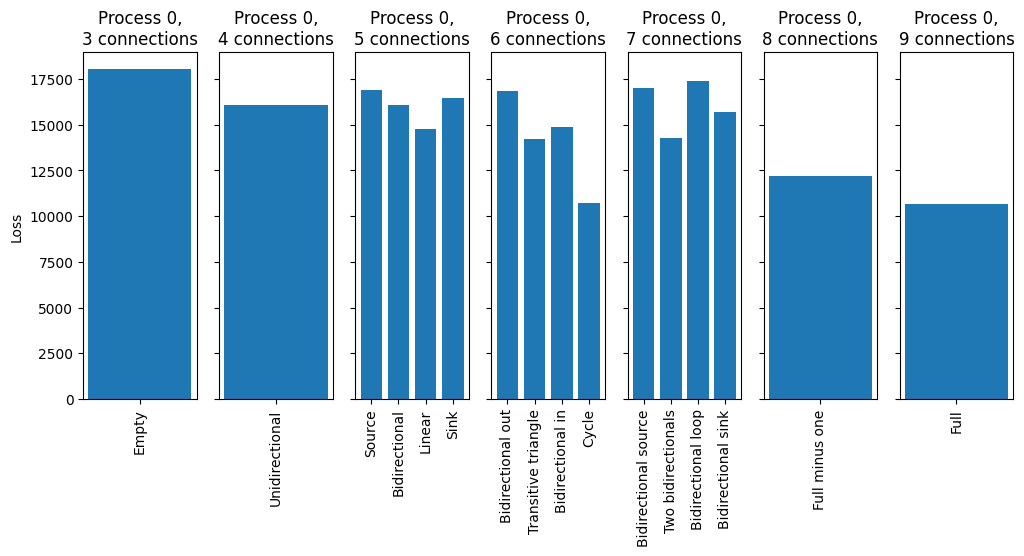

[{3: {'Empty': 18055.641145590445},
  4: {'Unidirectional': 16073.855214928251},
  5: {'Source': 16923.37288943385,
   'Bidirectional': 16087.294212130957,
   'Linear': 14784.918599659275,
   'Sink': 16472.31754131239},
  6: {'Bidirectional out': 16859.21114204228,
   'Transitive triangle': 14222.087539638736,
   'Bidirectional in': 14858.095941283134,
   'Cycle': 10693.860487574866},
  7: {'Bidirectional source': 17015.153805152233,
   'Two bidirectionals': 14257.763094334568,
   'Bidirectional loop': 17406.057986239106,
   'Bidirectional sink': 15715.708323235496},
  8: {'Full minus one': 12194.737594040209},
  9: {'Full': 10662.946357254828}}]

In [62]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(20, 1e-9))),
           A=np.array([[0, 0, 0.95], [0.95, 0, 0], [0, 0.95, 0]]))

Process dynamics: [[0.  0.4 0.5]
 [0.5 0.  0.4]
 [0.4 0.5 0. ]]
Eigenvalues: [ 0.9 +0.j         -0.45+0.08660254j -0.45-0.08660254j]
Kalman filter M: [[-0.0351183   0.27299045  0.35001764]
 [ 0.35001764 -0.0351183   0.27299045]
 [ 0.27299045  0.35001764 -0.0351183 ]]
Kalman filter K: [[0.26874846 0.03902033 0.03902033]
 [0.03902033 0.26874846 0.03902033]
 [0.03902033 0.03902033 0.26874846]]
Kalman filter loss: 6249.283551748485


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.12893375 0.         0.        ]
 [0.         0.05176448 0.        ]
 [0.         0.         0.1524664 ]]
NN K: [[0.23589346 0.15882834 0.11457292]
 [0.11401194 0.23451561 0.14269214]
 [0.08477132 0.13888051 0.24769364]]
Testing Empty, Trial 2
NN M: [[ 0.16668428  0.          0.        ]
 [ 0.          0.02567744  0.        ]
 [ 0.          0.         -0.01365091]]
NN K: [[0.24829636 0.17443197 0.09723141]
 [0.09170285 0.21852615 0.14879835]
 [0.15633828 0.13438041 0.20719443]]
Testing Empty, Trial 3


  6%|███▎                                                | 1/16 [18:22<4:35:34, 1102.28s/it]

NN M: [[ 0.00266274  0.          0.        ]
 [ 0.          0.06002059  0.        ]
 [ 0.          0.         -0.03360707]]
NN K: [[0.22497521 0.10315487 0.16751777]
 [0.12026075 0.24948475 0.11800101]
 [0.09543235 0.12150797 0.24560082]]
Testing Unidirectional, Trial 1
NN M: [[0.00350514 0.         0.        ]
 [0.02130561 0.08463442 0.        ]
 [0.         0.         0.07042986]]
NN K: [[0.26774888 0.11159371 0.11302004]
 [0.15681664 0.24308053 0.0904821 ]
 [0.1501802  0.09522683 0.22156451]]
Testing Unidirectional, Trial 2
NN M: [[0.02188118 0.         0.        ]
 [0.09964299 0.03899439 0.        ]
 [0.         0.         0.00760936]]
NN K: [[0.27480542 0.11402398 0.11031925]
 [0.11979399 0.23887753 0.1354554 ]
 [0.11121822 0.13696653 0.22362315]]
Testing Unidirectional, Trial 3


 12%|██████▌                                             | 2/16 [39:52<4:42:56, 1212.63s/it]

NN M: [[0.10876903 0.         0.        ]
 [0.02811432 0.09649943 0.        ]
 [0.         0.         0.00650173]]
NN K: [[0.26668886 0.13324297 0.13629116]
 [0.1775371  0.19551319 0.13637406]
 [0.13410597 0.08937204 0.22965114]]
Testing Source, Trial 1
NN M: [[0.08510623 0.         0.        ]
 [0.04064712 0.02002656 0.        ]
 [0.1074885  0.         0.07806385]]
NN K: [[0.23794714 0.13119207 0.12467185]
 [0.13172882 0.25799778 0.10540412]
 [0.18224863 0.11338517 0.18836298]]
Testing Source, Trial 2
NN M: [[-0.1090711   0.          0.        ]
 [-0.05253994  0.07096076  0.        ]
 [ 0.08033446  0.          0.09547249]]
NN K: [[0.22982698 0.10121747 0.10388473]
 [0.11816071 0.22941239 0.16263084]
 [0.13490465 0.11610508 0.23669464]]
Testing Source, Trial 3


 19%|█████████▍                                        | 3/16 [1:18:13<6:10:24, 1709.61s/it]

NN M: [[-0.02111795  0.          0.        ]
 [ 0.03095023  0.16331115  0.        ]
 [ 0.05946186  0.          0.07787325]]
NN K: [[0.22520499 0.13326708 0.14817903]
 [0.10937009 0.27970828 0.13369666]
 [0.12550121 0.12400756 0.20238921]]
Testing Bidirectional, Trial 1
NN M: [[-0.00914279  0.0516272   0.        ]
 [ 0.06399958  0.00124816  0.        ]
 [ 0.          0.         -0.0196491 ]]
NN K: [[0.23835967 0.13624063 0.12035194]
 [0.15525692 0.20094855 0.11116604]
 [0.15470265 0.09878336 0.23409215]]
Testing Bidirectional, Trial 2
NN M: [[-0.04642823  0.10393253  0.        ]
 [ 0.02150476  0.09490128  0.        ]
 [ 0.          0.          0.05484041]]
NN K: [[0.23837593 0.10592306 0.15898155]
 [0.11734472 0.24782566 0.18033745]
 [0.11274419 0.14848837 0.19618787]]
Testing Bidirectional, Trial 3


 25%|████████████▌                                     | 4/16 [1:38:19<5:02:10, 1510.90s/it]

NN M: [[0.13326152 0.03133152 0.        ]
 [0.05839197 0.08577149 0.        ]
 [0.         0.         0.06948431]]
NN K: [[0.27639014 0.1520222  0.07469402]
 [0.14375646 0.23455633 0.1213543 ]
 [0.18093431 0.105025   0.20255402]]
Testing Linear, Trial 1
NN M: [[ 0.10131572  0.          0.        ]
 [ 0.02110214 -0.02385196  0.        ]
 [ 0.         -0.03641633  0.04269264]]
NN K: [[0.20423462 0.15352795 0.10467654]
 [0.07446307 0.25754337 0.13536246]
 [0.09882859 0.12078037 0.25942514]]
Testing Linear, Trial 2
NN M: [[0.08290661 0.         0.        ]
 [0.07808093 0.11428506 0.        ]
 [0.         0.0172896  0.03658184]]
NN K: [[0.24663675 0.1694958  0.11771724]
 [0.14672186 0.24428451 0.11155062]
 [0.15475929 0.15644659 0.19683594]]
Testing Linear, Trial 3


 31%|███████████████▋                                  | 5/16 [1:57:07<4:11:42, 1372.94s/it]

NN M: [[-0.04661122  0.          0.        ]
 [ 0.01995766 -0.03574025  0.        ]
 [ 0.         -0.00062727  0.01864755]]
NN K: [[0.18480391 0.13586071 0.14802281]
 [0.10974089 0.2092895  0.13111117]
 [0.11379855 0.1204893  0.24900561]]
Testing Sink, Trial 1
NN M: [[ 0.08269985  0.          0.        ]
 [ 0.05124998  0.06359471  0.00058881]
 [ 0.          0.         -0.01539225]]
NN K: [[0.21063892 0.13637247 0.14066153]
 [0.12969649 0.26442204 0.12452187]
 [0.123359   0.11671183 0.22338093]]
Testing Sink, Trial 2
NN M: [[0.05111951 0.         0.        ]
 [0.03403867 0.051739   0.07886673]
 [0.         0.         0.01602543]]
NN K: [[0.24515661 0.14220361 0.1334661 ]
 [0.11553692 0.2328236  0.11452265]
 [0.10638164 0.10196384 0.26445738]]
Testing Sink, Trial 3


 38%|██████████████████▊                               | 6/16 [2:14:01<3:28:28, 1250.86s/it]

NN M: [[ 0.05941178  0.          0.        ]
 [-0.01540596  0.07255345  0.07090262]
 [ 0.          0.          0.00892677]]
NN K: [[0.234188   0.12402403 0.12359355]
 [0.1265197  0.29002702 0.10643653]
 [0.14372045 0.09159692 0.24147321]]
Testing Bidirectional out, Trial 1
NN M: [[0.12646779 0.13745381 0.        ]
 [0.07551937 0.04542507 0.        ]
 [0.03154146 0.         0.01211408]]
NN K: [[0.20817378 0.09211112 0.19309073]
 [0.14963614 0.24082362 0.13487124]
 [0.11104454 0.12456083 0.2288977 ]]
Testing Bidirectional out, Trial 2
NN M: [[0.11465918 0.0997408  0.        ]
 [0.0843295  0.05429608 0.        ]
 [0.11129156 0.         0.06929351]]
NN K: [[0.27064465 0.10963493 0.11615777]
 [0.14804767 0.23938836 0.14245886]
 [0.15574656 0.16142754 0.19586473]]
Testing Bidirectional out, Trial 3


 44%|█████████████████████▉                            | 7/16 [2:30:13<2:53:56, 1159.62s/it]

NN M: [[0.04766044 0.01331325 0.        ]
 [0.06377704 0.05600034 0.        ]
 [0.13788198 0.         0.01862692]]
NN K: [[0.2444168  0.16166471 0.13110877]
 [0.11247794 0.22095875 0.12885333]
 [0.11502441 0.09523538 0.23126043]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.1234424   0.          0.        ]
 [-0.01637029  0.00666367  0.        ]
 [ 0.08166002  0.0092619   0.08527699]]
NN K: [[0.2432462  0.1167326  0.13957348]
 [0.13985981 0.21594681 0.14070881]
 [0.13093049 0.10686751 0.26630348]]
Testing Transitive triangle, Trial 2
NN M: [[ 0.07642429  0.          0.        ]
 [ 0.05143855 -0.06382511  0.        ]
 [ 0.09282157 -0.02616091  0.15717233]]
NN K: [[0.2540021  0.15691737 0.11773492]
 [0.095437   0.25345531 0.12458825]
 [0.14537052 0.1138461  0.22219897]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████                         | 8/16 [2:46:29<2:26:48, 1101.10s/it]

NN M: [[-0.08006229  0.          0.        ]
 [ 0.03766364  0.04915611  0.        ]
 [-0.01441965  0.11892025  0.1799515 ]]
NN K: [[0.27086597 0.08567666 0.07735213]
 [0.09004544 0.26269968 0.14401015]
 [0.16927911 0.0852452  0.25085944]]
Testing Bidirectional in, Trial 1
NN M: [[ 0.02376474  0.02892398  0.00857967]
 [-0.01617821  0.00929215  0.        ]
 [ 0.          0.         -0.00876775]]
NN K: [[0.23375927 0.14077529 0.11181294]
 [0.13053726 0.21622244 0.14156808]
 [0.14288343 0.11607775 0.19575585]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.10617459  0.03150964  0.03731403]
 [-0.00899568  0.09831569  0.        ]
 [ 0.          0.          0.09124682]]
NN K: [[0.23320602 0.13859962 0.12799965]
 [0.13184713 0.23085378 0.17105849]
 [0.12357774 0.11969492 0.23880735]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▏                     | 9/16 [3:02:43<2:03:49, 1061.31s/it]

NN M: [[0.11686281 0.0842405  0.15916245]
 [0.09620302 0.06893987 0.        ]
 [0.         0.         0.08302927]]
NN K: [[0.24259389 0.07672197 0.13635287]
 [0.156902   0.20006594 0.14929755]
 [0.11849878 0.15813836 0.26827515]]
Testing Cycle, Trial 1
NN M: [[0.07331794 0.         0.0171381 ]
 [0.01332062 0.0989625  0.        ]
 [0.         0.13008439 0.12433469]]
NN K: [[0.25100168 0.11208706 0.11335653]
 [0.13328237 0.24739207 0.14297714]
 [0.09621929 0.14151382 0.22395181]]
Testing Cycle, Trial 2
NN M: [[0.08282779 0.         0.07615154]
 [0.06419612 0.11416875 0.        ]
 [0.         0.06855623 0.08177973]]
NN K: [[0.25061681 0.09624831 0.14508748]
 [0.16898321 0.23687881 0.13104517]
 [0.07925891 0.14436367 0.2587379 ]]
Testing Cycle, Trial 3


 62%|██████████████████████████████▋                  | 10/16 [3:20:01<1:45:25, 1054.31s/it]

NN M: [[0.03370354 0.         0.05730799]
 [0.05383684 0.02656786 0.        ]
 [0.         0.05140142 0.01827083]]
NN K: [[0.23224576 0.14545197 0.14064005]
 [0.11362587 0.24734287 0.13139852]
 [0.11111148 0.15528902 0.19303143]]
Testing Bidirectional source, Trial 1
NN M: [[0.07875362 0.10440282 0.        ]
 [0.08433022 0.13305413 0.        ]
 [0.10033816 0.06637573 0.075508  ]]
NN K: [[0.19454755 0.16737878 0.1278106 ]
 [0.09863128 0.26052573 0.14761094]
 [0.11636038 0.13053425 0.20758607]]
Testing Bidirectional source, Trial 2
NN M: [[-0.06531138 -0.01028109  0.        ]
 [-0.04526122  0.01157175  0.        ]
 [ 0.0434359   0.03598159  0.05909587]]
NN K: [[0.19065866 0.15686239 0.10213683]
 [0.11439433 0.22627245 0.12227179]
 [0.1630795  0.10312054 0.24507166]]
Testing Bidirectional source, Trial 3


 69%|█████████████████████████████████▋               | 11/16 [3:38:03<1:28:33, 1062.75s/it]

NN M: [[0.02690719 0.11104877 0.        ]
 [0.10171401 0.04304026 0.        ]
 [0.08720757 0.05827453 0.01242955]]
NN K: [[0.24399619 0.13841582 0.13900043]
 [0.15642807 0.20333193 0.13549733]
 [0.12203363 0.10911634 0.2360632 ]]
Testing Two bidirectionals, Trial 1
NN M: [[0.02805423 0.09820821 0.027061  ]
 [0.06174311 0.08110307 0.        ]
 [0.16546539 0.         0.08018535]]
NN K: [[0.30339394 0.10493387 0.13190255]
 [0.09876274 0.2178786  0.16778673]
 [0.1071881  0.10376391 0.24464126]]
Testing Two bidirectionals, Trial 2
NN M: [[ 0.0484857   0.05957653  0.09116134]
 [ 0.03707305 -0.02788377  0.        ]
 [ 0.03737146  0.          0.06861234]]
NN K: [[0.19787711 0.15842891 0.10846038]
 [0.08858343 0.26067735 0.1119824 ]
 [0.14879586 0.11354241 0.25669572]]
Testing Two bidirectionals, Trial 3


 75%|████████████████████████████████████▊            | 12/16 [4:02:17<1:18:46, 1181.63s/it]

NN M: [[ 0.13874625 -0.04352692 -0.00905544]
 [ 0.03782986  0.05397736  0.        ]
 [ 0.01981344  0.          0.06556664]]
NN K: [[0.22970391 0.1635896  0.14766206]
 [0.14793417 0.21949635 0.10396653]
 [0.09644305 0.14040908 0.24314039]]
Testing Bidirectional loop, Trial 1
NN M: [[ 0.05387119  0.05158809  0.        ]
 [ 0.09195593 -0.02025098  0.03878311]
 [ 0.07801685  0.          0.01823696]]
NN K: [[0.24680631 0.15721549 0.10781704]
 [0.13769165 0.22428105 0.091467  ]
 [0.1302072  0.10584077 0.23842657]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.02226462  0.07892902  0.        ]
 [ 0.08270826  0.06058117  0.03597649]
 [ 0.11087917  0.          0.0452019 ]]
NN K: [[0.28828653 0.13302446 0.13274861]
 [0.12221711 0.22112145 0.1201818 ]
 [0.13654215 0.06586306 0.24395105]]
Testing Bidirectional loop, Trial 3


 81%|███████████████████████████████████████▊         | 13/16 [4:31:41<1:07:54, 1358.26s/it]

NN M: [[0.10552241 0.0911238  0.        ]
 [0.08337936 0.04113396 0.04749269]
 [0.07343736 0.         0.06175996]]
NN K: [[0.19814495 0.14958983 0.19001133]
 [0.13249752 0.22626212 0.13935249]
 [0.09839973 0.14910298 0.25951914]]
Testing Bidirectional sink, Trial 1
NN M: [[ 0.00716895  0.          0.        ]
 [-0.00153427  0.04033554  0.13900224]
 [ 0.01600417  0.10986753  0.06733576]]
NN K: [[0.19471276 0.14040683 0.14637373]
 [0.12100128 0.20181183 0.16357484]
 [0.14317408 0.15537571 0.22038384]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.16014791  0.          0.        ]
 [ 0.07687748  0.05057424 -0.00085164]
 [ 0.05480767  0.04906823  0.03068211]]
NN K: [[0.20778528 0.13059573 0.17138203]
 [0.14240382 0.26663492 0.0707801 ]
 [0.05804185 0.16272407 0.23556338]]
Testing Bidirectional sink, Trial 3


 88%|████████████████████████████████████████████▋      | 14/16 [5:01:16<49:27, 1483.91s/it]

NN M: [[0.06758296 0.         0.        ]
 [0.07501115 0.1389463  0.00901469]
 [0.03855724 0.13811323 0.01277525]]
NN K: [[0.28991827 0.09435845 0.12636681]
 [0.1549465  0.26304909 0.08188722]
 [0.07949399 0.13693825 0.22746846]]
Testing Full minus one, Trial 1
NN M: [[ 0.02131051  0.02721358  0.09478498]
 [-0.03013506  0.02271578  0.        ]
 [ 0.05369921  0.04174406  0.06290657]]
NN K: [[0.2187581  0.130602   0.13978874]
 [0.16213957 0.20657967 0.11142388]
 [0.11622181 0.09707523 0.26427467]]
Testing Full minus one, Trial 2
NN M: [[ 0.02261434  0.08893601  0.01949852]
 [ 0.1064501   0.09809579  0.        ]
 [ 0.06927058  0.06599117 -0.08574419]]
NN K: [[0.23867135 0.14422017 0.14064257]
 [0.14074344 0.24973203 0.11662688]
 [0.14898917 0.1015711  0.22121708]]
Testing Full minus one, Trial 3


 94%|███████████████████████████████████████████████▊   | 15/16 [5:32:31<26:41, 1601.84s/it]

NN M: [[0.04137249 0.04145267 0.0382811 ]
 [0.0466137  0.02375025 0.        ]
 [0.05765293 0.17616208 0.03020845]]
NN K: [[0.23314739 0.13102566 0.15769883]
 [0.09589855 0.27203051 0.15458595]
 [0.10945881 0.10894089 0.21984959]]
Testing Full, Trial 1
NN M: [[ 0.10833384  0.08920478  0.03195002]
 [-0.05352765  0.02381467 -0.00419576]
 [ 0.02503487  0.03706381  0.07438501]]
NN K: [[0.20971218 0.12268423 0.11421948]
 [0.13165338 0.25615753 0.17584961]
 [0.12427164 0.13375829 0.22422613]]
Testing Full, Trial 2
NN M: [[ 0.1386877  -0.02076802  0.09803802]
 [ 0.12219534 -0.01630181  0.12858107]
 [ 0.13443443  0.07847991  0.0478113 ]]
NN K: [[0.25304172 0.15751127 0.14543237]
 [0.1021467  0.20606128 0.12016501]
 [0.1258659  0.11078887 0.27514086]]
Testing Full, Trial 3


100%|███████████████████████████████████████████████████| 16/16 [6:03:48<00:00, 1364.30s/it]

NN M: [[ 0.06016473 -0.01506465  0.10393087]
 [ 0.04649875  0.05819436  0.13122006]
 [ 0.05982065  0.02042296  0.10599035]]
NN K: [[0.20629123 0.14727639 0.14427807]
 [0.08409197 0.18742974 0.14621376]
 [0.10225542 0.13976957 0.27029689]]


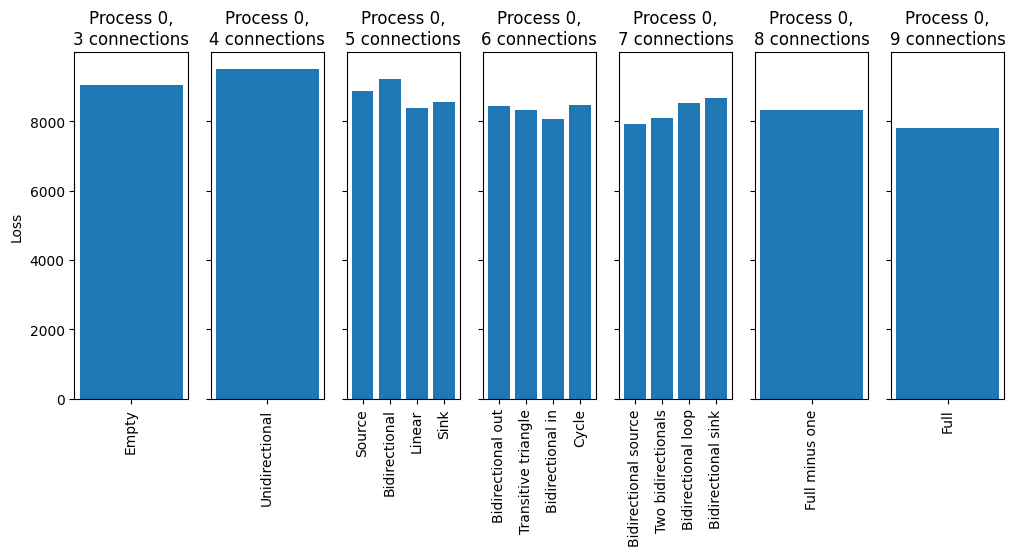

[{3: {'Empty': 9059.037916506219},
  4: {'Unidirectional': 9509.253436638039},
  5: {'Source': 8882.187737020748,
   'Bidirectional': 9220.473184276309,
   'Linear': 8374.64557914076,
   'Sink': 8549.045238306226},
  6: {'Bidirectional out': 8442.162134102147,
   'Transitive triangle': 8335.517165629239,
   'Bidirectional in': 8058.308926554016,
   'Cycle': 8480.869542009023},
  7: {'Bidirectional source': 7934.762202477378,
   'Two bidirectionals': 8091.454549946313,
   'Bidirectional loop': 8516.789917191778,
   'Bidirectional sink': 8657.760098584293},
  8: {'Full minus one': 8332.296406446141},
  9: {'Full': 7811.167533297953}}]

In [63]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 8e-8))),
           A=np.array([[0, 0.4, 0.5], [0.5, 0, 0.4], [0.4, 0.5, 0]]))

Process dynamics: [[0.  0.5 0.4]
 [0.5 0.  0.3]
 [0.4 0.6 0. ]]
Eigenvalues: [ 0.89007333+0.j         -0.44503666+0.06459796j -0.44503666-0.06459796j]
Kalman filter M: [[-0.03428466  0.33538319  0.28462765]
 [ 0.35492483 -0.03629621  0.21092639]
 [ 0.26929034  0.40644995 -0.03174902]]
Kalman filter K: [[0.26774713 0.02757833 0.05123873]
 [0.02757833 0.26014094 0.03751174]
 [0.05123873 0.03751174 0.27988447]]
Kalman filter loss: 6053.176889177274


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.17003763  0.          0.        ]
 [ 0.         -0.03658298  0.        ]
 [ 0.          0.         -0.00493527]]
NN K: [[0.21069069 0.10301783 0.12243628]
 [0.13404798 0.21100264 0.08407641]
 [0.11790757 0.11499651 0.27703485]]
Testing Empty, Trial 2
NN M: [[0.00798933 0.         0.        ]
 [0.         0.04574274 0.        ]
 [0.         0.         0.0150609 ]]
NN K: [[0.10967795 0.14188199 0.12911274]
 [0.08964476 0.17172636 0.12546806]
 [0.18025093 0.09887299 0.21797415]]
Testing Empty, Trial 3


  6%|███▎                                                | 1/16 [29:48<7:27:12, 1788.81s/it]

NN M: [[ 0.00085161  0.          0.        ]
 [ 0.         -0.00189486  0.        ]
 [ 0.          0.          0.08791267]]
NN K: [[0.19793949 0.14472321 0.09799263]
 [0.11573541 0.15241869 0.09767263]
 [0.16011767 0.08791581 0.24070414]]
Testing Unidirectional, Trial 1
NN M: [[ 0.12118211  0.          0.        ]
 [-0.01355639  0.08311504  0.        ]
 [ 0.          0.          0.20019843]]
NN K: [[0.24381535 0.10522125 0.09332476]
 [0.08458919 0.22513929 0.15139059]
 [0.11968298 0.15329545 0.21985308]]
Testing Unidirectional, Trial 2
NN M: [[-0.02626844  0.          0.        ]
 [ 0.04493421  0.05221286  0.        ]
 [ 0.          0.          0.02412292]]
NN K: [[0.20770789 0.14499422 0.1387732 ]
 [0.09619737 0.15628984 0.17235761]
 [0.13627194 0.08908982 0.24956678]]
Testing Unidirectional, Trial 3


 12%|██████▌                                             | 2/16 [58:26<6:47:35, 1746.83s/it]

NN M: [[0.07519858 0.         0.        ]
 [0.03487048 0.11078196 0.        ]
 [0.         0.         0.16643781]]
NN K: [[0.21957045 0.10192914 0.13443333]
 [0.09361932 0.19572963 0.1210381 ]
 [0.11987909 0.10894565 0.24765028]]
Testing Source, Trial 1
NN M: [[ 0.13993802  0.          0.        ]
 [ 0.02310639 -0.03875162  0.        ]
 [ 0.04542168  0.          0.01783362]]
NN K: [[0.20958315 0.10669841 0.12564016]
 [0.1283206  0.17125652 0.10140767]
 [0.11180859 0.0690671  0.25077846]]
Testing Source, Trial 2
NN M: [[-0.00488924  0.          0.        ]
 [ 0.02863073  0.04776106  0.        ]
 [-0.01008962  0.          0.09109538]]
NN K: [[0.1930534  0.11399983 0.12598927]
 [0.05706752 0.25328757 0.10457869]
 [0.14017057 0.11917749 0.23454883]]
Testing Source, Trial 3


 19%|█████████▍                                        | 3/16 [1:26:40<6:13:14, 1722.64s/it]

NN M: [[-0.02955344  0.          0.        ]
 [ 0.00922742 -0.02566985  0.        ]
 [ 0.02326298  0.         -0.05536933]]
NN K: [[0.21430772 0.10830491 0.05407087]
 [0.0923052  0.22590354 0.0779308 ]
 [0.08110797 0.12088638 0.25402798]]
Testing Bidirectional, Trial 1
NN M: [[0.04619485 0.05017012 0.        ]
 [0.15244432 0.09280872 0.        ]
 [0.         0.         0.03070861]]
NN K: [[0.24660833 0.0850746  0.11858302]
 [0.09475071 0.20829255 0.11161484]
 [0.13626755 0.07109336 0.26882834]]
Testing Bidirectional, Trial 2
NN M: [[ 0.05341252 -0.05863177  0.        ]
 [ 0.05820104 -0.01596079  0.        ]
 [ 0.          0.          0.05053302]]
NN K: [[0.28706408 0.06856684 0.1038761 ]
 [0.06857865 0.20958313 0.09474285]
 [0.16082322 0.17055543 0.20316597]]
Testing Bidirectional, Trial 3


 25%|████████████▌                                     | 4/16 [1:44:40<4:53:50, 1469.25s/it]

NN M: [[ 0.17008663  0.10205682  0.        ]
 [ 0.16429043  0.07516906  0.        ]
 [ 0.          0.         -0.05824048]]
NN K: [[0.23542723 0.11992336 0.11344636]
 [0.09256953 0.16909974 0.10572442]
 [0.08149251 0.11956365 0.24137382]]
Testing Linear, Trial 1
NN M: [[ 0.07590578  0.          0.        ]
 [-0.046758    0.01386651  0.        ]
 [ 0.          0.03079325  0.08549049]]
NN K: [[0.23502718 0.06306462 0.11947527]
 [0.065874   0.22419486 0.14217537]
 [0.12066297 0.10117493 0.27684845]]
Testing Linear, Trial 2
NN M: [[0.00686289 0.         0.        ]
 [0.07531249 0.10682908 0.        ]
 [0.         0.05118713 0.02489162]]
NN K: [[0.23889658 0.14532204 0.06459003]
 [0.08024091 0.26061156 0.11203714]
 [0.12532945 0.07144998 0.27036217]]
Testing Linear, Trial 3


 31%|███████████████▋                                  | 5/16 [2:01:29<3:58:56, 1303.31s/it]

NN M: [[ 0.0962978   0.          0.        ]
 [ 0.04283199 -0.00745903  0.        ]
 [ 0.          0.11271458  0.11230755]]
NN K: [[0.25304249 0.11735554 0.07458435]
 [0.09936738 0.20517088 0.15670187]
 [0.18400971 0.07236551 0.21158161]]
Testing Sink, Trial 1
NN M: [[0.09619114 0.         0.        ]
 [0.01044916 0.01970289 0.03106188]
 [0.         0.         0.05582318]]
NN K: [[0.20494132 0.06425213 0.14521858]
 [0.04219191 0.21746843 0.10976706]
 [0.1777795  0.10592778 0.17284102]]
Testing Sink, Trial 2
NN M: [[-0.0250288   0.          0.        ]
 [ 0.07713968  0.08326663  0.03351666]
 [ 0.          0.         -0.07353869]]
NN K: [[0.21920747 0.11982561 0.08788638]
 [0.06850208 0.1967154  0.12944173]
 [0.1364878  0.10854922 0.24241429]]
Testing Sink, Trial 3


 38%|██████████████████▊                               | 6/16 [2:17:11<3:16:43, 1180.40s/it]

NN M: [[ 0.01625649  0.          0.        ]
 [-0.0305414   0.007032    0.00023507]
 [ 0.          0.          0.05721587]]
NN K: [[0.20606538 0.04596397 0.14558958]
 [0.09942913 0.17293166 0.0951835 ]
 [0.10812348 0.10012126 0.23268548]]
Testing Bidirectional out, Trial 1
NN M: [[-0.01258526 -0.0246905   0.        ]
 [-0.00807377  0.06530538  0.        ]
 [-0.0028941   0.          0.07991361]]
NN K: [[0.1495845  0.10855339 0.16453332]
 [0.10227386 0.15281307 0.12246056]
 [0.17526367 0.1264562  0.22695503]]
Testing Bidirectional out, Trial 2
NN M: [[ 0.08692546  0.04873841  0.        ]
 [-0.03280394 -0.01109301  0.        ]
 [ 0.08732607  0.          0.18037262]]
NN K: [[0.19332781 0.10745522 0.15393935]
 [0.10648775 0.22755973 0.11375433]
 [0.10255295 0.13321694 0.23506704]]
Testing Bidirectional out, Trial 3


 44%|█████████████████████▉                            | 7/16 [2:32:59<2:45:39, 1104.36s/it]

NN M: [[ 0.10315724  0.01862769  0.        ]
 [-0.00710832  0.0716672   0.        ]
 [ 0.06578792  0.          0.06012394]]
NN K: [[0.22363412 0.10964437 0.11323365]
 [0.0940221  0.22050219 0.09815832]
 [0.03332098 0.13074688 0.27559621]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.1035839   0.          0.        ]
 [ 0.1027512   0.01104694  0.        ]
 [ 0.02447209  0.01168547 -0.02938945]]
NN K: [[0.27938406 0.11478915 0.11625803]
 [0.09138958 0.20936255 0.07985856]
 [0.09618803 0.14360351 0.23115332]]
Testing Transitive triangle, Trial 2
NN M: [[-0.02018481  0.          0.        ]
 [-0.00394628  0.04862593  0.        ]
 [ 0.016078    0.01762989  0.01123471]]
NN K: [[0.20305068 0.08045698 0.13331184]
 [0.10672172 0.20247201 0.11817807]
 [0.03920945 0.11742963 0.28739126]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████                         | 8/16 [2:48:48<2:20:38, 1054.87s/it]

NN M: [[0.03582275 0.         0.        ]
 [0.00133383 0.11773047 0.        ]
 [0.0493536  0.09696125 0.05172987]]
NN K: [[0.26739856 0.13871687 0.09307101]
 [0.0545141  0.21935649 0.15270537]
 [0.11197072 0.1566808  0.26350845]]
Testing Bidirectional in, Trial 1
NN M: [[-0.03358537  0.09853284 -0.0892871 ]
 [ 0.10195872  0.13329553  0.        ]
 [ 0.          0.          0.1096531 ]]
NN K: [[0.22787708 0.07880647 0.15858545]
 [0.07368788 0.24436117 0.12328208]
 [0.14474558 0.10222887 0.20786655]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.02623061 -0.00938255  0.07210746]
 [-0.0361901  -0.03213177  0.        ]
 [ 0.          0.          0.01433899]]
NN K: [[0.24031801 0.08308881 0.08729369]
 [0.10055525 0.22059115 0.10651712]
 [0.11753981 0.07544487 0.25250321]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▏                     | 9/16 [3:04:31<1:58:59, 1019.86s/it]

NN M: [[0.11771957 0.02646364 0.04697867]
 [0.05974721 0.06980924 0.        ]
 [0.         0.         0.09527526]]
NN K: [[0.20048452 0.10307724 0.13470781]
 [0.08783645 0.2077728  0.09471597]
 [0.19236979 0.09358872 0.19644136]]
Testing Cycle, Trial 1
NN M: [[-0.04869272  0.          0.13495997]
 [ 0.15302046 -0.01733002  0.        ]
 [ 0.          0.17343328 -0.05181715]]
NN K: [[0.2268113  0.0972811  0.14041639]
 [0.13208821 0.17144069 0.14390646]
 [0.19730952 0.10898912 0.20659773]]
Testing Cycle, Trial 2
NN M: [[ 0.09943748  0.          0.02969063]
 [ 0.02981851 -0.01076111  0.        ]
 [ 0.          0.0533935   0.14586813]]
NN K: [[0.21879269 0.06072431 0.17218931]
 [0.08173538 0.20170163 0.14234763]
 [0.13275402 0.11477475 0.23424359]]
Testing Cycle, Trial 3


 62%|███████████████████████████████▎                  | 10/16 [3:20:09<1:39:28, 994.71s/it]

NN M: [[ 0.07017695  0.          0.05508832]
 [ 0.02175618  0.08722331  0.        ]
 [ 0.         -0.02892237  0.14459285]]
NN K: [[0.25104291 0.0692202  0.08395045]
 [0.09281577 0.18609985 0.10990002]
 [0.13911639 0.10528023 0.25496914]]
Testing Bidirectional source, Trial 1
NN M: [[-0.06211721  0.21473307  0.        ]
 [ 0.09732497  0.04064962  0.        ]
 [ 0.01161588  0.02837138 -0.01980354]]
NN K: [[0.1989979  0.09566657 0.10694902]
 [0.15432012 0.23853102 0.07177793]
 [0.13705462 0.0688202  0.20685026]]
Testing Bidirectional source, Trial 2
NN M: [[-0.00423487  0.00933719  0.        ]
 [ 0.04038079  0.135138    0.        ]
 [ 0.0276225  -0.00667339  0.08948504]]
NN K: [[0.23441457 0.07823885 0.12067601]
 [0.0804953  0.1714433  0.1053329 ]
 [0.1138475  0.09452316 0.25617754]]
Testing Bidirectional source, Trial 3


 69%|██████████████████████████████████▍               | 11/16 [3:35:45<1:21:23, 976.61s/it]

NN M: [[ 0.0137168   0.07024667  0.        ]
 [ 0.13246052 -0.03606171  0.        ]
 [ 0.02995365  0.07090264  0.04745505]]
NN K: [[0.23188237 0.07639046 0.17064259]
 [0.09310775 0.23379468 0.09129461]
 [0.12521912 0.10176252 0.25412125]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.12609119  0.02245314  0.08261736]
 [-0.08191375  0.0505369   0.        ]
 [-0.02541208  0.          0.02456012]]
NN K: [[0.22348561 0.0529238  0.10819252]
 [0.11670983 0.19337704 0.09661268]
 [0.15252387 0.09898112 0.234172  ]]
Testing Two bidirectionals, Trial 2
NN M: [[ 0.07564068  0.00162856  0.12542582]
 [ 0.03178898 -0.0736815   0.        ]
 [ 0.07737812  0.          0.06774982]]
NN K: [[0.26640049 0.11863617 0.09526135]
 [0.08977715 0.19787247 0.12187338]
 [0.09429522 0.12434677 0.28302687]]
Testing Two bidirectionals, Trial 3


 75%|█████████████████████████████████████▌            | 12/16 [3:51:20<1:04:16, 964.12s/it]

NN M: [[0.08508885 0.09429755 0.03223302]
 [0.06391561 0.05756725 0.        ]
 [0.14217678 0.         0.02628668]]
NN K: [[0.20424463 0.1256451  0.13570407]
 [0.14832516 0.21432831 0.11222559]
 [0.08240181 0.05664111 0.26145334]]
Testing Bidirectional loop, Trial 1
NN M: [[-0.0104232   0.08741     0.        ]
 [ 0.00836948  0.00037715  0.21106813]
 [ 0.11518865  0.          0.13242058]]
NN K: [[0.24011458 0.13640099 0.10242049]
 [0.06258404 0.21848397 0.08906613]
 [0.11630856 0.15351417 0.26107394]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.0886628   0.10273507  0.        ]
 [-0.06135735  0.03136481  0.14392814]
 [ 0.01667026  0.         -0.02935422]]
NN K: [[0.18841198 0.10502304 0.08066709]
 [0.12976188 0.25883418 0.10662596]
 [0.1393429  0.13676047 0.21825393]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [4:06:57<47:47, 955.72s/it]

NN M: [[ 0.00738336  0.08001597  0.        ]
 [-0.01185018  0.06258578  0.13501002]
 [ 0.11955459  0.          0.16548683]]
NN K: [[0.23030635 0.09530998 0.12021954]
 [0.11138889 0.21021807 0.10441347]
 [0.12705025 0.12204985 0.25296261]]
Testing Bidirectional sink, Trial 1
NN M: [[-0.03085876  0.          0.        ]
 [-0.0052221  -0.0546894   0.07124012]
 [ 0.05276212 -0.00593769  0.05781697]]
NN K: [[0.21509285 0.1445501  0.08212416]
 [0.05939598 0.20328582 0.06440477]
 [0.1029646  0.16656756 0.22933527]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.11501924  0.          0.        ]
 [ 0.01505326  0.12215232 -0.0757916 ]
 [-0.0053889   0.03547351  0.00119504]]
NN K: [[0.19240596 0.05379317 0.16285886]
 [0.07841365 0.24714374 0.1278218 ]
 [0.07187032 0.10560639 0.20394241]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [4:22:29<31:37, 948.55s/it]

NN M: [[ 0.07717647  0.          0.        ]
 [ 0.01747718  0.02294973 -0.05569614]
 [ 0.04439582 -0.02497402 -0.04128517]]
NN K: [[0.218319   0.10698254 0.11441158]
 [0.03660315 0.23543698 0.12390335]
 [0.05055412 0.10231809 0.25536991]]
Testing Full minus one, Trial 1
NN M: [[ 0.02592443 -0.07687982  0.13234423]
 [ 0.02236997 -0.01789072  0.        ]
 [ 0.1330465   0.00651452  0.00843426]]
NN K: [[0.24009083 0.12898125 0.10387715]
 [0.08700595 0.19381261 0.06702786]
 [0.13198846 0.11104656 0.24096088]]
Testing Full minus one, Trial 2
NN M: [[-0.02831908 -0.0163915   0.047086  ]
 [ 0.08623051  0.04620693  0.        ]
 [ 0.01122426  0.05243563 -0.0562064 ]]
NN K: [[0.24773937 0.05299624 0.15609363]
 [0.0928596  0.20650929 0.11242072]
 [0.14310493 0.09057702 0.23574657]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [4:38:16<15:48, 948.24s/it]

NN M: [[ 0.13120606  0.19413696  0.06534779]
 [-0.01702403  0.1037696   0.        ]
 [-0.01041311 -0.02026051 -0.01952853]]
NN K: [[0.15834751 0.08281746 0.12917609]
 [0.10454155 0.23484865 0.15570634]
 [0.11955835 0.0848244  0.31305078]]
Testing Full, Trial 1
NN M: [[ 0.00854199  0.03520057  0.01400848]
 [ 0.07039553  0.01281514  0.03229101]
 [ 0.0925996  -0.00495105  0.06830231]]
NN K: [[0.26403305 0.12103394 0.12235657]
 [0.0797341  0.21731705 0.08561479]
 [0.15508963 0.0972815  0.24945771]]
Testing Full, Trial 2
NN M: [[ 0.129763    0.00701721  0.0375093 ]
 [ 0.04047911  0.04620328  0.00153553]
 [ 0.17905968 -0.00828091 -0.00927114]]
NN K: [[0.25970445 0.15901802 0.09216467]
 [0.14494354 0.21180468 0.06620403]
 [0.12687591 0.09448935 0.21360894]]
Testing Full, Trial 3


100%|███████████████████████████████████████████████████| 16/16 [4:54:05<00:00, 1102.86s/it]

NN M: [[ 0.08903703  0.15884065  0.08815553]
 [ 0.09469659  0.10310244  0.15129778]
 [ 0.0793412   0.07876348 -0.05409027]]
NN K: [[0.2293029  0.07234593 0.13265547]
 [0.13268571 0.23663014 0.07897039]
 [0.09353769 0.13100531 0.23767426]]


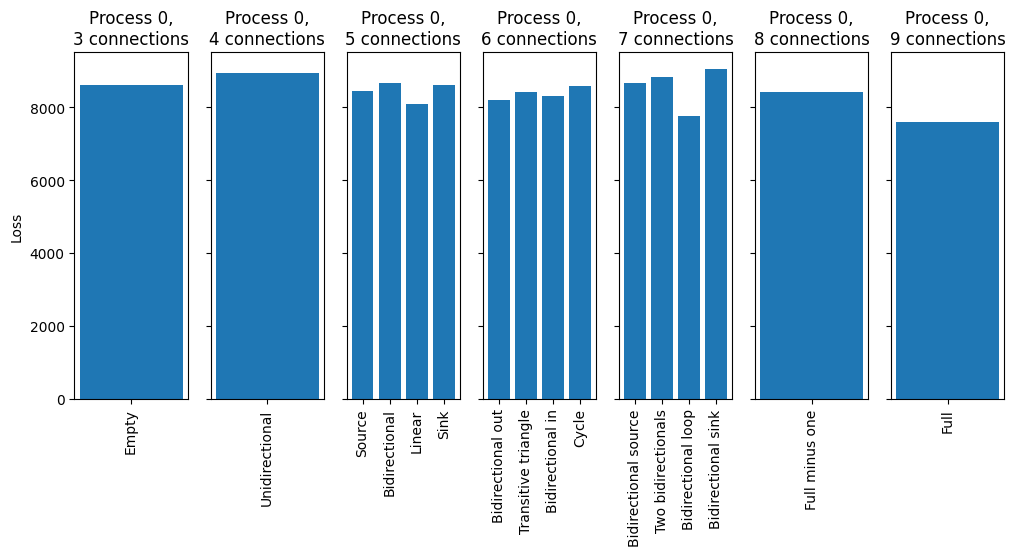

[{3: {'Empty': 8616.238498762477},
  4: {'Unidirectional': 8950.293535659774},
  5: {'Source': 8445.129547490631,
   'Bidirectional': 8682.945869626812,
   'Linear': 8106.957439338665,
   'Sink': 8620.290462172392},
  6: {'Bidirectional out': 8204.630660201037,
   'Transitive triangle': 8428.349330104786,
   'Bidirectional in': 8301.864117028428,
   'Cycle': 8592.13968798584},
  7: {'Bidirectional source': 8673.581976512998,
   'Two bidirectionals': 8846.174261605072,
   'Bidirectional loop': 7753.266137326884,
   'Bidirectional sink': 9058.60317093487},
  8: {'Full minus one': 8428.600352318423},
  9: {'Full': 7599.538236179372}}]

In [64]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 8e-8))),
           A=np.array([[0, 0.5, 0.4], [0.5, 0, 0.3], [0.4, 0.6, 0]]))

Process dynamics: [[ 0.8  0.   0. ]
 [ 0.8  0.8  0. ]
 [ 0.8 -0.8  0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.45382871 -0.03070741 -0.04706014]
 [ 0.3951711   0.4224923   0.02522317]
 [ 0.37894418 -0.37555797  0.40078115]]
Kalman filter K: [[ 0.27667951  0.09720943  0.05882517]
 [ 0.09720943  0.44035566 -0.03152897]
 [ 0.05882517 -0.03152897  0.49902357]]
Kalman filter loss: 9238.5274019735


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.03290466  0.          0.        ]
 [ 0.          0.24722858  0.        ]
 [ 0.          0.          0.33618789]]
NN K: [[ 0.22604455  0.16227679  0.01922505]
 [ 0.22221536  0.62056361 -0.0157694 ]
 [ 0.03939199 -0.12292202  0.61658601]]
Testing Empty, Trial 2
NN M: [[-0.00352243  0.          0.        ]
 [ 0.          0.22633092  0.        ]
 [ 0.          0.          0.3187775 ]]
NN K: [[ 0.22556459  0.15973528  0.01955148]
 [ 0.12109358  0.66771301 -0.01270662]
 [ 0.07237836 -0.17701383  0.63667531]]
Testing Empty, Trial 3


  6%|███▎                                                 | 1/16 [13:20<3:20:01, 800.11s/it]

NN M: [[-0.01689894  0.          0.        ]
 [ 0.          0.20636573  0.        ]
 [ 0.          0.          0.33232093]]
NN K: [[ 0.2402982   0.17538014  0.02220348]
 [ 0.20390298  0.6537537  -0.01547955]
 [ 0.1936546  -0.3230094   0.59439092]]
Testing Unidirectional, Trial 1
NN M: [[0.01277316 0.         0.        ]
 [0.13138848 0.20087883 0.        ]
 [0.         0.         0.33069678]]
NN K: [[ 0.17656005  0.19651364  0.02769843]
 [ 0.14294763  0.64603738 -0.01938807]
 [ 0.10507249 -0.20346405  0.59333819]]
Testing Unidirectional, Trial 2
NN M: [[0.006841   0.         0.        ]
 [0.07334028 0.18794105 0.        ]
 [0.         0.         0.33849117]]
NN K: [[ 0.20406147  0.17920286  0.02262946]
 [ 0.15746443  0.66526758 -0.01867499]
 [ 0.17759186 -0.27916494  0.5881834 ]]
Testing Unidirectional, Trial 3


 12%|██████▋                                              | 2/16 [26:36<3:06:12, 798.04s/it]

NN M: [[0.09077692 0.         0.        ]
 [0.1418923  0.13698334 0.        ]
 [0.         0.         0.33182746]]
NN K: [[ 0.24157245  0.164032    0.02263754]
 [ 0.22914665  0.64422941 -0.03097748]
 [ 0.11476155 -0.21036597  0.60865509]]
Testing Source, Trial 1
NN M: [[-0.18495765  0.          0.        ]
 [ 0.11244148  0.15409047  0.        ]
 [-0.11087979  0.          0.33789585]]
NN K: [[ 0.17398091  0.19120971  0.02298494]
 [ 0.20652206  0.64542315 -0.02854278]
 [ 0.14812032 -0.22602311  0.59987501]]
Testing Source, Trial 2
NN M: [[-0.15727314  0.          0.        ]
 [ 0.05904866  0.23860347  0.        ]
 [ 0.16358509  0.          0.31527137]]
NN K: [[ 0.28396989  0.19457964  0.02579651]
 [ 0.16808527  0.63389105 -0.0139449 ]
 [ 0.16065732 -0.33393437  0.59184539]]
Testing Source, Trial 3


 19%|█████████▉                                           | 3/16 [39:54<2:52:50, 797.71s/it]

NN M: [[-0.04149227  0.          0.        ]
 [-0.05211524  0.23023562  0.        ]
 [-0.0054639   0.          0.30250505]]
NN K: [[ 0.21331243  0.15101028  0.01638187]
 [ 0.25371475  0.63579172 -0.0163452 ]
 [ 0.08813852 -0.21963635  0.55656817]]
Testing Bidirectional, Trial 1
NN M: [[-0.02220659  0.03488933  0.        ]
 [ 0.00446357  0.21033695  0.        ]
 [ 0.          0.          0.30854818]]
NN K: [[ 0.20224361  0.15226755  0.02450136]
 [ 0.09409363  0.68120939 -0.01408399]
 [ 0.06628042 -0.16619097  0.56220445]]
Testing Bidirectional, Trial 2
NN M: [[0.01720392 0.06803722 0.        ]
 [0.01307798 0.21095688 0.        ]
 [0.         0.         0.41131253]]
NN K: [[ 0.19718625  0.13985902  0.02953428]
 [ 0.13809759  0.66342508 -0.0156876 ]
 [ 0.03815769 -0.13737465  0.42522845]]
Testing Bidirectional, Trial 3


 25%|█████████████▎                                       | 4/16 [53:09<2:39:21, 796.81s/it]

NN M: [[-0.08689919  0.03063166  0.        ]
 [ 0.1794067   0.19334179  0.        ]
 [ 0.          0.          0.33238549]]
NN K: [[ 0.19766543  0.20901997  0.03466732]
 [ 0.16122705  0.63411924 -0.02278785]
 [ 0.15680231 -0.21954887  0.59998701]]
Testing Linear, Trial 1
NN M: [[ 0.01798812  0.          0.        ]
 [ 0.14018042 -0.06589065  0.        ]
 [ 0.         -0.16132914  0.4941419 ]]
NN K: [[ 0.19862369  0.20108158  0.02657603]
 [ 0.14628778  0.66538332 -0.08545105]
 [ 0.22001967 -0.29628571  0.46178139]]
Testing Linear, Trial 2
NN M: [[-0.03812734  0.          0.        ]
 [ 0.08760739 -0.12754827  0.        ]
 [ 0.         -0.32213982  0.3212073 ]]
NN K: [[ 0.24772374  0.16826931  0.02254367]
 [ 0.1704586   0.63073336 -0.09293672]
 [ 0.13706379 -0.09134156  0.56817677]]
Testing Linear, Trial 3


 31%|███████████████▉                                   | 5/16 [1:06:22<2:25:50, 795.48s/it]

NN M: [[ 0.10637122  0.          0.        ]
 [ 0.0191136   0.02751446  0.        ]
 [ 0.         -0.0051133   0.34018819]]
NN K: [[ 0.22181791  0.14615279  0.02042794]
 [ 0.16725079  0.71296532 -0.04547727]
 [ 0.14533111 -0.24427824  0.59971944]]
Testing Sink, Trial 1
NN M: [[-0.02062729  0.          0.        ]
 [ 0.08474514  0.05940945  0.03749451]
 [ 0.          0.          0.34158593]]
NN K: [[ 0.20717833  0.18108082  0.02193793]
 [ 0.16692081  0.68991367 -0.08061868]
 [ 0.19896345 -0.26250298  0.58209929]]
Testing Sink, Trial 2
NN M: [[-0.06263077  0.          0.        ]
 [ 0.10973562  0.03839217  0.04471886]
 [ 0.          0.          0.32913016]]
NN K: [[ 0.24152765  0.18073836  0.02371154]
 [ 0.21230261  0.68492608 -0.089586  ]
 [ 0.15568168 -0.2287551   0.62281061]]
Testing Sink, Trial 3


 38%|███████████████████▏                               | 6/16 [1:19:36<2:12:28, 794.88s/it]

NN M: [[-0.01468725  0.          0.        ]
 [ 0.02076753  0.03069012  0.05410491]
 [ 0.          0.          0.33597567]]
NN K: [[ 0.15814047  0.16760016  0.01878649]
 [ 0.18005435  0.70322543 -0.1047813 ]
 [ 0.11810516 -0.22413345  0.60046567]]
Testing Bidirectional out, Trial 1
NN M: [[-0.04407729 -0.04007833  0.        ]
 [ 0.11574381  0.19602885  0.        ]
 [-0.02946902  0.          0.44228358]]
NN K: [[ 0.1910703   0.21929784  0.02735132]
 [ 0.14449018  0.64295293 -0.02120596]
 [ 0.06118663 -0.10894408  0.40657755]]
Testing Bidirectional out, Trial 2
NN M: [[-0.09657048  0.05689617  0.        ]
 [ 0.0346339   0.18348835  0.        ]
 [ 0.03610686  0.          0.36827421]]
NN K: [[ 0.20950618  0.1636663   0.03267798]
 [ 0.15459071  0.67289346 -0.01727487]
 [ 0.15799338 -0.32157174  0.60214628]]
Testing Bidirectional out, Trial 3


 44%|██████████████████████▎                            | 7/16 [1:32:47<1:59:01, 793.55s/it]

NN M: [[-0.35224075  0.04861013  0.        ]
 [ 0.02540704  0.14195332  0.        ]
 [-0.24915524  0.          0.31874755]]
NN K: [[ 0.12748432  0.08870031  0.01354273]
 [ 0.21970322  0.66288241 -0.03071286]
 [ 0.19774019 -0.28066554  0.48253553]]
Testing Transitive triangle, Trial 1
NN M: [[-0.09874376  0.          0.        ]
 [-0.24042425 -0.08558752  0.        ]
 [-0.17997778 -0.39084568  0.30212305]]
NN K: [[ 0.16361322  0.04868782 -0.00492956]
 [ 0.08105062  0.59492076 -0.09241216]
 [ 0.20199338 -0.12397095  0.52992951]]
Testing Transitive triangle, Trial 2
NN M: [[-0.27516494  0.          0.        ]
 [ 0.21837989 -0.12825189  0.        ]
 [ 0.28171952 -0.40964806  0.31106089]]
NN K: [[ 0.26651249  0.24139323  0.03679913]
 [ 0.13737918  0.59087026 -0.10583899]
 [ 0.21432146 -0.18190601  0.57372548]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████▌                         | 8/16 [1:45:58<1:45:43, 792.89s/it]

NN M: [[-0.12879686  0.          0.        ]
 [ 0.06995531  0.09669833  0.        ]
 [ 0.05187706 -0.09028055  0.26646124]]
NN K: [[ 0.1999979   0.21249362  0.02169432]
 [ 0.09660157  0.68185673 -0.03044384]
 [ 0.13379622 -0.20102092  0.54870489]]
Testing Bidirectional in, Trial 1
NN M: [[-0.08469565 -0.05434043  0.01417147]
 [ 0.11596799  0.18290227  0.        ]
 [ 0.          0.          0.31163301]]
NN K: [[ 0.24683752  0.19133443 -0.00192148]
 [ 0.14227567  0.65380965 -0.02211398]
 [ 0.04983257 -0.17701581  0.60807457]]
Testing Bidirectional in, Trial 2
NN M: [[-0.13757578  0.04638594  0.00285463]
 [ 0.09558255  0.19958678  0.        ]
 [ 0.          0.          0.34827269]]
NN K: [[ 0.29076452  0.13505737  0.02132066]
 [ 0.07694942  0.6766449  -0.01607246]
 [ 0.21608784 -0.32358698  0.59091637]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▋                      | 9/16 [1:59:05<1:32:17, 791.11s/it]

NN M: [[-0.12305471 -0.03360704 -0.00828386]
 [ 0.11295836  0.19440598  0.        ]
 [ 0.          0.          0.34978732]]
NN K: [[ 0.23555446  0.20915498  0.02818317]
 [ 0.16590903  0.641504   -0.02110032]
 [ 0.10319275 -0.21954197  0.62188659]]
Testing Cycle, Trial 1
NN M: [[-0.16395436  0.         -0.00672978]
 [ 0.03069965 -0.10046968  0.        ]
 [ 0.         -0.38863363  0.32104792]]
NN K: [[ 0.25362549  0.16119387  0.02445511]
 [ 0.13474913  0.59387456 -0.10190214]
 [ 0.19790898 -0.1162711   0.56575788]]
Testing Cycle, Trial 2
NN M: [[-0.16737329  0.         -0.0026873 ]
 [ 0.0187656   0.0209028   0.        ]
 [ 0.         -0.13679094  0.31934658]]
NN K: [[ 0.15873383  0.15626771  0.01337762]
 [ 0.15702536  0.67287046 -0.05576732]
 [ 0.19873664 -0.19805208  0.58530008]]
Testing Cycle, Trial 3


 62%|███████████████████████████████▎                  | 10/16 [2:12:15<1:19:03, 790.61s/it]

NN M: [[-0.09408819  0.          0.04438781]
 [ 0.18678931 -0.16316847  0.        ]
 [ 0.         -0.38095449  0.29807382]]
NN K: [[ 0.22433925  0.2079835  -0.01973161]
 [ 0.10437261  0.58199215 -0.11080922]
 [ 0.18097656 -0.10561384  0.5854256 ]]
Testing Bidirectional source, Trial 1
NN M: [[-0.27587292  0.09009171  0.        ]
 [ 0.31563307  0.01848815  0.        ]
 [ 0.02269035 -0.04762889  0.52434291]]
NN K: [[ 0.22797187  0.18089652  0.03785876]
 [ 0.14180316  0.65285409 -0.04890151]
 [ 0.1342405  -0.2409312   0.47783307]]
Testing Bidirectional source, Trial 2
NN M: [[-0.05603041  0.02969156  0.        ]
 [ 0.03610189  0.00924331  0.        ]
 [ 0.0409123  -0.1790563   0.34367841]]
NN K: [[ 0.16183523  0.18053118  0.0288581 ]
 [ 0.16529258  0.64772715 -0.06406031]
 [ 0.20840092 -0.20626972  0.57429691]]
Testing Bidirectional source, Trial 3


 69%|██████████████████████████████████▍               | 11/16 [2:25:22<1:05:48, 789.63s/it]

NN M: [[-0.11829086 -0.11653579  0.        ]
 [ 0.04201626 -0.13047876  0.        ]
 [-0.04247868 -0.18691233  0.33199452]]
NN K: [[ 0.12924725  0.21402593 -0.00335171]
 [ 0.15085546  0.62607823 -0.10147628]
 [ 0.12675562 -0.13469801  0.59794324]]
Testing Two bidirectionals, Trial 1
NN M: [[-0.57325455  0.1388666  -0.14273009]
 [ 0.06778655  0.1307766   0.        ]
 [ 0.34253455  0.          0.35278064]]
NN K: [[ 0.17878398  0.25374639  0.20174288]
 [ 0.21416124  0.66699267 -0.03067432]
 [ 0.12705788 -0.31555949  0.57321626]]
Testing Two bidirectionals, Trial 2
NN M: [[-0.23762268  0.02501168  0.03452157]
 [ 0.07071667  0.09890535  0.        ]
 [-0.03305883  0.          0.34083719]]
NN K: [[ 0.17161577  0.18134298 -0.0135169 ]
 [ 0.17304901  0.69631595 -0.03348192]
 [ 0.1216132  -0.23673729  0.60137708]]
Testing Two bidirectionals, Trial 3


 75%|███████████████████████████████████████             | 12/16 [2:38:33<52:39, 789.94s/it]

NN M: [[-0.23100033  0.12108483 -0.03891154]
 [ 0.03614127  0.2504371   0.        ]
 [ 0.06825965  0.          0.35898489]]
NN K: [[ 0.13593448  0.17710586  0.08361331]
 [ 0.17556646  0.63356132 -0.01257315]
 [ 0.19450961 -0.32305316  0.5743355 ]]
Testing Bidirectional loop, Trial 1
NN M: [[-0.15588191  0.14734039  0.        ]
 [ 0.22387923 -0.0301288   0.05288899]
 [-0.07163767  0.          0.58335954]]
NN K: [[ 0.21375844  0.19575234  0.05608182]
 [ 0.19402904  0.66489694 -0.11449123]
 [ 0.05318929 -0.13574209  0.4622121 ]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.33709505  0.14621173  0.        ]
 [ 0.04985272  0.06709022 -0.01018617]
 [ 0.29567116  0.          0.34115129]]
NN K: [[ 0.21463646  0.23350655  0.06144471]
 [ 0.20105773  0.69460485 -0.02321535]
 [ 0.18754482 -0.3889696   0.58361375]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [2:51:45<39:32, 790.68s/it]

NN M: [[-0.19564961  0.29507943  0.        ]
 [ 0.02600172  0.05353209 -0.03387367]
 [ 0.15398419  0.          0.33134445]]
NN K: [[ 0.25897864  0.08707835  0.06564914]
 [ 0.27321626  0.6732295  -0.0105118 ]
 [ 0.08468744 -0.29230269  0.59528765]]
Testing Bidirectional sink, Trial 1
NN M: [[-0.01329496  0.          0.        ]
 [ 0.07606405 -0.09852865  0.32591581]
 [ 0.02313141 -0.34819151  0.40371889]]
NN K: [[ 0.14924828  0.18750335  0.02085709]
 [ 0.13211156  0.55652824 -0.44196768]
 [ 0.160759   -0.08984324  0.48125782]]
Testing Bidirectional sink, Trial 2
NN M: [[-0.33635156  0.          0.        ]
 [-0.31835994 -0.16556571  0.18000481]
 [-0.36603214 -0.28831101  0.38478163]]
NN K: [[ 0.09918481 -0.03485872 -0.02368923]
 [ 0.18111442  0.59329731 -0.30210096]
 [ 0.21575434 -0.16805458  0.5009035 ]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [3:04:46<26:15, 787.60s/it]

NN M: [[-0.15776464  0.          0.        ]
 [ 0.02525567  0.07510802  0.21145569]
 [ 0.04177523 -0.19981592  0.38629255]]
NN K: [[ 0.15570514  0.18979518  0.02294074]
 [ 0.12291309  0.67240872 -0.26758673]
 [ 0.22299816 -0.17219431  0.56497401]]
Testing Full minus one, Trial 1
NN M: [[-0.24422801  0.2077978   0.05845224]
 [ 0.2693448  -0.33637315  0.        ]
 [ 0.17922227 -0.68740171  0.27112785]]
NN K: [[ 0.22467187  0.27032842  0.02187152]
 [ 0.0636111   0.4405974  -0.17561746]
 [ 0.18584106 -0.12872692  0.54871973]]
Testing Full minus one, Trial 2
NN M: [[-0.1856748   0.09697029  0.11803061]
 [-0.01654111 -0.07832016  0.        ]
 [-0.13237069 -0.22958694  0.34671801]]
NN K: [[ 0.20610693  0.10892499 -0.09774571]
 [ 0.11495389  0.65973242 -0.08546164]
 [ 0.20973853 -0.16887427  0.57664367]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [3:17:50<13:06, 786.76s/it]

NN M: [[-0.28661772 -0.04952995 -0.01301887]
 [-0.06741592  0.02566791  0.        ]
 [-0.01174876 -0.17505093  0.32911469]]
NN K: [[ 0.17198034  0.16113711  0.01572454]
 [ 0.16474463  0.63720335 -0.05949865]
 [ 0.18997717 -0.17906401  0.55916186]]
Testing Full, Trial 1
NN M: [[-0.26467579  0.18081515  0.11076555]
 [ 0.23965044 -0.26813917 -0.19559021]
 [-0.19293869  0.26987491  0.37046192]]
NN K: [[ 0.18258011  0.24952034 -0.02281557]
 [ 0.23599027  0.60646786  0.05280002]
 [ 0.03972819 -0.24985862  0.48721226]]
Testing Full, Trial 2
NN M: [[-0.27970227  0.12973397 -0.05234274]
 [-0.10659263 -0.16372626  0.21584406]
 [ 0.06589513 -0.31085464  0.38333158]]
NN K: [[ 0.21483428  0.08802796  0.085625  ]
 [ 0.09796688  0.64790821 -0.32686968]
 [ 0.13467507 -0.14668399  0.51611854]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 16/16 [3:30:58<00:00, 791.18s/it]

NN M: [[-0.29922877  0.18342411  0.03967718]
 [ 0.15764235 -0.21028402  0.14927295]
 [ 0.01241084 -0.22098175  0.37592444]]
NN K: [[ 0.15090308  0.17970294  0.01294894]
 [ 0.17534807  0.62400901 -0.27138142]
 [ 0.16826796 -0.15409852  0.56561583]]


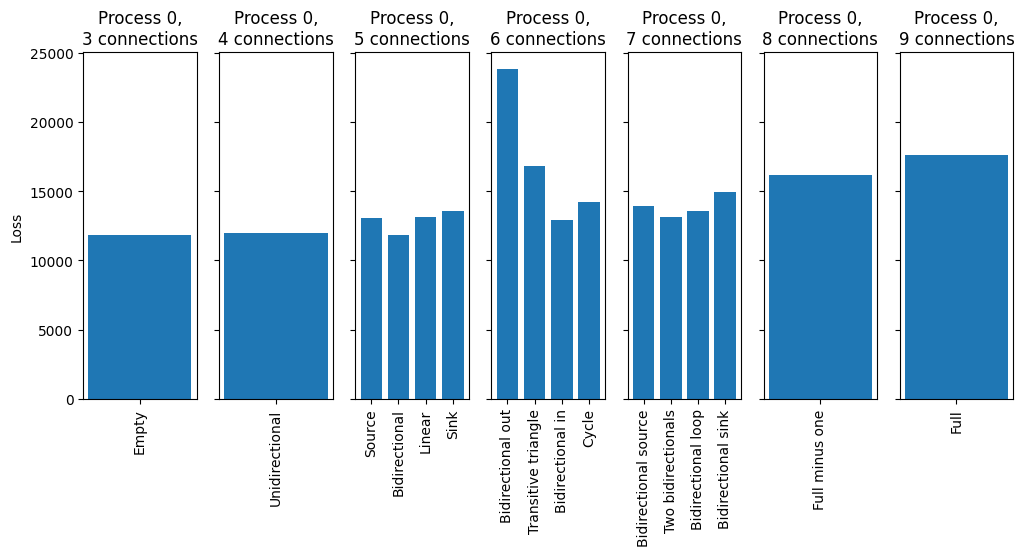

[{3: {'Empty': 11865.341311229848},
  4: {'Unidirectional': 11950.90374966669},
  5: {'Source': 13069.454013385317,
   'Bidirectional': 11844.384550455332,
   'Linear': 13126.27316130621,
   'Sink': 13586.82171702176},
  6: {'Bidirectional out': 23843.18696776918,
   'Transitive triangle': 16825.20154736089,
   'Bidirectional in': 12899.334957649766,
   'Cycle': 14219.37875817985},
  7: {'Bidirectional source': 13908.266309111938,
   'Two bidirectionals': 13124.971774540772,
   'Bidirectional loop': 13604.885044111612,
   'Bidirectional sink': 14923.896561817692},
  8: {'Full minus one': 16213.208932142257},
  9: {'Full': 17615.73311741504}}]

In [65]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(30, 3e-7), np.full(30, 2e-7))),
           A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, -0.8, 0.8]]))

A = [[0.8 0.  0. ]
 [0.8 0.8 0. ]
 [0.8 0.8 0.8]]
Eigenvalues =  [0.8 0.8 0.8]


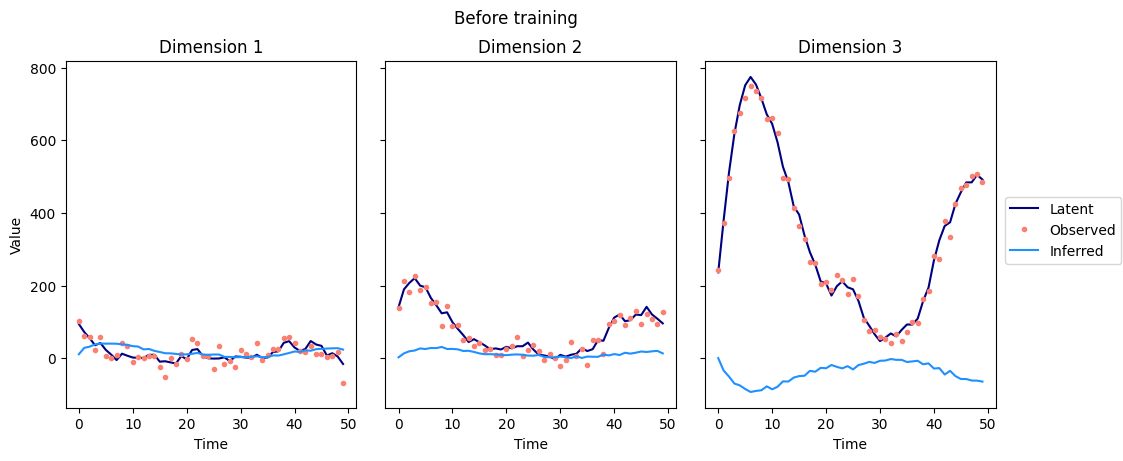

Loss 2403573.9190848754
M = [[-0.11249142 -0.          0.        ]
 [-0.02604314 -0.07370175 -0.        ]
 [ 0.24775931 -0.05485199 -0.00613772]]
K = [[ 0.04525464  0.03450686  0.05234463]
 [ 0.05408497 -0.03669137  0.04882105]
 [ 0.08987697  0.06305799 -0.14900673]]


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.11it/s]


Mean loss 2370575.1702338904


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.05it/s]


Mean loss 1692260.4690603137


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.40it/s]


Mean loss 1074309.28376921


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.67it/s]


Mean loss 674925.5873688901


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.27it/s]


Mean loss 271072.90727908077


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


Mean loss 127519.89332328571


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.31it/s]


Mean loss 404088.67068323365


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.41it/s]


Mean loss 117673.92794250562


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.49it/s]


Mean loss 388484.8298407812


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.22it/s]


Mean loss 109721.19084959016


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.15it/s]


Mean loss 428120.78636381263


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.64it/s]


Mean loss 108075.31145853382


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.32it/s]


Mean loss 363202.06272186106


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.16it/s]


Mean loss 86899.10393368774


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


Mean loss 297157.54645177996


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


Mean loss 86077.30017917595


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.16it/s]


Mean loss 316724.7326791521


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.62it/s]


Mean loss 104086.35029316196


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.68it/s]


Mean loss 276273.31825647905


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.30it/s]


Mean loss 109283.01654088665


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.19it/s]


Mean loss 317073.86887626845


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.24it/s]


Mean loss 102714.03356586056


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.45it/s]


Mean loss 395213.6968297808


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.47it/s]


Mean loss 106708.59148423902


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.04it/s]


Mean loss 304532.5370327252


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.02it/s]


Mean loss 112549.49212648692


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.88it/s]


Mean loss 270951.6379100946


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.38it/s]


Mean loss 100748.64298115988


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


Mean loss 273105.30683028727


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


Mean loss 107711.89638324376


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.97it/s]


Mean loss 271785.18950090033


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.71it/s]


Mean loss 50556.57113645556


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.02it/s]


Mean loss 47106.23048269135


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


Mean loss 41306.17952964154


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.58it/s]


Mean loss 40203.4070078314


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.13it/s]


Mean loss 38055.197645698245


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.01it/s]


Mean loss 40786.426511794794


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.98it/s]


Mean loss 39127.44816240864


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.84it/s]


Mean loss 37012.853001345575


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.27it/s]


Mean loss 36146.306863649304


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.80it/s]


Mean loss 43850.52619733357


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.88it/s]


Mean loss 51644.081734365995


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.99it/s]


Mean loss 59436.22618453835


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.68it/s]


Mean loss 92746.10416486887


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.83it/s]


Mean loss 90540.93846690096


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.68it/s]


Mean loss 146546.59271345433


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.20it/s]


Mean loss 97958.37623993176


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.89it/s]


Mean loss 145072.00886227362


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


Mean loss 115117.30713593638


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.19it/s]


Mean loss 152161.1923245304


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.88it/s]


Mean loss 91429.17348481114


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.56it/s]


Mean loss 119133.85013668849


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.59it/s]


Mean loss 54036.38191066368


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.35it/s]


Mean loss 60088.74935927859


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.59it/s]


Mean loss 42306.84113126631


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.09it/s]


Mean loss 45176.88008328112


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.02it/s]


Mean loss 46956.89946759083


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.01it/s]


Mean loss 67108.50271563437


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.25it/s]


Mean loss 66907.85013782268


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.17it/s]


Mean loss 92074.05586330676


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.03it/s]


Mean loss 69784.38431603466


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.13it/s]


Mean loss 47682.43199739907


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.94it/s]


Mean loss 29802.864638105115


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.26it/s]


Mean loss 29505.59038447096


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.60it/s]


Mean loss 27522.68026554565


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


Mean loss 27659.24622595256


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


Mean loss 28919.795678677707


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.16it/s]


Mean loss 27068.79196267305


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.45it/s]


Mean loss 30023.52722561443


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.86it/s]


Mean loss 27367.490068552725


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.50it/s]


Mean loss 26817.200468194107


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


Mean loss 26764.938997662022


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.81it/s]


Mean loss 24966.63488964847


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.67it/s]


Mean loss 25126.322761838197


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.35it/s]


Mean loss 25561.006574345934


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.06it/s]


Mean loss 26539.405582644853


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.55it/s]


Mean loss 26270.20353024578


100%|████████████████████████████████████████████████████| 40/40 [1:54:01<00:00, 171.04s/it]


Mean loss 28444.40609936421


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.25it/s]


Mean loss 26998.09622709132


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.32it/s]


Mean loss 25324.532467150035


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.38it/s]


Mean loss 24967.66812859702


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.47it/s]


Mean loss 22699.87220342141


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.72it/s]


Mean loss 23296.172176125303


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.62it/s]


Mean loss 25824.364439953428


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.33it/s]


Mean loss 26007.258819896237


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.41it/s]


Mean loss 24026.847862996256


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.45it/s]


Mean loss 24910.457806491693


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.41it/s]


Mean loss 25728.624374308536


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.64it/s]


Mean loss 25366.799946786068


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.55it/s]


Mean loss 23952.157385922063


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.62it/s]


Mean loss 24550.243673964058


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.69it/s]


Mean loss 26008.601497567703


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.41it/s]


Mean loss 23929.51868223301


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.22it/s]


Mean loss 22949.305213173247


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.29it/s]


Mean loss 24244.913015561695


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.69it/s]


Mean loss 22698.612181884004


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.56it/s]


Mean loss 22878.031879074042


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.62it/s]


Mean loss 25235.820526835865


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.73it/s]


Mean loss 23567.526509645773


100%|███████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.40it/s]


Mean loss 24995.28374900237


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.12it/s]


Mean loss 23204.0994270496


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.51it/s]


Mean loss 23337.11251079258


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.96it/s]


Mean loss 23300.953771316832


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.38it/s]


Mean loss 21764.884177736414


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.39it/s]


Mean loss 21815.90783829245


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.32it/s]


Mean loss 21824.003473635337


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.79it/s]


Mean loss 20514.315242785742


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.39it/s]


Mean loss 24284.77425823527


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.58it/s]


Mean loss 23862.719529506623


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.70it/s]


Mean loss 24729.454625259925


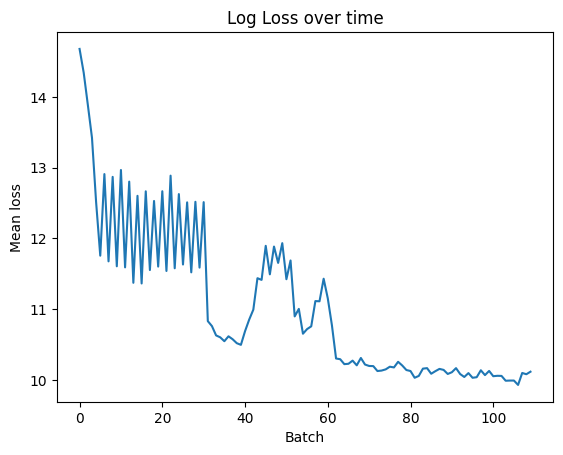

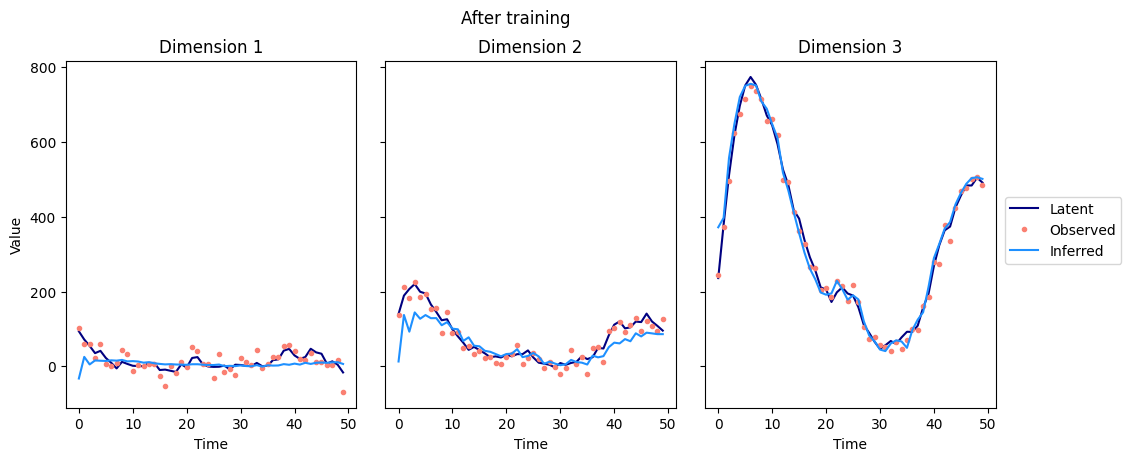

Loss 21328.993128438327
M = [[-0.42578257  0.          0.        ]
 [-0.49148594 -0.22928515  0.        ]
 [ 0.87309701  0.50377747  0.33388183]]
K = [[ 0.04021729 -0.01354602  0.03287908]
 [ 0.06719659  0.27254589  0.16828041]
 [ 0.15136986  0.54940442  0.45242012]]


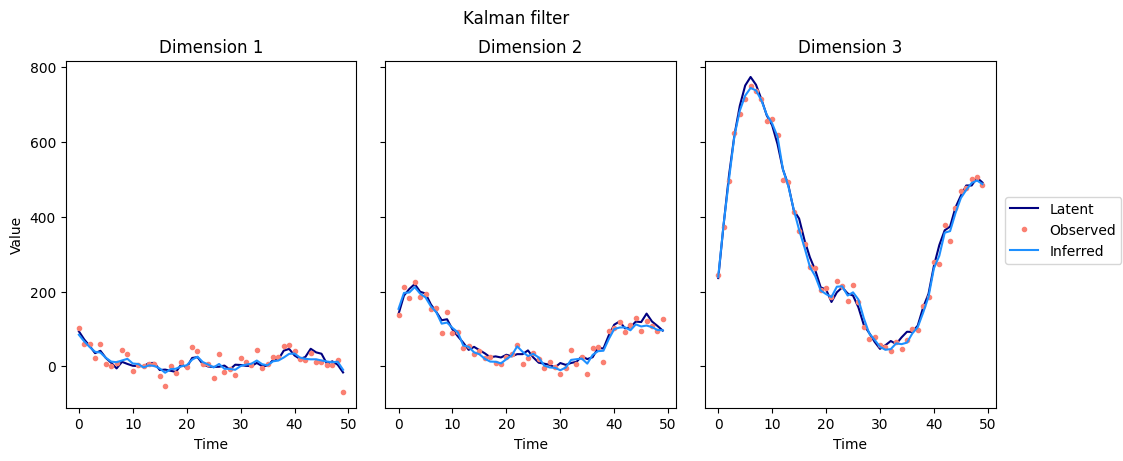

Loss 8287.315055988764
M = [[ 0.47360177 -0.1043154  -0.04853596]
 [ 0.32563549  0.38141492 -0.13263969]
 [ 0.19711075  0.24564672  0.3782864 ]]
K = [[0.27760354 0.06972429 0.06066996]
 [0.06972429 0.35743174 0.16579961]
 [0.06066996 0.16579961 0.52714199]]


In [72]:
proc = mk_nd_proc(rng, 3,
                  A=np.array([[0.8, 0, 0], [0.8, 0.8, 0], [0.8, 0.8, 0.8]]))
compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 8e-8))), mask=np.array([[1,0,0],[1,1,0],[1,1,1]]))